<a href="https://colab.research.google.com/github/hugohiraoka/Bank_Customer_Churn_Prediction/blob/main/Bank_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bank Customer Churn Prediction**


## **Problem Statement**



Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

We will build a neural network-based binary classifier to predict whether the bank customer will churn or not in the next 6 months.

![](https://i.imgur.com/KugdmLG.jpg)

## **Data Description**

The bank's dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

- RowNumber: Unique index
- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer
- CreditScore: It defines the credit history of the customer.  
- Geography: A customer’s location    
- Gender: It defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values: 0=No (Customer did not leave the bank )
1=Yes ( Customer left the bank ).


## **Assumptions**

We are going to make the following assumptions.

1. The sample data is equally representative of all customers of the bank, that is, it collects all possible variations of customer's characteristics.
2. The sample data is not exposed to data bias, that is it was not sampled to direct the predictions in one way or another.
3. The sample data is equally proportional among features to the whole data of the bank (that is, if tenure = 10 in the whole data is 5%, then in the sample data, the tenure represents 5%).
4. The data is until the end of the year. That means, that Tenure=0, are customers from Jan1 to Dec31.



##**Initial Definitions**

In [1]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [174]:
#install keras
!pip install keras==2.12.0

<IPython.core.display.Javascript object>

In [3]:
#import libraries

#ignoring warnings
import warnings
warnings.filterwarnings("ignore")
#importing necessary libraries

import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import math
import tensorflow as tf
import keras
import random
from random import shuffle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, InputLayer
from keras import optimizers, callbacks
from keras import backend as K

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, RMSprop, SGD

from keras.wrappers.scikit_learn import KerasClassifier

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings("ignore")


<IPython.core.display.Javascript object>

In [4]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

<IPython.core.display.Javascript object>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#read csv file and load into a panda dataframe
data = pd.read_csv('/content/gdrive/MyDrive/Notebooks/Bank_Customer_Churn/Data/bank.csv')

<IPython.core.display.Javascript object>

## **Functions**

In [6]:
#Useful functions for this notebook

#Function to show %
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 4))
    else:
        plt.figure(figsize=(n + 2, 4))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#function to create histograms and boxplots at once
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()


#this function will make a confusion matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)


    if title:
        plt.title(title)

#plot distribution with a predicted vs actual
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    target_uniq = data[target].unique()

    #axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    axs[0, 0].set_title("Distribution of target for " + target +"="+ str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    #axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    axs[0, 1].set_title("Distribution of target for " +target +"=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()


<IPython.core.display.Javascript object>

## **Dataset Overview, Dataset Quick Analysis and Pre-Processing**

### **Data Overview - Quick Analysis**

In [7]:
#Visualize the shape of the dataframe
print("The dataset contains %d"%data.shape[0] + " rows.")
print("The dataset contains %d"%data.shape[1] + " columns.")

<IPython.core.display.Javascript object>

The dataset contains 10000 rows.
The dataset contains 14 columns.


In [8]:
#Visualize dataframe basic information
data.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are 3 Categorical features (Surname, Geography, and Gender) and 11 numerical features. We anticipate that we will drop 'Surname', 'RowNumber', and 'CustomerId'.

Notice that info() reports no null values in the dataset.

In [9]:
#visualize the head of the dataframe
data.head()

<IPython.core.display.Javascript object>

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [10]:
#visualize the tail of the dataframe
data.tail()

<IPython.core.display.Javascript object>

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0

From observing the head and tail we anticipate that Age, Balance, Tenure, CreditScore, and EstimatedSalary will probably have to be normalized so the large values don't overwhelmingly overwhelm the model. We also anticipate that Geography and Gender will have to be label encoded to be of use in our model.

In [11]:
#some statistics about the dataFrame
data.describe().T

<IPython.core.display.Javascript object>

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

**CreditScore.** There maximum CreditScore is 850 and the minimum is 350. The average is 651 and the standard deviation is 97, accounting for a large difference between quartiles. Q1 is 584 and Q3 is 718. The median is 65.

**Age.** The oldest customer is 92 and the youngest is 18. The average is 39 and the standard deviation is 10.49. Q1 is 32 and Q3 is 44. The median is 37. This points that the majority of customers at the bank are 44 or younger.

**Balance.** The largest balance is 251K and the smallest balance is 0. The average is 76K and the standard deviation is 62K. Q1 is 0 and Q3 is 128K. The median is 97K.

**EstimatedSalary.** The largest est. salary is 200K and the smallest is 58K. The average is 100K and the standard deviation is 57K. Q1 is 51K and Q3 is 149K. The median is 100K.

The statistics of all the other features are not relevant.

###**Analyzing Null or Missing Values**

In [12]:
#Checking missing values
data.isna().sum()

<IPython.core.display.Javascript object>

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no null values in agreement with info().

###**Checking Duplicated Values**

In [13]:
#Duplicated entries (exact entries or 2 or more rows are exactly the same)
data.duplicated().sum()

<IPython.core.display.Javascript object>

0

There are no duplicated entries.

In [14]:
#Duplicated Customers (duplicated customer key)?
data['CustomerId'].duplicated().sum()

<IPython.core.display.Javascript object>

0

There is only one entry per customer.

### **Dropping No Contribution Features**

In [15]:
#copy original dataframe to a 'work' dataframe
dataw_df = data.copy()

<IPython.core.display.Javascript object>

Previously we had anticipated that some features would be dropped because they do not contribute anything to the analysis and model.

The features that do not contribute to the model are:

- RowNumber: index of row
- CustomerId: an internal use number
- Surname: name of customer.

Note that the Surname should have never been included in the dataset. This is a major liability because it may violate state/federal privacy laws and violate the customer's  bank secret.

In [16]:
#Drop columns that do not contribute to data analysis
coltodrop = ['RowNumber','CustomerId','Surname']
dataw_df.drop(coltodrop, axis=1,inplace=True)

<IPython.core.display.Javascript object>

###**Features Summary**

In [17]:
# Making a list of all variables
cat_col = [
    "CreditScore",
    "Geography",
    "Gender",
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "HasCrCard",
    "IsActiveMember",
    "EstimatedSalary",
    "Exited"
]
i=0
#features types, counts for categorical columns
for column in cat_col:
    print(cat_col[i])
    print("-"*55)
    print(dataw_df[column].value_counts())
    print("\n")
    i+=1

<IPython.core.display.Javascript object>

CreditScore
-------------------------------------------------------
850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64


Geography
-------------------------------------------------------
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


Gender
-------------------------------------------------------
Male      5457
Female    4543
Name: Gender, dtype: int64


Age
-------------------------------------------------------
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: Age, Length: 70, dtype: int64


Tenure
-------------------------------------------------------
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64


Balance
-------------------------------------------------------
0.00       

We notice that Exited is the Target and that the dataset is imbalanced.

## **Univariate Analysis**

- CreditScore: It defines the credit history of the customer.
- Geography: A customer’s location
- Gender: It defines the Gender of the customer
- Age: Age of the customer
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
-Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values: 0=No (Customer did not leave the bank ) 1=Yes ( Customer left the bank ).

In [18]:
#Declare and Initialize variables for figure numbering
figNo=1
j=0

#Convert Dataframe to Yes/No and Categorical for visualization Purposes
datav_df = dataw_df.copy()

datav_df = datav_df.replace({'Exited':{0:'No', 1:'Yes'},'HasCrCard':{0:'No',1:'Yes'},
                             'IsActiveMember':{0:'No',1:'Yes'}})

<IPython.core.display.Javascript object>

###**CreditScore**

CreditScore (numerical):  It defines the credit score of the customer.

<IPython.core.display.Javascript object>

Fig 1 - CreditScore


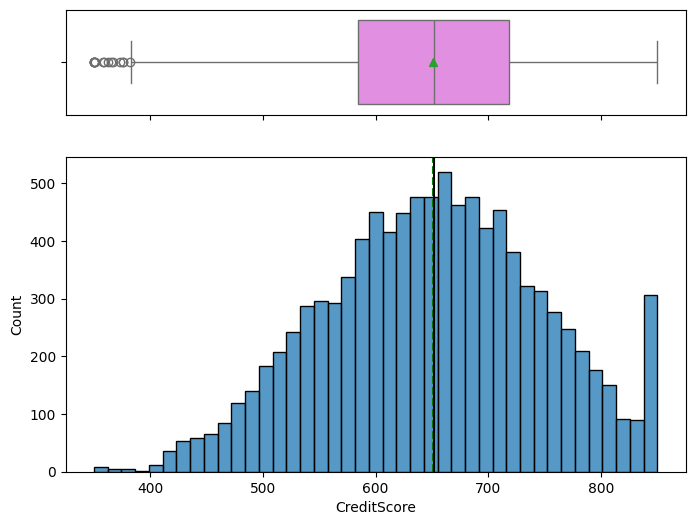

In [19]:
#visualize the distribution of CreditScore

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat)
figNo+=1

#Plot histogram of feature CreditScore
histogram_boxplot(datav_df, "CreditScore", figsize=(8,6), kde=False, bins=None)

CreditScore distribution is skewed to the left with outliers below 400. From the distribution we can see that the median is about 660 and the mean is about the same than the median.

We cannot determine the mode from this plot. In fact, this plot is deceiving. It may lead us to believe that a CreditScore around 670 is the mode. However, the bars represents bins, not unique values.  

Notice that there is a high number of customers with a high credit score above 840.

The outlier values below 400 are valid because the bank may have customers that have a very low CreditScore. Also the highest CreditScores are also valid because there are always customers with very high scores in the bank industry.

We will not drop these outliers as they represent valid data.

In [20]:
#Recalculate some statistics
cs_mode = datav_df['CreditScore'].mode()[0]
cs_mean = datav_df['CreditScore'].mean()
cs_max = datav_df['CreditScore'].max()
cs_min = datav_df['CreditScore'].min()
cs_std = datav_df['CreditScore'].std()
cs_med = datav_df['CreditScore'].median()

cssdf = {'min': [cs_min], 'mean': [cs_mean], 'max': [cs_max], 'mode': [cs_mode],
          'stdev': [cs_std], 'median': [cs_med]}

csStat = pd.DataFrame(cssdf)
csStat

<IPython.core.display.Javascript object>

min      mean  max  mode      stdev  median
0  350  650.5288  850   850  96.653299   652.0

We checked from our calculations that the mode is 850, the mean is 651, the max is 850, and the min is 350. The standard deviation is 97 and the median is 652.

Notice that the mode is equal to the maximum CreditScore.

We will keep all outliers as they represent valid data.

In [21]:
#visualize repetitions of CreditScore
datav_df['CreditScore'].value_counts(ascending=False)

<IPython.core.display.Javascript object>

850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64

We can see that 850, which also happens to be the maximum CreditScore, is overwhelmingly the most common CreditScore. Next is 678, 655, 705, and 667. All are good scores. So we can infer that the most common CreditScores are high scores. As we can see that the distribution plot is skewed to the left, the bank customers' credit score trends to be good.

<IPython.core.display.Javascript object>

Fig 2 - CreditScore (15 most common)


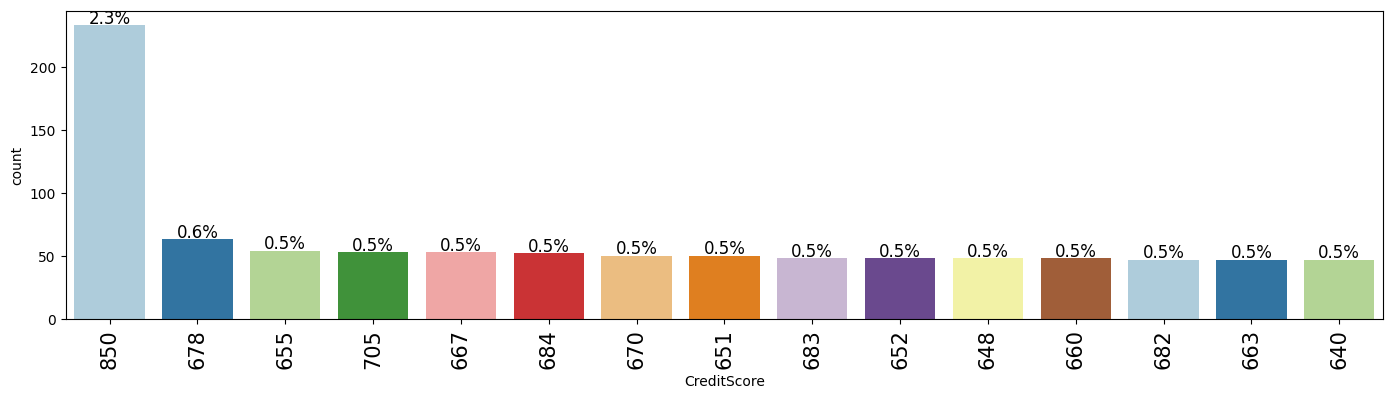

In [22]:
#visualize most common credit scores

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat + " (15 most common)")
figNo+=1
j+=1

#Plot barplot of feature CreditScore
labeled_barplot(datav_df, "CreditScore", perc=True, n=15)

2.3% of customers have a CreditScore of 850. We can see that a high credit score is common at the bank.


###**Geography**

A customer’s location.

<IPython.core.display.Javascript object>

Fig 3 - Geography


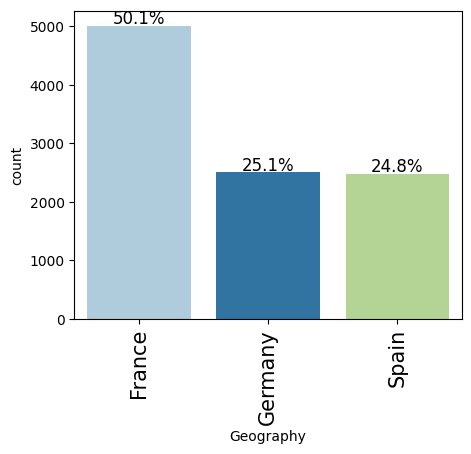

In [23]:
#visualize customer's location distribution

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat)
figNo+=1
j+=1

#Plot barplot of feature Geography distribution
labeled_barplot(datav_df, "Geography", perc=True, n=None)

50% of customers are in France. 25% are in Germany and 25% are in Spain.

### **Gender**

Feature that specifies if a customer is male or female.

<IPython.core.display.Javascript object>

Fig 4 - Gender


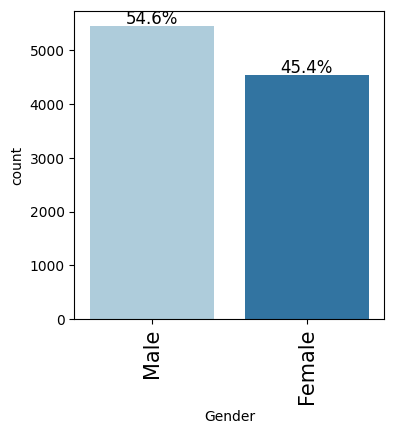

In [24]:
#visualize customer's gender distribution

Title_cat = cat_col[j]
print("Fig "+ str(figNo)+" - "+ Title_cat)
figNo+=1
j+=1

#Plot barplot of feature Gender distribution
labeled_barplot(datav_df, "Gender", perc=True, n=None)

55% of customers are male.

###**Age**

Customer age in years.

<IPython.core.display.Javascript object>

Fig 5 - Age


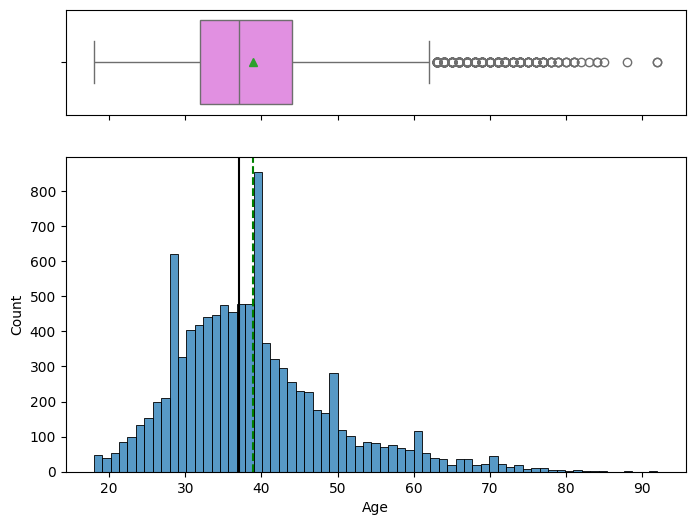

In [25]:
#Visualize the distribution of Age
Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

#Plot histogram of feature Age
histogram_boxplot(datav_df, "Age", figsize=(8, 6), kde=False, bins=None)

Age distribution is skewed to the right with outliers beyond 60. From the distribution we can see that the median is about 37 and the mean is about 39.

We can also observe that the mode is about 37-38 (the second most common age is 26-28.

The distribution shows that the bank's population is young.

The outlier values are valid because the bank may have customers that belong to the baby boomer generation and older. The data of these customers may be important, so we will not drop these outliers.

In [26]:
#Recalculate some statistics
age_mode = dataw_df['Age'].mode()[0]
age_mean = dataw_df['Age'].mean()
age_max = dataw_df['Age'].max()
age_min = dataw_df['Age'].min()
age_std = dataw_df['Age'].std()
age_med = dataw_df['Age'].median()

agesdf = {'min': [age_min], 'mean': [age_mean], 'max': [age_max], 'mode': [age_mode],
          'stdev': [age_std], 'median': [age_med]}

ageStat = pd.DataFrame(agesdf)
ageStat

<IPython.core.display.Javascript object>

min     mean  max  mode      stdev  median
0   18  38.9218   92    37  10.487806    37.0

We verified from our calculations that the mode is 37, the mean is 39, the max age is 92, and the min age is 18.

We will keep all outliers as they represent valid data.

<IPython.core.display.Javascript object>

Fig 6 - Age (15 most common)


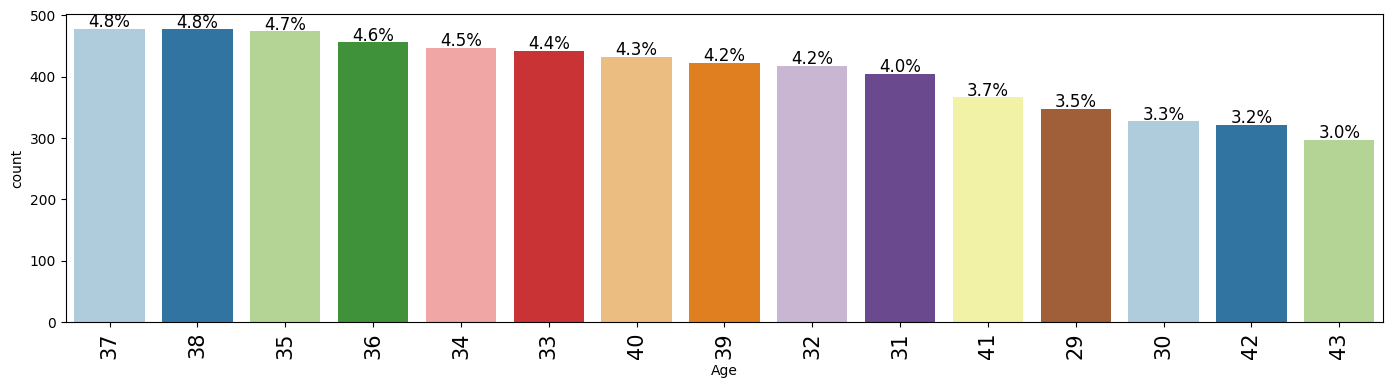

In [27]:
#visualize most common Ages Distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title +" (15 most common)")
figNo+=1
j+=1

#Plot barplot of feature Age
labeled_barplot(datav_df, "Age", perc=True, n=15)

The most common age is 37 (mode). The most common ages are in the range from 30 to 41. We can deduct that most customers are relatively young.

###**Tenure**

Tenure is the amount of years the customer has been with the bank.

<IPython.core.display.Javascript object>

Fig 7 - Tenure


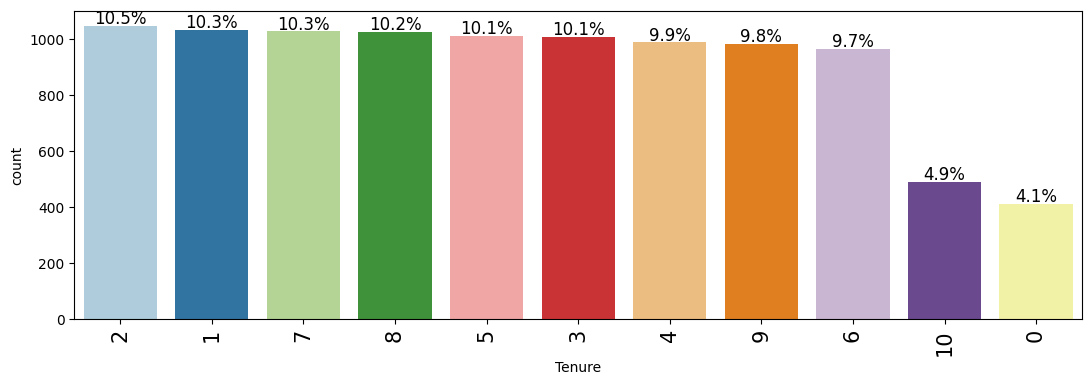

In [28]:
#visualize most common Ages Distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

#Plot barplot of feature Tenure
labeled_barplot(datav_df, "Tenure", perc=True, n=None)

Notice that between 1 to 9 years, the distribution is very similar, between 9.7% to 10.5% of the total number of customers. Customers that have a tenure of 10 years are only 4.9% and new customers (0 years) are only 4.1%.

We are wondering why customers with tenure 10 years are only 4.9%, less than 50% than customers with tenure 1 year.  Is this because the bank opened 10 years ago and tenure=10 are the first customers?

Also we can't help ask why the number of new customers (tenure=0) is the lowest with only 4.1% of all customers. This has to be analyzed in detail later in our study but this may be an indication that either the market is saturated or the bank has not grown in this year.


<IPython.core.display.Javascript object>

Fig 8 - Tenure


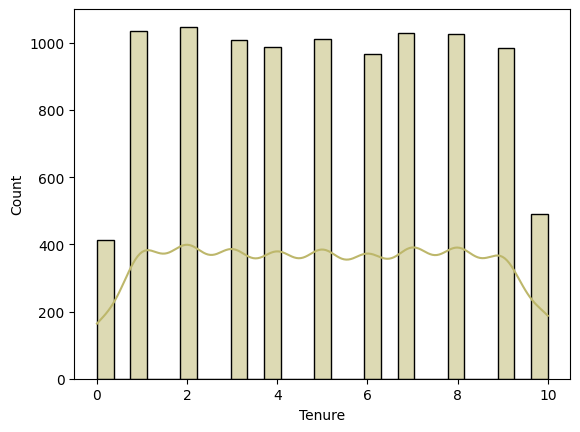

In [29]:
#visualize the Tenure distribution with Kernel density estimation

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a histogram to visualize the number of customer per tenure year
sns.histplot(dataw_df, x= "Tenure", stat="count",color="DarkKhaki", kde=True)
plt.show()

Certainly customers with tenure 10 are around 500, and new customers are barely more than 400. Considering our Assumptions (at the beginning of this study), we can deduct that the growth of customer acquisition has fallen significantly from the previous year new customers have fallen significantly by 62% in comparison to the previous year, and 64% in comparison to 2 years ago. This isn't very good news for the bank.

Again, considering the Assumptions made earlier, we can conclude that either the bank had a major customer growth 10 years ago of 62% or that was actually the first year of the bank's operations.

Also, after the first year, the bank never experience such a year-to-year growth gain again.

In [30]:
#Recalculate some statistics
ten_mode = dataw_df['Tenure'].mode()[0]
ten_mean = dataw_df['Tenure'].mean()
ten_max = dataw_df['Tenure'].max()
ten_min = dataw_df['Tenure'].min()
ten_std = dataw_df['Tenure'].std()
ten_med = dataw_df['Tenure'].median()

tensdf = {'min': [ten_min], 'mean': [ten_mean], 'max': [ten_max], 'mode': [ten_mode],
          'stdev': [ten_std], 'median': [ten_med]}

tenStat = pd.DataFrame(tensdf)
tenStat

<IPython.core.display.Javascript object>

min    mean  max  mode     stdev  median
0    0  5.0128   10     2  2.892174     5.0

The only meaningful statistics is the mode. Customers with 2 years tenure are the largest group.


###**Balance**

How much money the customer has in the bank.

<IPython.core.display.Javascript object>

Fig 9 - Balance


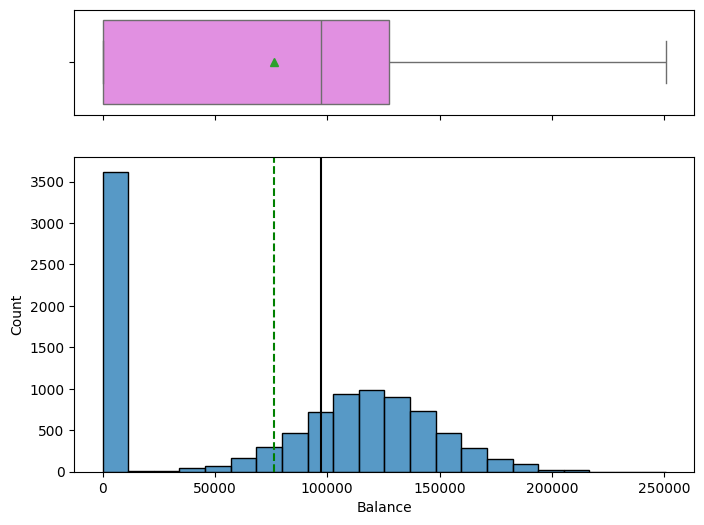

In [31]:
#visualize the Balance distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a histogram for Balance distribution
histogram_boxplot(datav_df, "Balance", figsize=(8,6), kde=False, bins=None)

Notice that over 3500 customers have 0 balance (or nearly zero balance). We have seen earlier that actually 3,617 customers have zero balance. This may indicate non active customers but also customers that do not have bank accounts with the bank (only credit cards).

In [32]:
#Recalculate some statistics
bal_mode = datav_df['Balance'].mode()[0]
bal_mean = datav_df['Balance'].mean()
bal_max = datav_df['Balance'].max()
bal_min = datav_df['Balance'].min()
bal_std = datav_df['Balance'].std()
bal_med = datav_df['Balance'].median()

balsdf = {'min': [bal_min], 'mean': [bal_mean], 'max': [bal_max], 'mode': [bal_mode],
          'stdev': [bal_std], 'median': [bal_med]}

balStat = pd.DataFrame(balsdf)
balStat

<IPython.core.display.Javascript object>

min          mean        max  mode         stdev    median
0  0.0  76485.889288  250898.09   0.0  62397.405202  97198.54

The above statistics are highly influenced by a the large group of customers with zero balance. However, keep in mind that customers with zero balance represent a valid and useful data.

However, we can also visualize the data without customers with balance zero and observe the statistics.

In [33]:
#Drop customers that have a zero balance
bal_noZero_df = datav_df.loc[datav_df['Balance']>0]

#Recalculate statistics for balance>0
bal_zero_mode = bal_noZero_df['Balance'].mode()[0]
bal_zero_mean = bal_noZero_df['Balance'].mean()
bal_zero_max = bal_noZero_df['Balance'].max()
bal_zero_min = bal_noZero_df['Balance'].min()
bal_zero_std = bal_noZero_df['Balance'].std()
bal_zero_med = bal_noZero_df['Balance'].median()

bal_zerosdf = {'min': [bal_zero_min], 'mean': [bal_zero_mean], 'max': [bal_zero_max], 'mode': [bal_zero_mode],
          'stdev': [bal_zero_std], 'median': [bal_zero_med]}

bal_zeroStat = pd.DataFrame(bal_zerosdf)
bal_zeroStat

<IPython.core.display.Javascript object>

min           mean        max       mode         stdev     median
0  3768.69  119827.493793  250898.09  105473.74  30095.056462  119839.69

Notice that among customers with Balance>0, the minimum balance is \$3.8K, the maximum balance is \$251K, the average balance is \$120K and the median is \$120K. The standard deviation is \$30k. The most common customer has around \$105K.

So among customers with balance>0, the bank's clientele is rather wealthy.

###**NumOfProducts**

The number of Products a customer has purchased through the bank.

<IPython.core.display.Javascript object>

Fig 10 - NumOfProducts


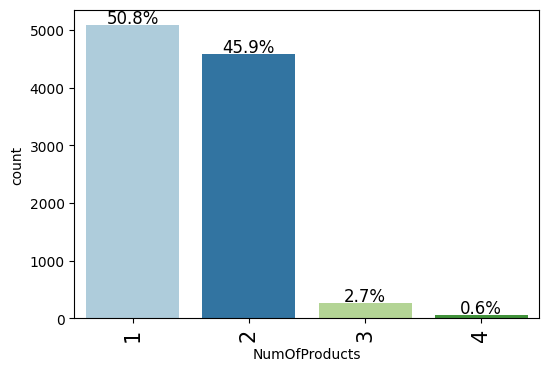

In [34]:
#visualize the NumOfProducts distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a barplot for Number of Products distribution
labeled_barplot(datav_df, "NumOfProducts", perc=True, n=None)

Most customers have 1 product, representing 51% of all customers and 46% have 2 products. Only 3% have 3 products and less than 1% have 4 products.

More than 96% of customers have up to 2 products with the bank, and less than 4% have 3 or 4 products. Actually almost no customers have 4 products with the bank.

We should analyze later what happens with customers that have 3 and 4 products to see if this could be replicated to bring more 3-4 product customers to the bank.

###**HasCrCard**

Specifies if the customer has a credit card.

<IPython.core.display.Javascript object>

Fig 11 - HasCrCard


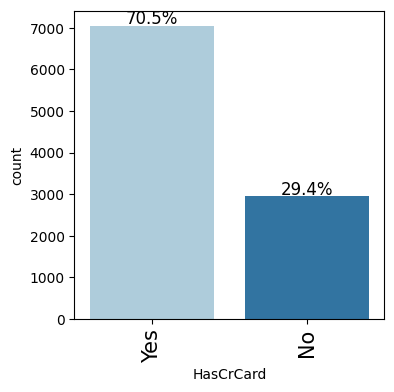

In [35]:
#visualize the HasCard distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a barplot for HasCrCard distribution
labeled_barplot(datav_df, "HasCrCard", perc=True, n=None)

70.5% of customers have a credit card.

###**IsActiveMember**

Yes if a customer uses bank products regularly, has regular transactions.

<IPython.core.display.Javascript object>

Fig 12 - IsActiveMember


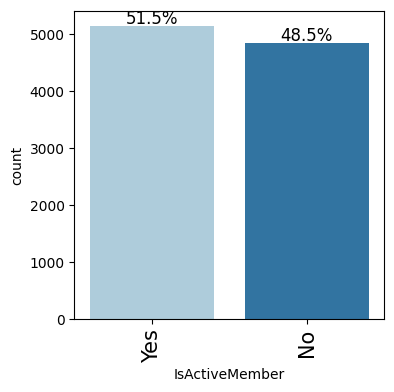

In [36]:
#visualize the IsActiveMember distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#plot a barplot for IsActiveMember distribution
labeled_barplot(datav_df, "IsActiveMember", perc=True, n=None)

52% of customers are active.

###**EstimatedSalary**

The estimated salary of the customers.

<IPython.core.display.Javascript object>

Fig 13 - EstimatedSalary


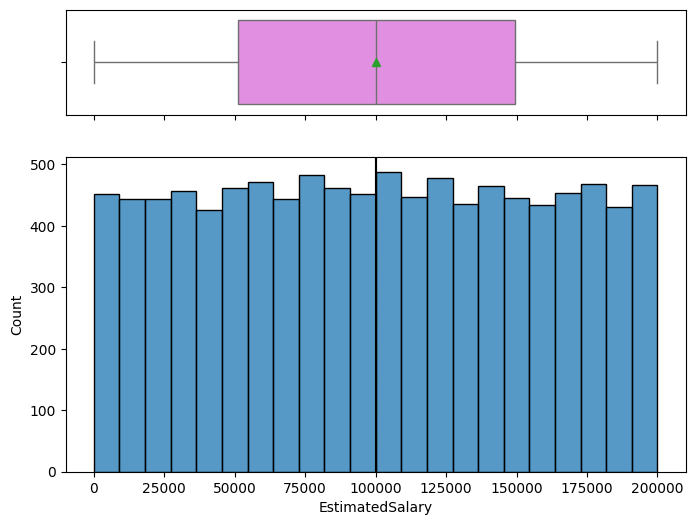

In [37]:
#visualize the EstimatedSalary distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

#plot a barplot for EstimatedSalary distribution
histogram_boxplot(datav_df, "EstimatedSalary", figsize=(8, 6), kde=False, bins=None)

The distribution of estimated salaries is similar among all customers when grouped in bins.

In [38]:
#Recalculate some statistics
estSal_mode = datav_df['EstimatedSalary'].mode()[0]
estSal_mean = datav_df['EstimatedSalary'].mean()
estSal_max = datav_df['EstimatedSalary'].max()
estSal_min = datav_df['EstimatedSalary'].min()
estSal_std = datav_df['EstimatedSalary'].std()
estSal_med = datav_df['EstimatedSalary'].median()

estSalsdf = {'min': [estSal_min], 'mean': [estSal_mean], 'max': [estSal_max], 'mode': [estSal_mode],
          'stdev': [estSal_std], 'median': [estSal_med]}

estSalstat = pd.DataFrame(estSalsdf)
estSalstat

<IPython.core.display.Javascript object>

min           mean        max      mode         stdev      median
0  11.58  100090.239881  199992.48  24924.92  57510.492818  100193.915

The smallest est. salary is \$12K and the largest est. salary is \$200K. The average salary is \$100K and the mode is \$25K. The median is \$100K and the standard deviation is \$57K.

There is a very large difference between the largest and smallest salary.

There are no outliers in the estimated Salaries data.

<IPython.core.display.Javascript object>

Fig 14 - EstimatedSalary


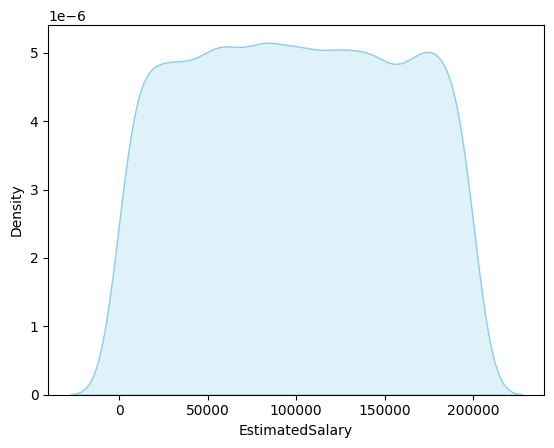

In [39]:
#visualize the EstimatedSalary distribution KDE

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1

sns.kdeplot(data=datav_df, x='EstimatedSalary', color='skyblue', fill= True)
plt.show()

Notice that this is a uniform distribution.

<IPython.core.display.Javascript object>

Fig 15 - EstimatedSalary (15 most common)


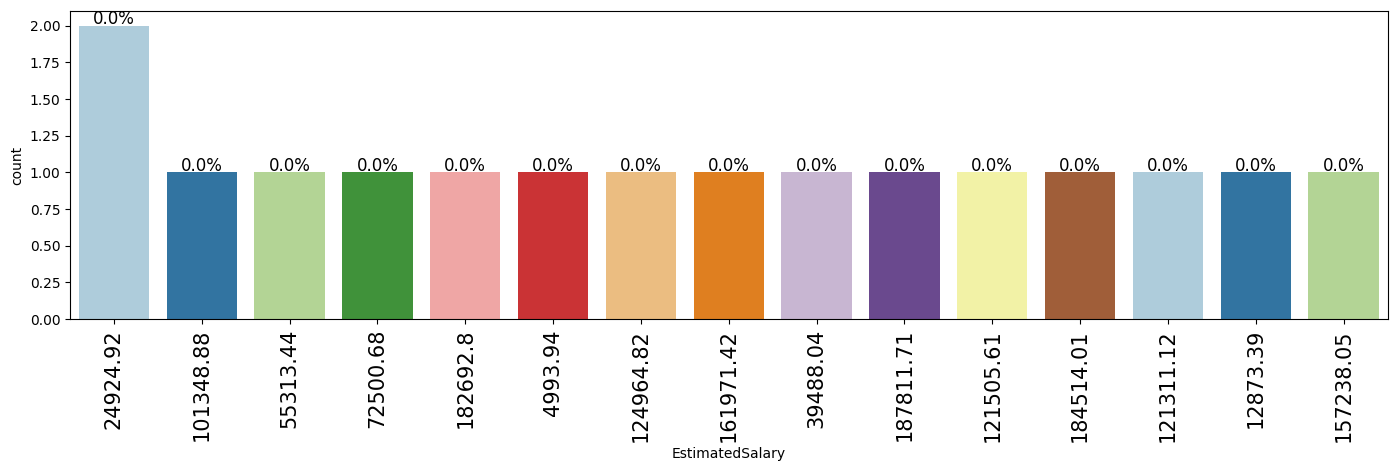

In [40]:
#visualize most common EstSalaries Distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title +" (15 most common)")
figNo+=1
j+=1

#Plot barplot of feature EstimatedSalary
labeled_barplot(datav_df, "EstimatedSalary", perc=True, n=15)

We will revisit EstimatedSalary in the bivariate analysis but notice that customer's estimated salary is uniform.

###**Exited**

This feature is the target, and indicates if a customer churned or not. 1 is Churn, 0 is No churn.

<IPython.core.display.Javascript object>

Fig 16 - Exited


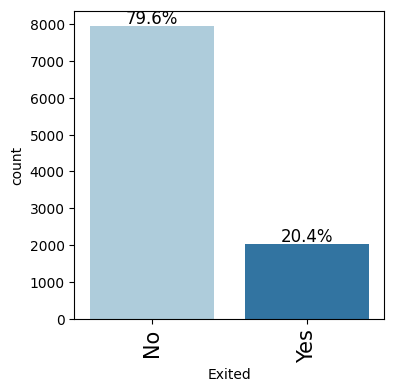

In [41]:
#visualize the Exited distribution

Title = cat_col[j]
print("Fig "+str(figNo)+" - "+ Title)
figNo+=1
j+=1

#Plot barplot of feature Exited
labeled_barplot(datav_df, "Exited", perc=True, n=None)

80% of customers did not churn. 20% of customers churned.

So the dataset is imbalanced.

## **BiVariate Analysis**

<IPython.core.display.Javascript object>

Fig 17 - Pairplot


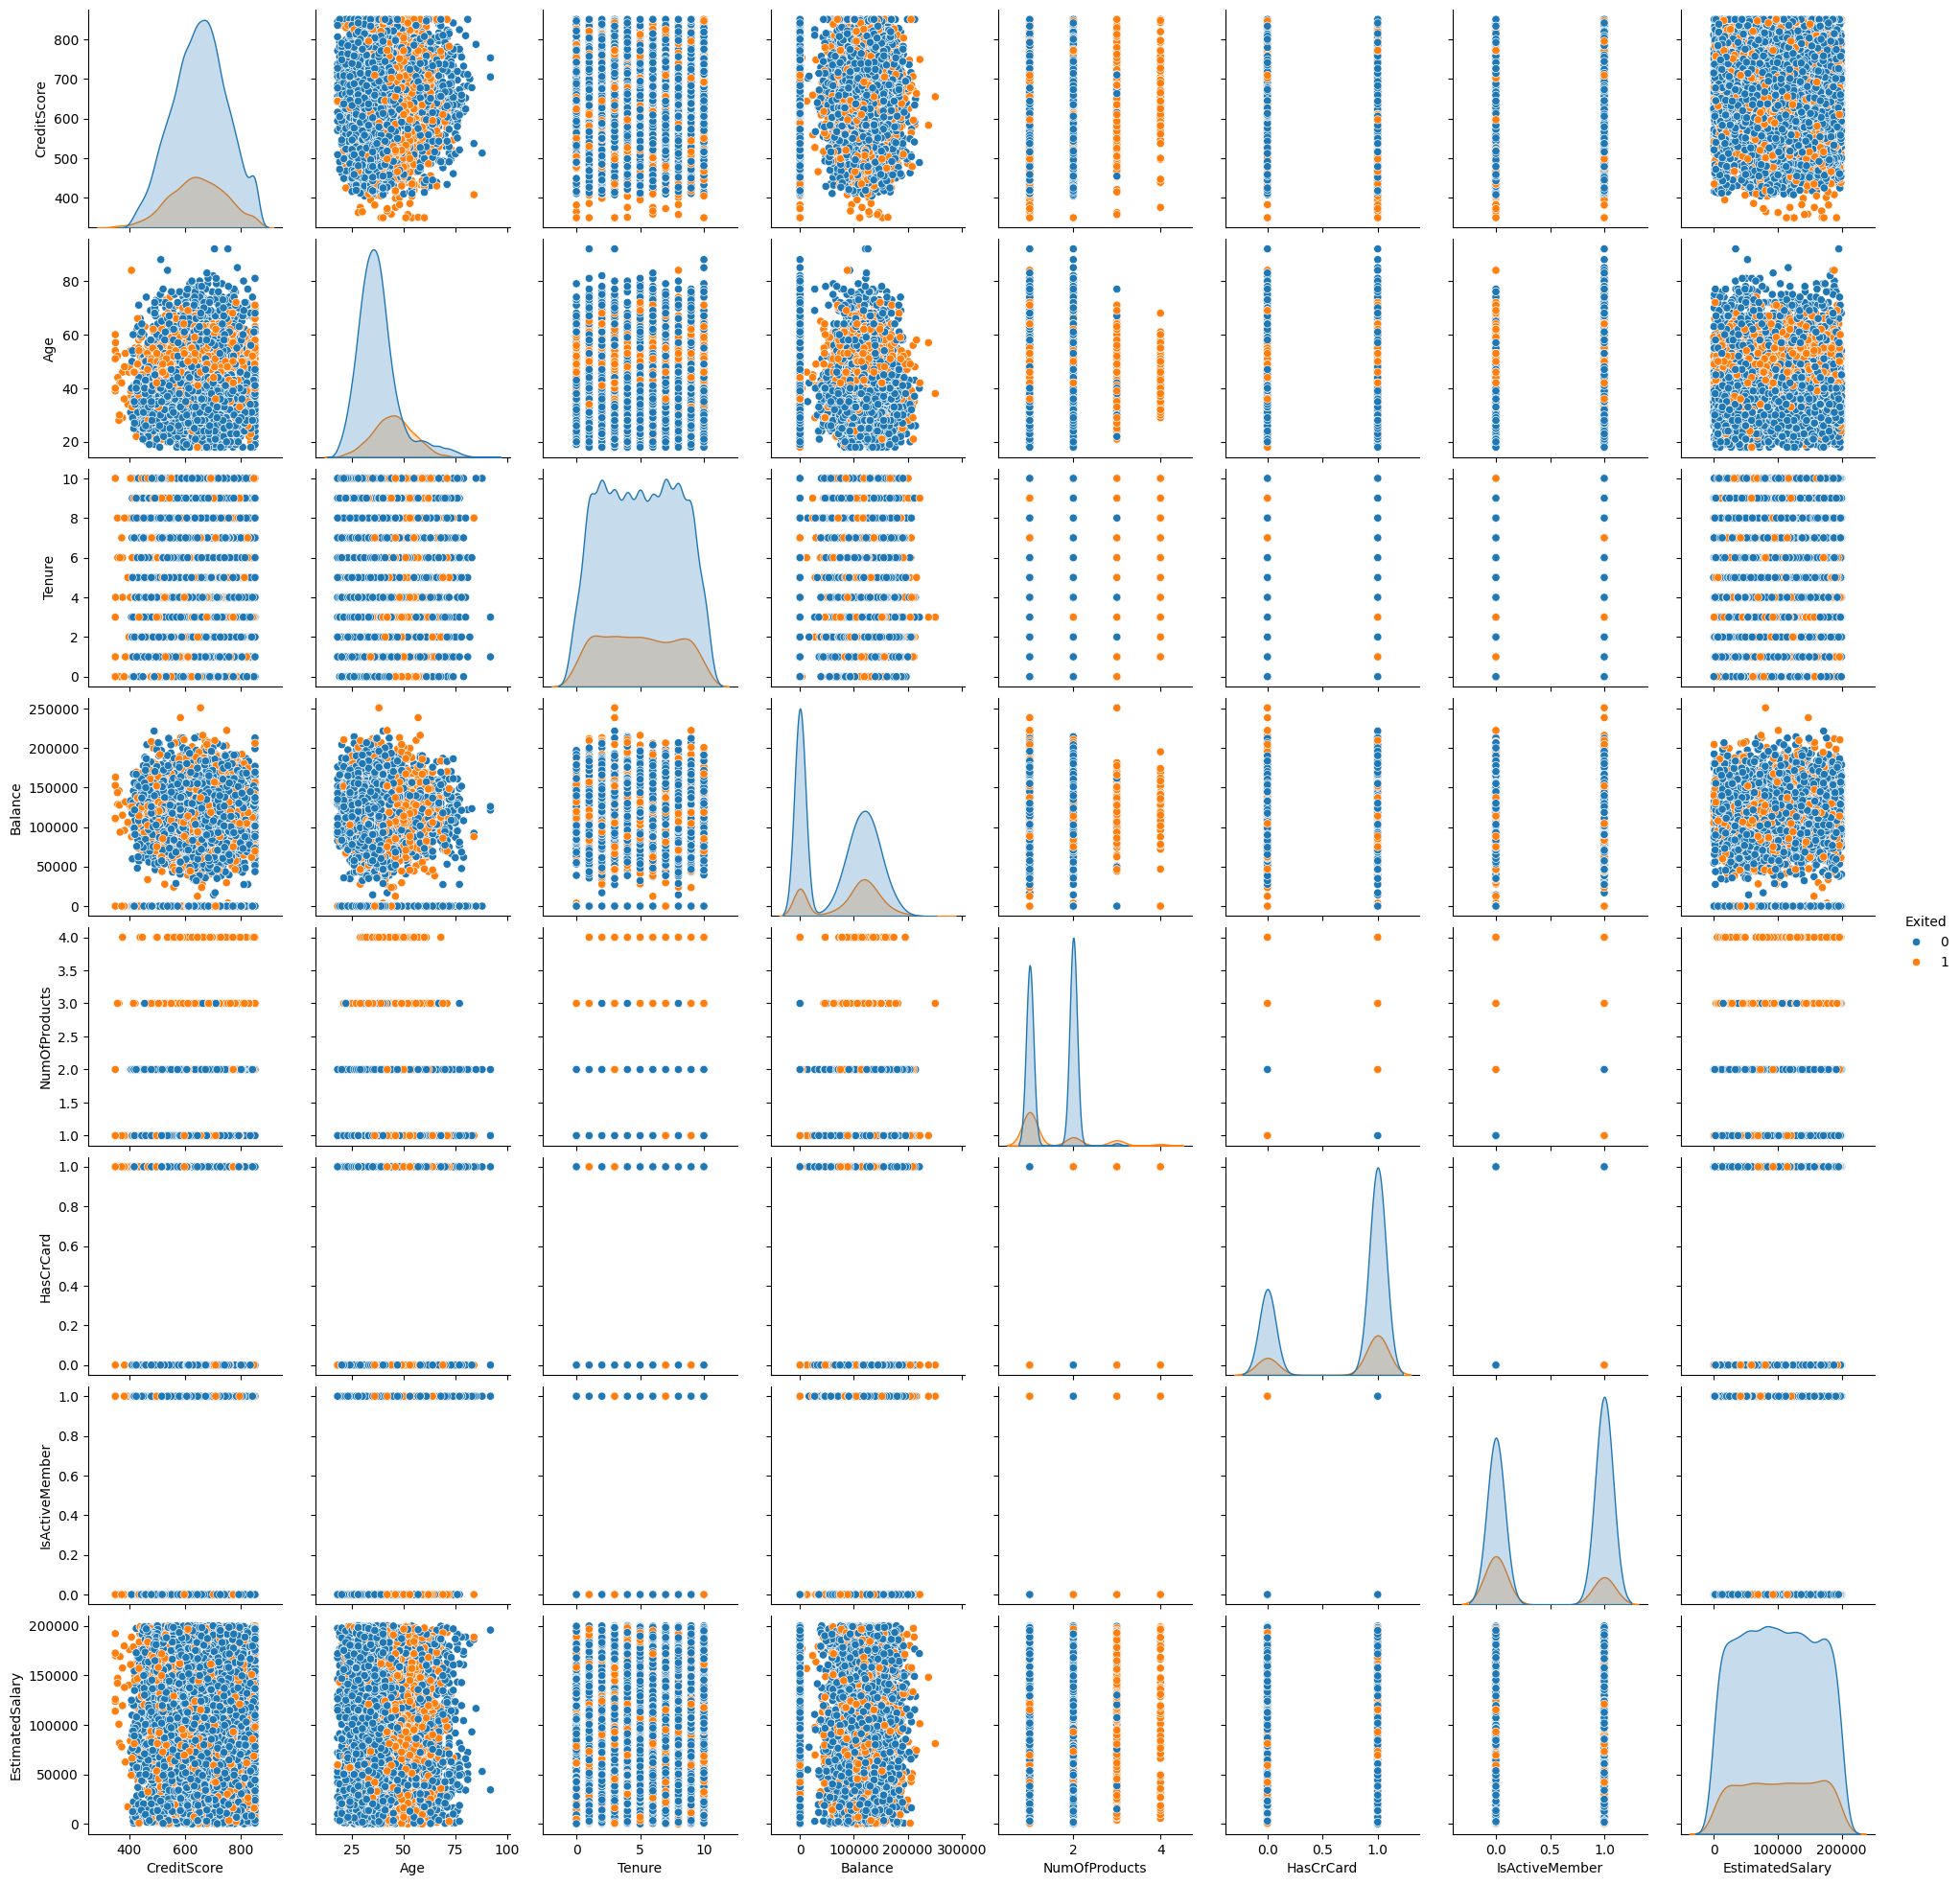

In [42]:
#visualize pair plots
#lets use dataw_df because we converted all features to numerical

print("Fig "+str(figNo)+" - "+ "Pairplot")
figNo+=1

sns.pairplot(dataw_df, diag_kind="kde",kind="scatter", hue="Exited", dropna=True)
plt.show()

Notice the diagonals Kernel Density Estimation plots.

- **CreditScore** for churn/no churn have a similar distribution.
- **Age** shows that younger customers churn less than older customers.
- **Tenure** shows similar churn/no churn distribution.
- **Balance** shows that smaller balances churn less than larger balances.
- **NumOfProducts** shows that less products churn more than more products.
- **HasCrCard** shows similar distributions for churn/no churn.
- **IsActiveMember** shows that Active members churn less than non active members.
- **EstimatedSalary** shows similar distributions for churn/no churn customers.

The other plots are difficult to interpret.

###**Exited vs Other Features**

In [43]:
#make a copy of the dataframe for further processing for visual purposes
datav2_df = datav_df.copy()

#replace NumofProducts with strings and change category
datav2_df = datav2_df.replace({'NumOfProducts':{1:'1', 2:'2', 3:'3',4:'4'}})

cols = ['NumOfProducts','Tenure']
datav2_df[cols] = datav2_df[cols].astype('category')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 18 - Exited vs Other Features


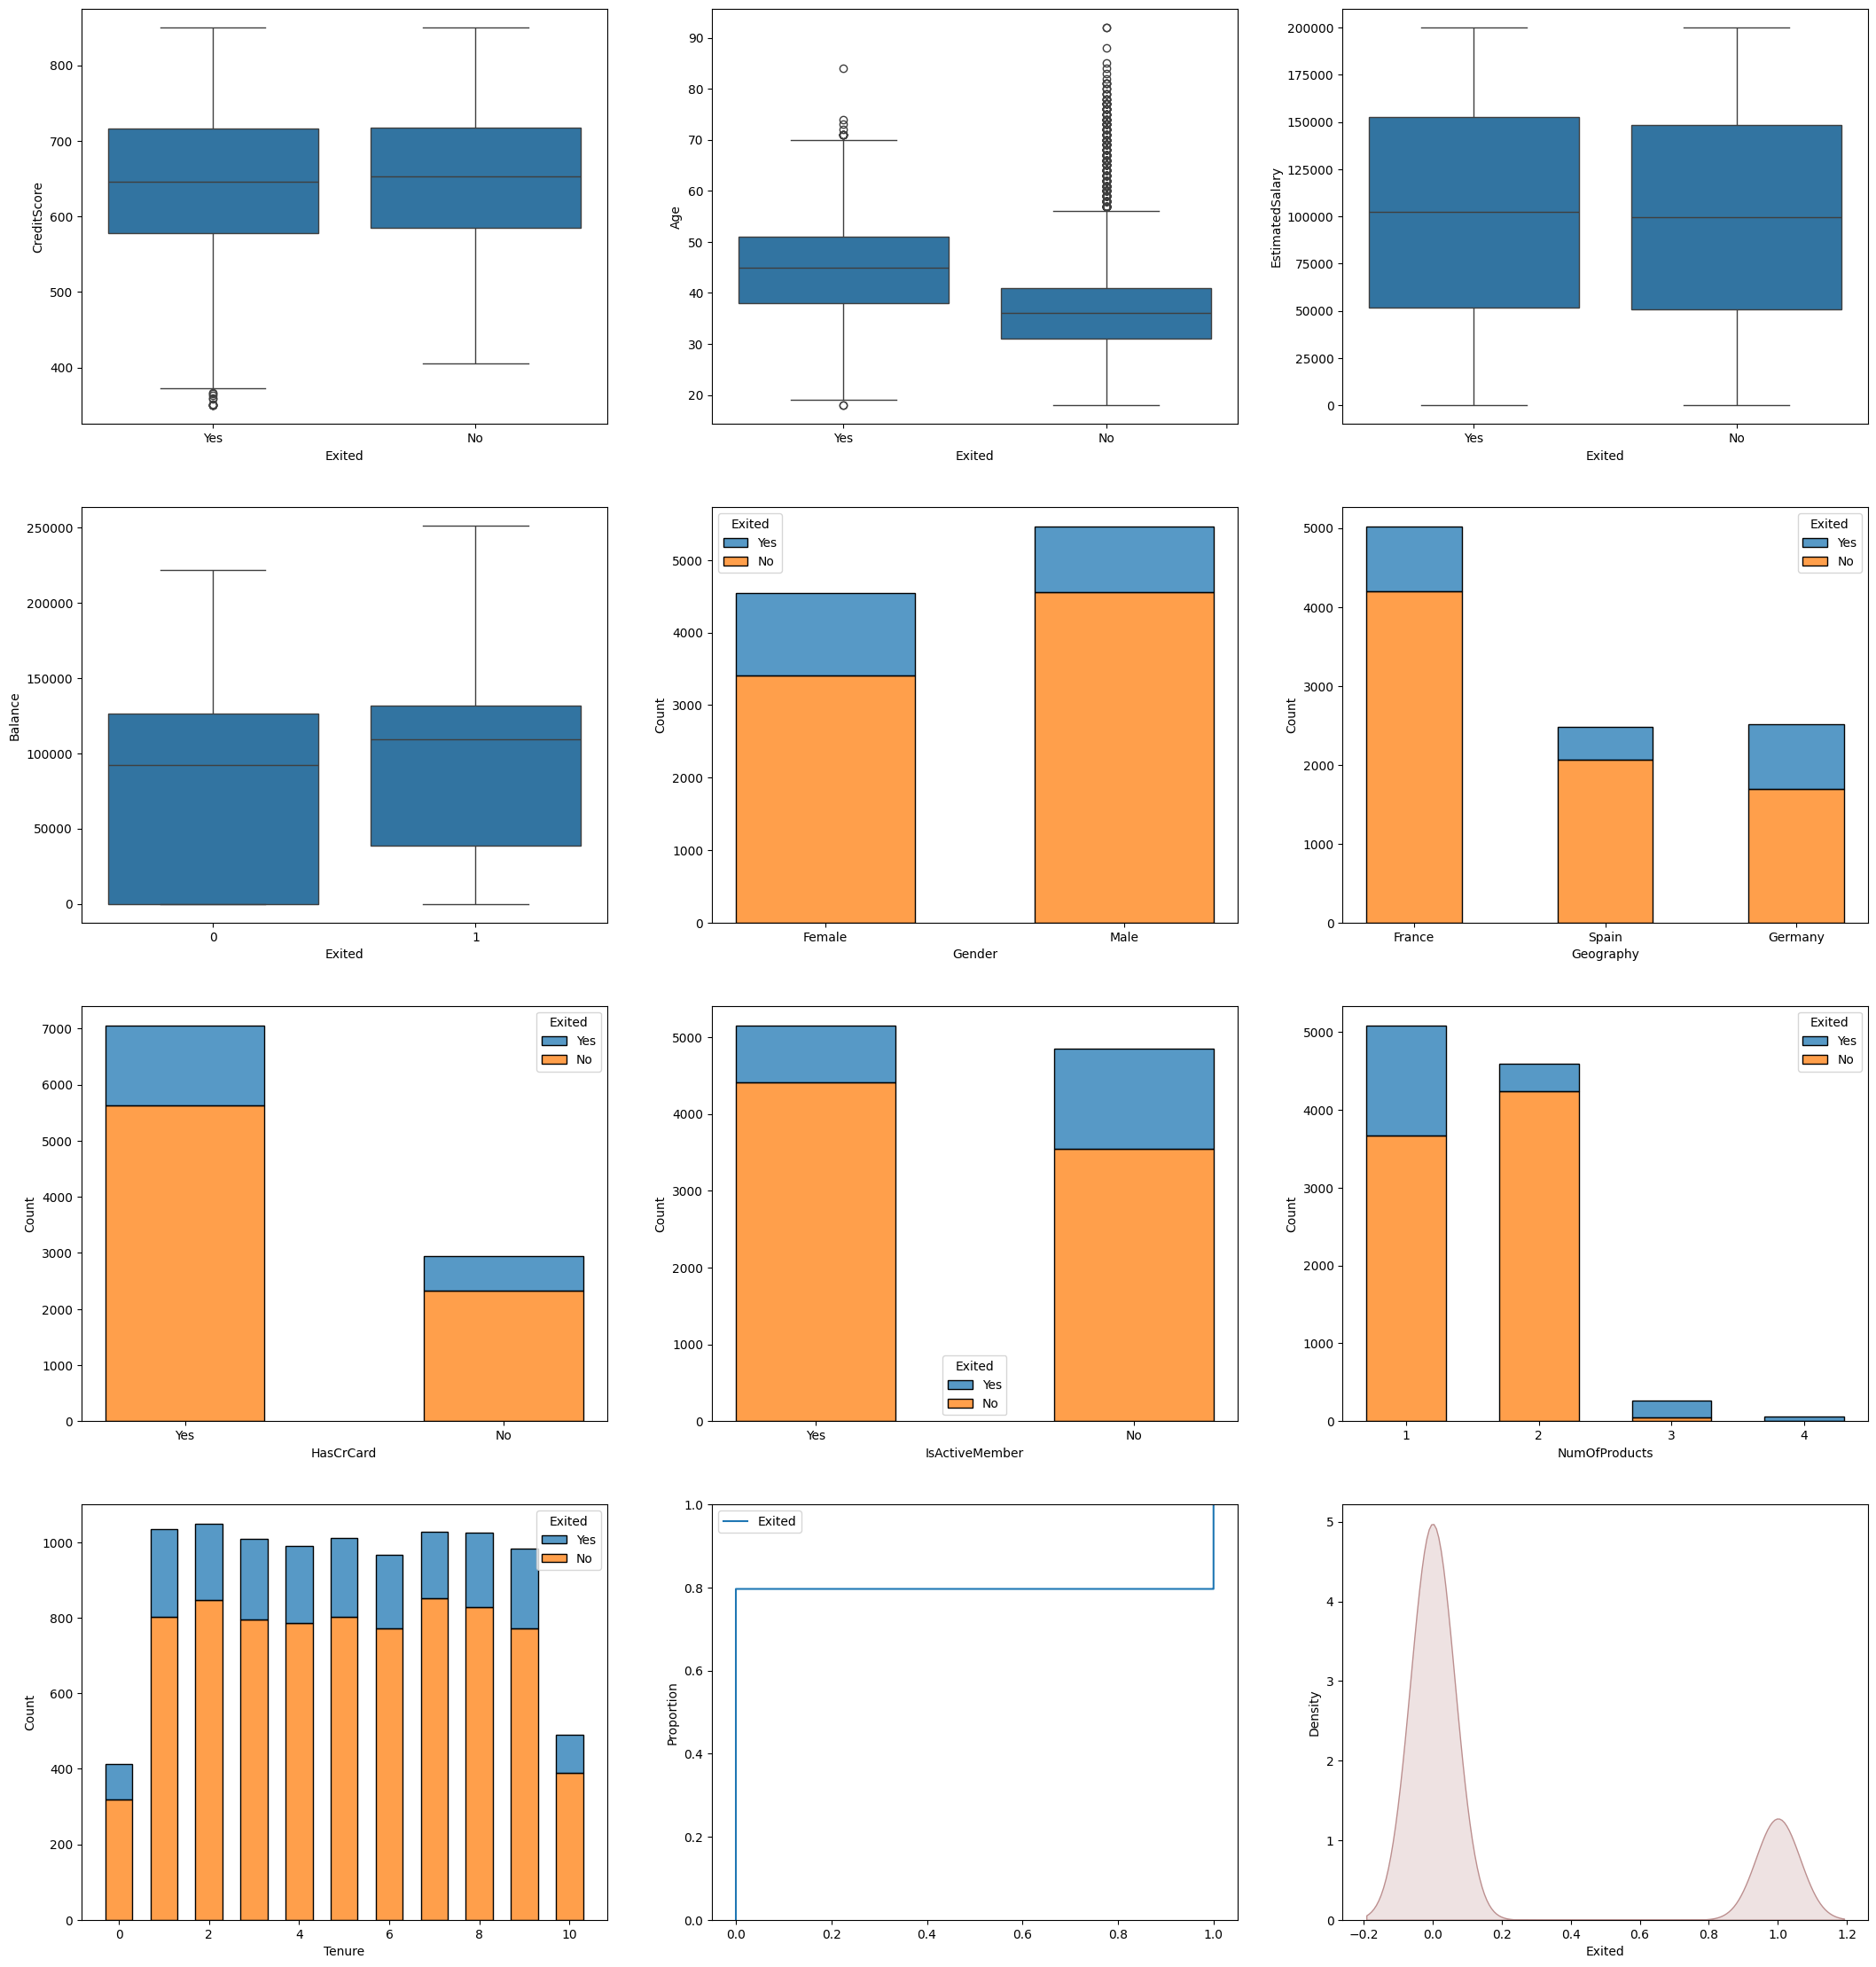

In [44]:
#Plots for Exited vs other features
print("Fig "+str(figNo)+" - "+ "Exited vs Other Features")
figNo+=1

fig, axes = plt.subplots(4, 3, figsize=(26,28))

sns.boxplot(x="Exited", y = "CreditScore", data=datav_df, orient="vertical", ax=axes[0,0])
sns.boxplot(x="Exited", y = "Age", data=datav_df, orient="vertical", ax=axes[0,1])
sns.boxplot(x="Exited", y = "EstimatedSalary", data=datav_df, orient="vertical", ax=axes[0,2])

sns.boxplot(x="Exited", y = "Balance", data=data, orient="vertical", ax=axes[1,0])
sns.histplot(data=datav_df, x="Gender", hue="Exited", multiple="stack", shrink=.6, ax=axes[1,1])
sns.histplot(data=datav_df, x="Geography", hue="Exited", multiple="stack", shrink=.5, ax=axes[1,2])

sns.histplot(data=datav_df, x="HasCrCard", hue="Exited", multiple="stack", shrink=.5, ax=axes[2,0])
sns.histplot(data=datav_df, x="IsActiveMember", hue="Exited", multiple="stack", shrink=.5, ax=axes[2,1])
sns.histplot(data=datav2_df, x="NumOfProducts", hue="Exited", multiple="stack", shrink=.6, ax=axes[2,2])

sns.histplot(data=datav2_df, x="Tenure", hue="Exited", multiple="stack", shrink=.6, ax=axes[3,0])
sns.ecdfplot(data=dataw_df.filter(like='Exited', axis="columns"), ax=axes[3,1])
sns.kdeplot(data=dataw_df, x="Exited", fill=True, color="RosyBrown", ax=axes[3,2])

plt.show()

We have seen somehow these plots earlier during our pairplot analysis, but now they are a bit more clear.

**CreditScore**. Similar CreditScore distributions for churn and no-churn customers, except from outliers in the churn class. Notice that Customers with lower creditScores tend to churn more. Also, customers that do not churn don't have creditscores below 400.

**Age** Most older customers in the group above 60 do not churn. Customers between 30-40 tend not to churn. Customers between 40 and 50 churn.

**EstimatedSalary** doesn't seem to influence churn.

**Balance** Customers with lower balance tend to churn more.

**Gender** Female customers that churn have a larger proportion within their class than males that churn.

**Geography** Spanish customers churn less (in proportion to their class) than French customers. German customers churn the most not only in proportion to their class but overall.

**HaveCrCard** Customers with credit cards or without credit cards tend to churn equally in proportion to their class when compared to customers those that don't have a credit card. However, overall, customers with credit card churn the most.

**IsActiveMember** Customers that are active churn less overall and churn less in proportion to their class when compared to customers that are not active.

**NumOfProducts** Customers with 1 product churn the most overall. Customers with 3 or 4 products churn the most in proportion to their classes. Customers with 2 products churn the least.

**Tenure** Churn is similar in proportion to their respective classes for all tenures. However, notice the low number of customers in tenure=10 and tenure=0.


###**Geography vs Others**

In [45]:
datav4_df = datav_df.copy()

datav4_df = datav4_df.replace({'Geography':{'France':0, 'Spain':1, 'Germany':2}})
cols = ['Geography']
datav4_df[cols] = datav4_df[cols].astype('int32')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fig 19 - Geography vs Other Features


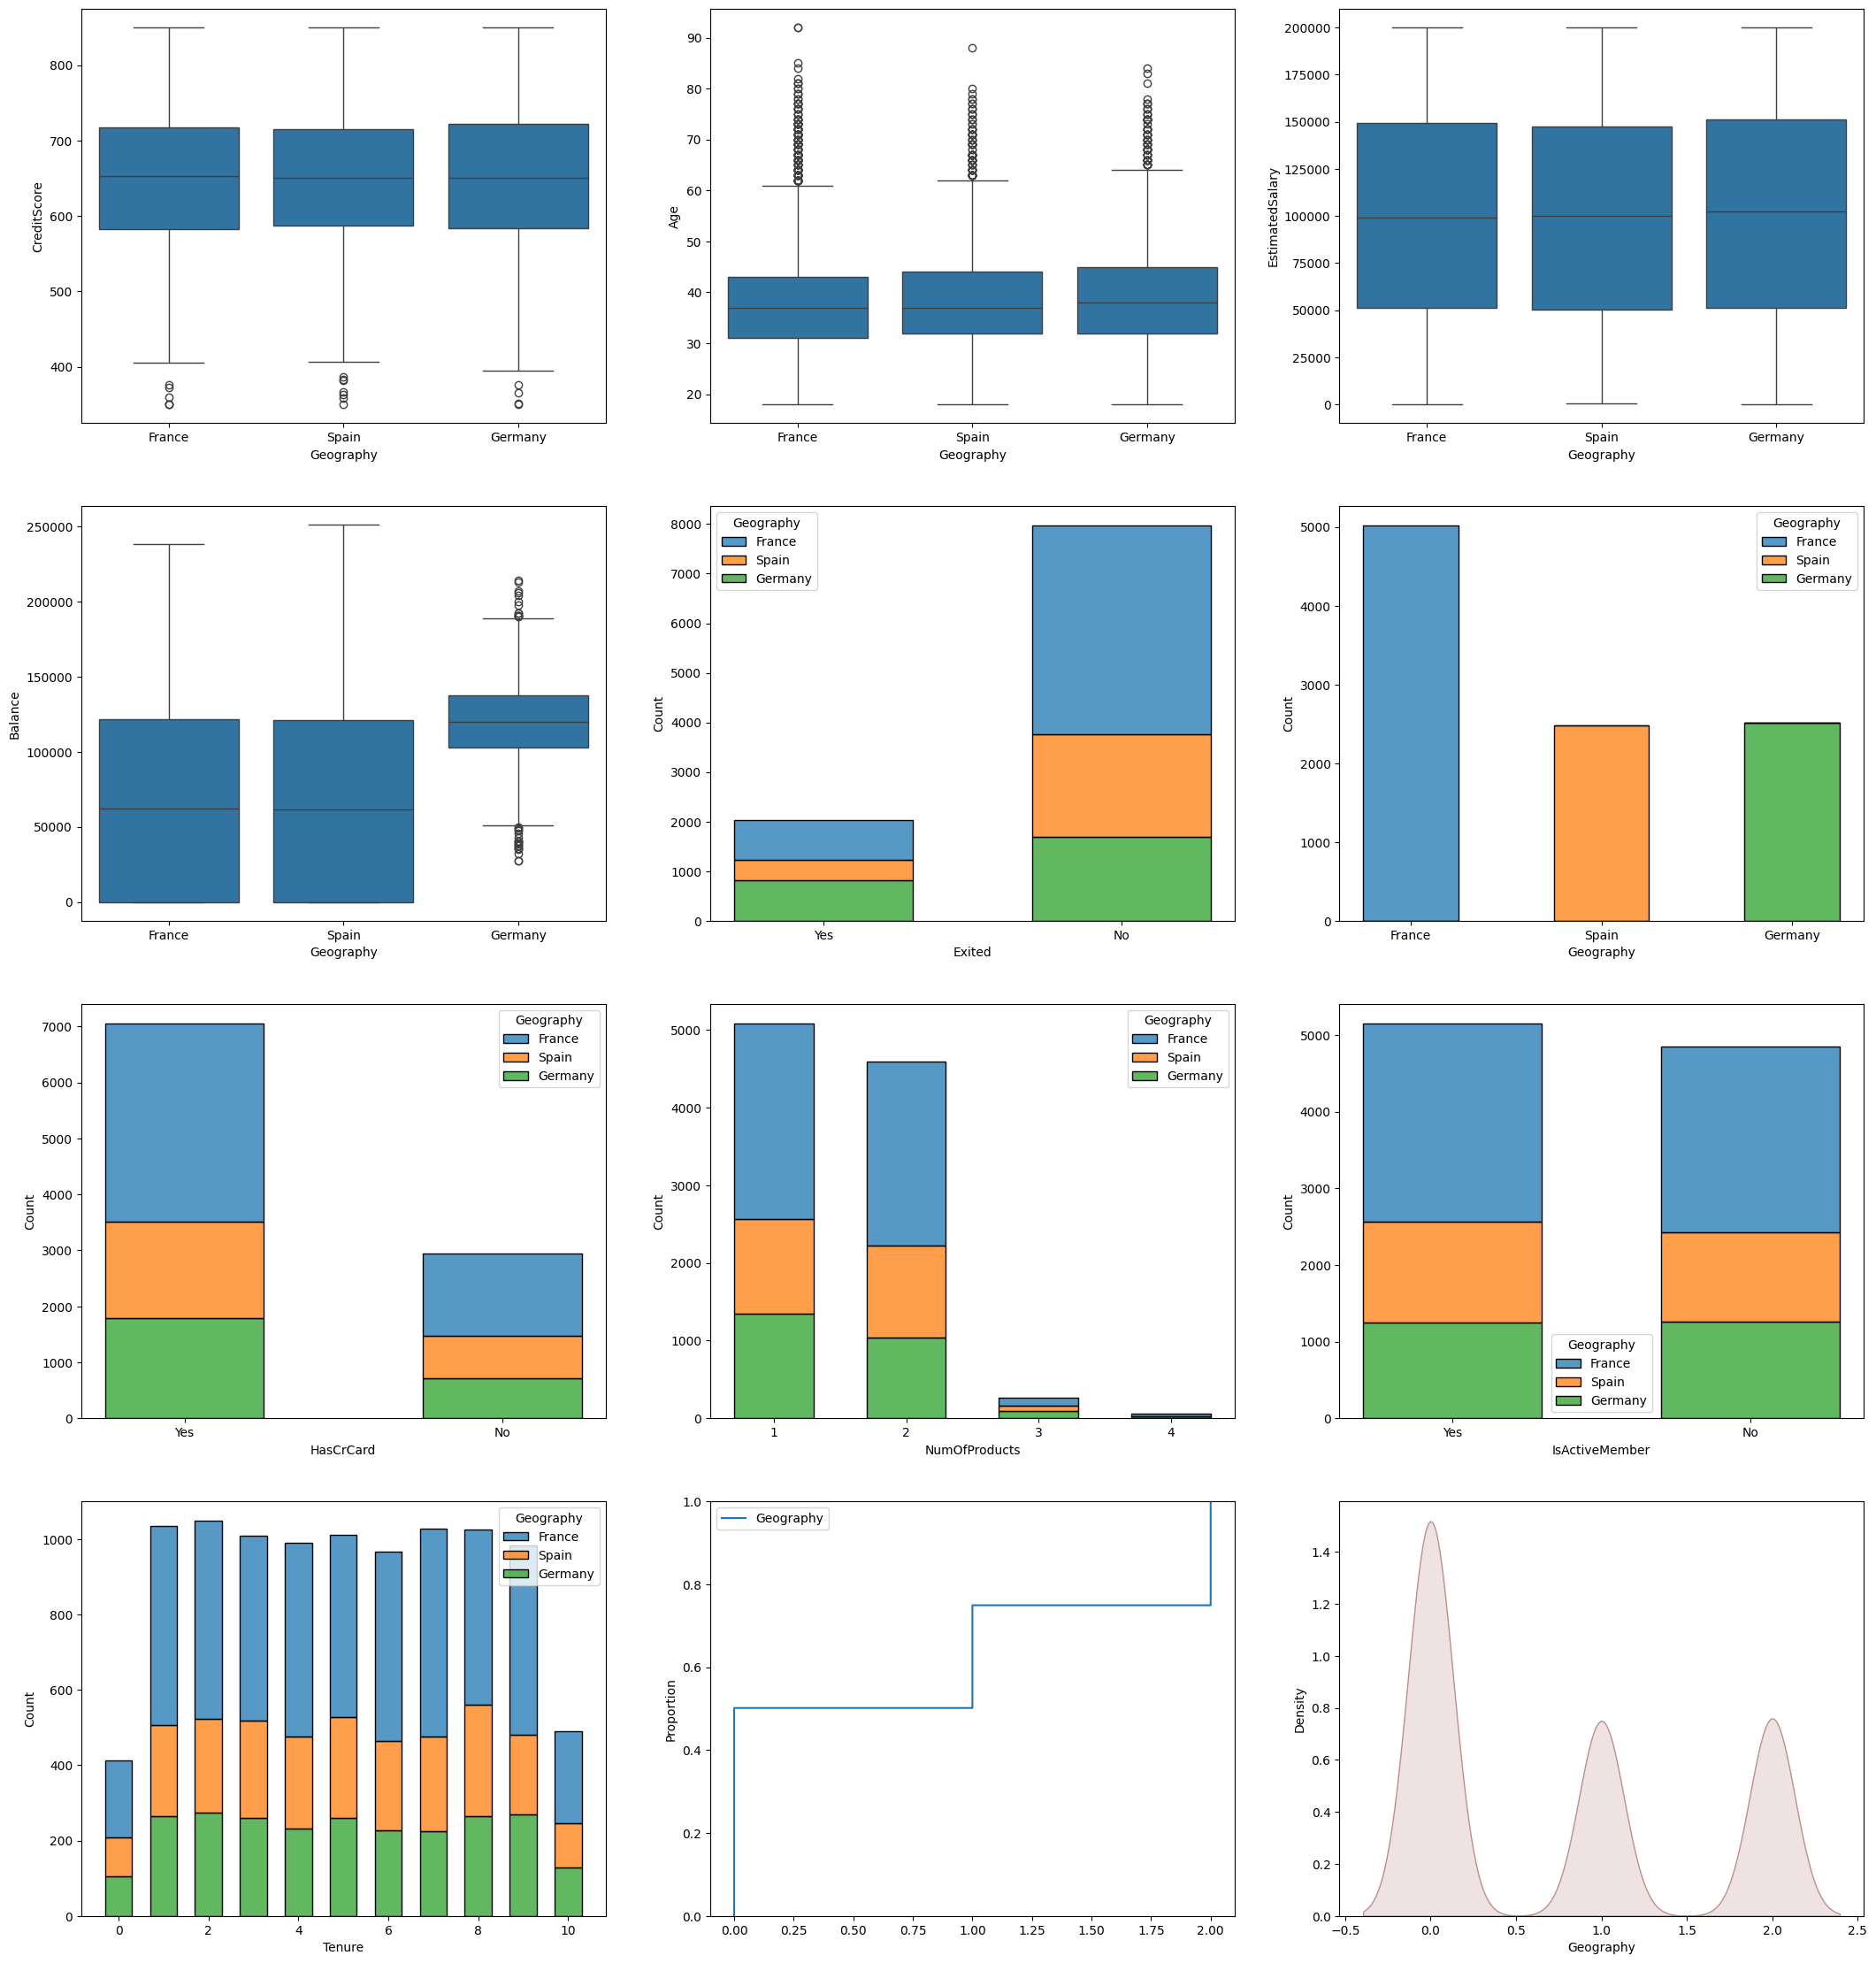

In [46]:

#Plots for IsActiveMember vs other features
print("Fig "+str(figNo)+" - "+ "Geography vs Other Features")
figNo+=1

fig, axes = plt.subplots(4, 3, figsize=(26,28))

sns.boxplot(x="Geography", y = "CreditScore", data=datav_df, orient="vertical", ax=axes[0,0])
sns.boxplot(x="Geography", y = "Age", data=datav_df, orient="vertical", ax=axes[0,1])
sns.boxplot(x="Geography", y = "EstimatedSalary", data=datav_df, orient="vertical", ax=axes[0,2])

sns.boxplot(x="Geography", y = "Balance", data=data, orient="vertical", ax=axes[1,0])
sns.histplot(data=datav2_df, x="Exited", hue="Geography", multiple="stack", shrink=.6, ax=axes[1,1])
sns.histplot(data=datav_df, x="Geography", hue="Geography", multiple="stack", shrink=.5, ax=axes[1,2])

sns.histplot(data=datav_df, x="HasCrCard", hue="Geography", multiple="stack", shrink=.5, ax=axes[2,0])
sns.histplot(data=datav2_df, x="NumOfProducts", hue="Geography", multiple="stack", shrink=.6, ax=axes[2,1])
sns.histplot(data=datav2_df, x="IsActiveMember", hue="Geography", multiple="stack", shrink=.6, ax=axes[2,2])

sns.histplot(data=datav2_df, x="Tenure", hue="Geography", multiple="stack", shrink=.6, ax=axes[3,0])
sns.ecdfplot(data=datav4_df.filter(like='Geography', axis="columns"), ax=axes[3,1])
sns.kdeplot(data=datav4_df, x="Geography", fill=True, color="RosyBrown", ax=axes[3,2])

plt.show()

**CreditScore** Customers in France, Spain, and Germany have similar creditScores distribution.

**Age** Customers in France, Spain, and Germany have similar age distributions. Notice that all classes have outliers.

**EstimatedSalary** the three countries have similar salary distributions, with Germany being slightly higher than France. Spain is slightly lower than both Germany and France.

**Balance** Germany has the highest balance. France and Spain have similar balances. Notice that Q3 of both France and Spain are Q2 of Germany.

**Exited** Proportionally to their classes, Germany churns the most, followed by Spain.

**Geography** France is the largest market for the bank. Spain and Germany are about the same.

**HasCrCard** Similar distributions for all countries according to their proportions within their class..

**NumOfProducts** Similar distributions for all countries according to their proportions within their class..

**IsActiveMember** Similar distributions for all countries according to their proportions within their class.

**Tenure** Distributions are similar for all countries.


###**NumOfProducts vs Others**

<IPython.core.display.Javascript object>

Fig 20 - NumOfProducts vs Other Features


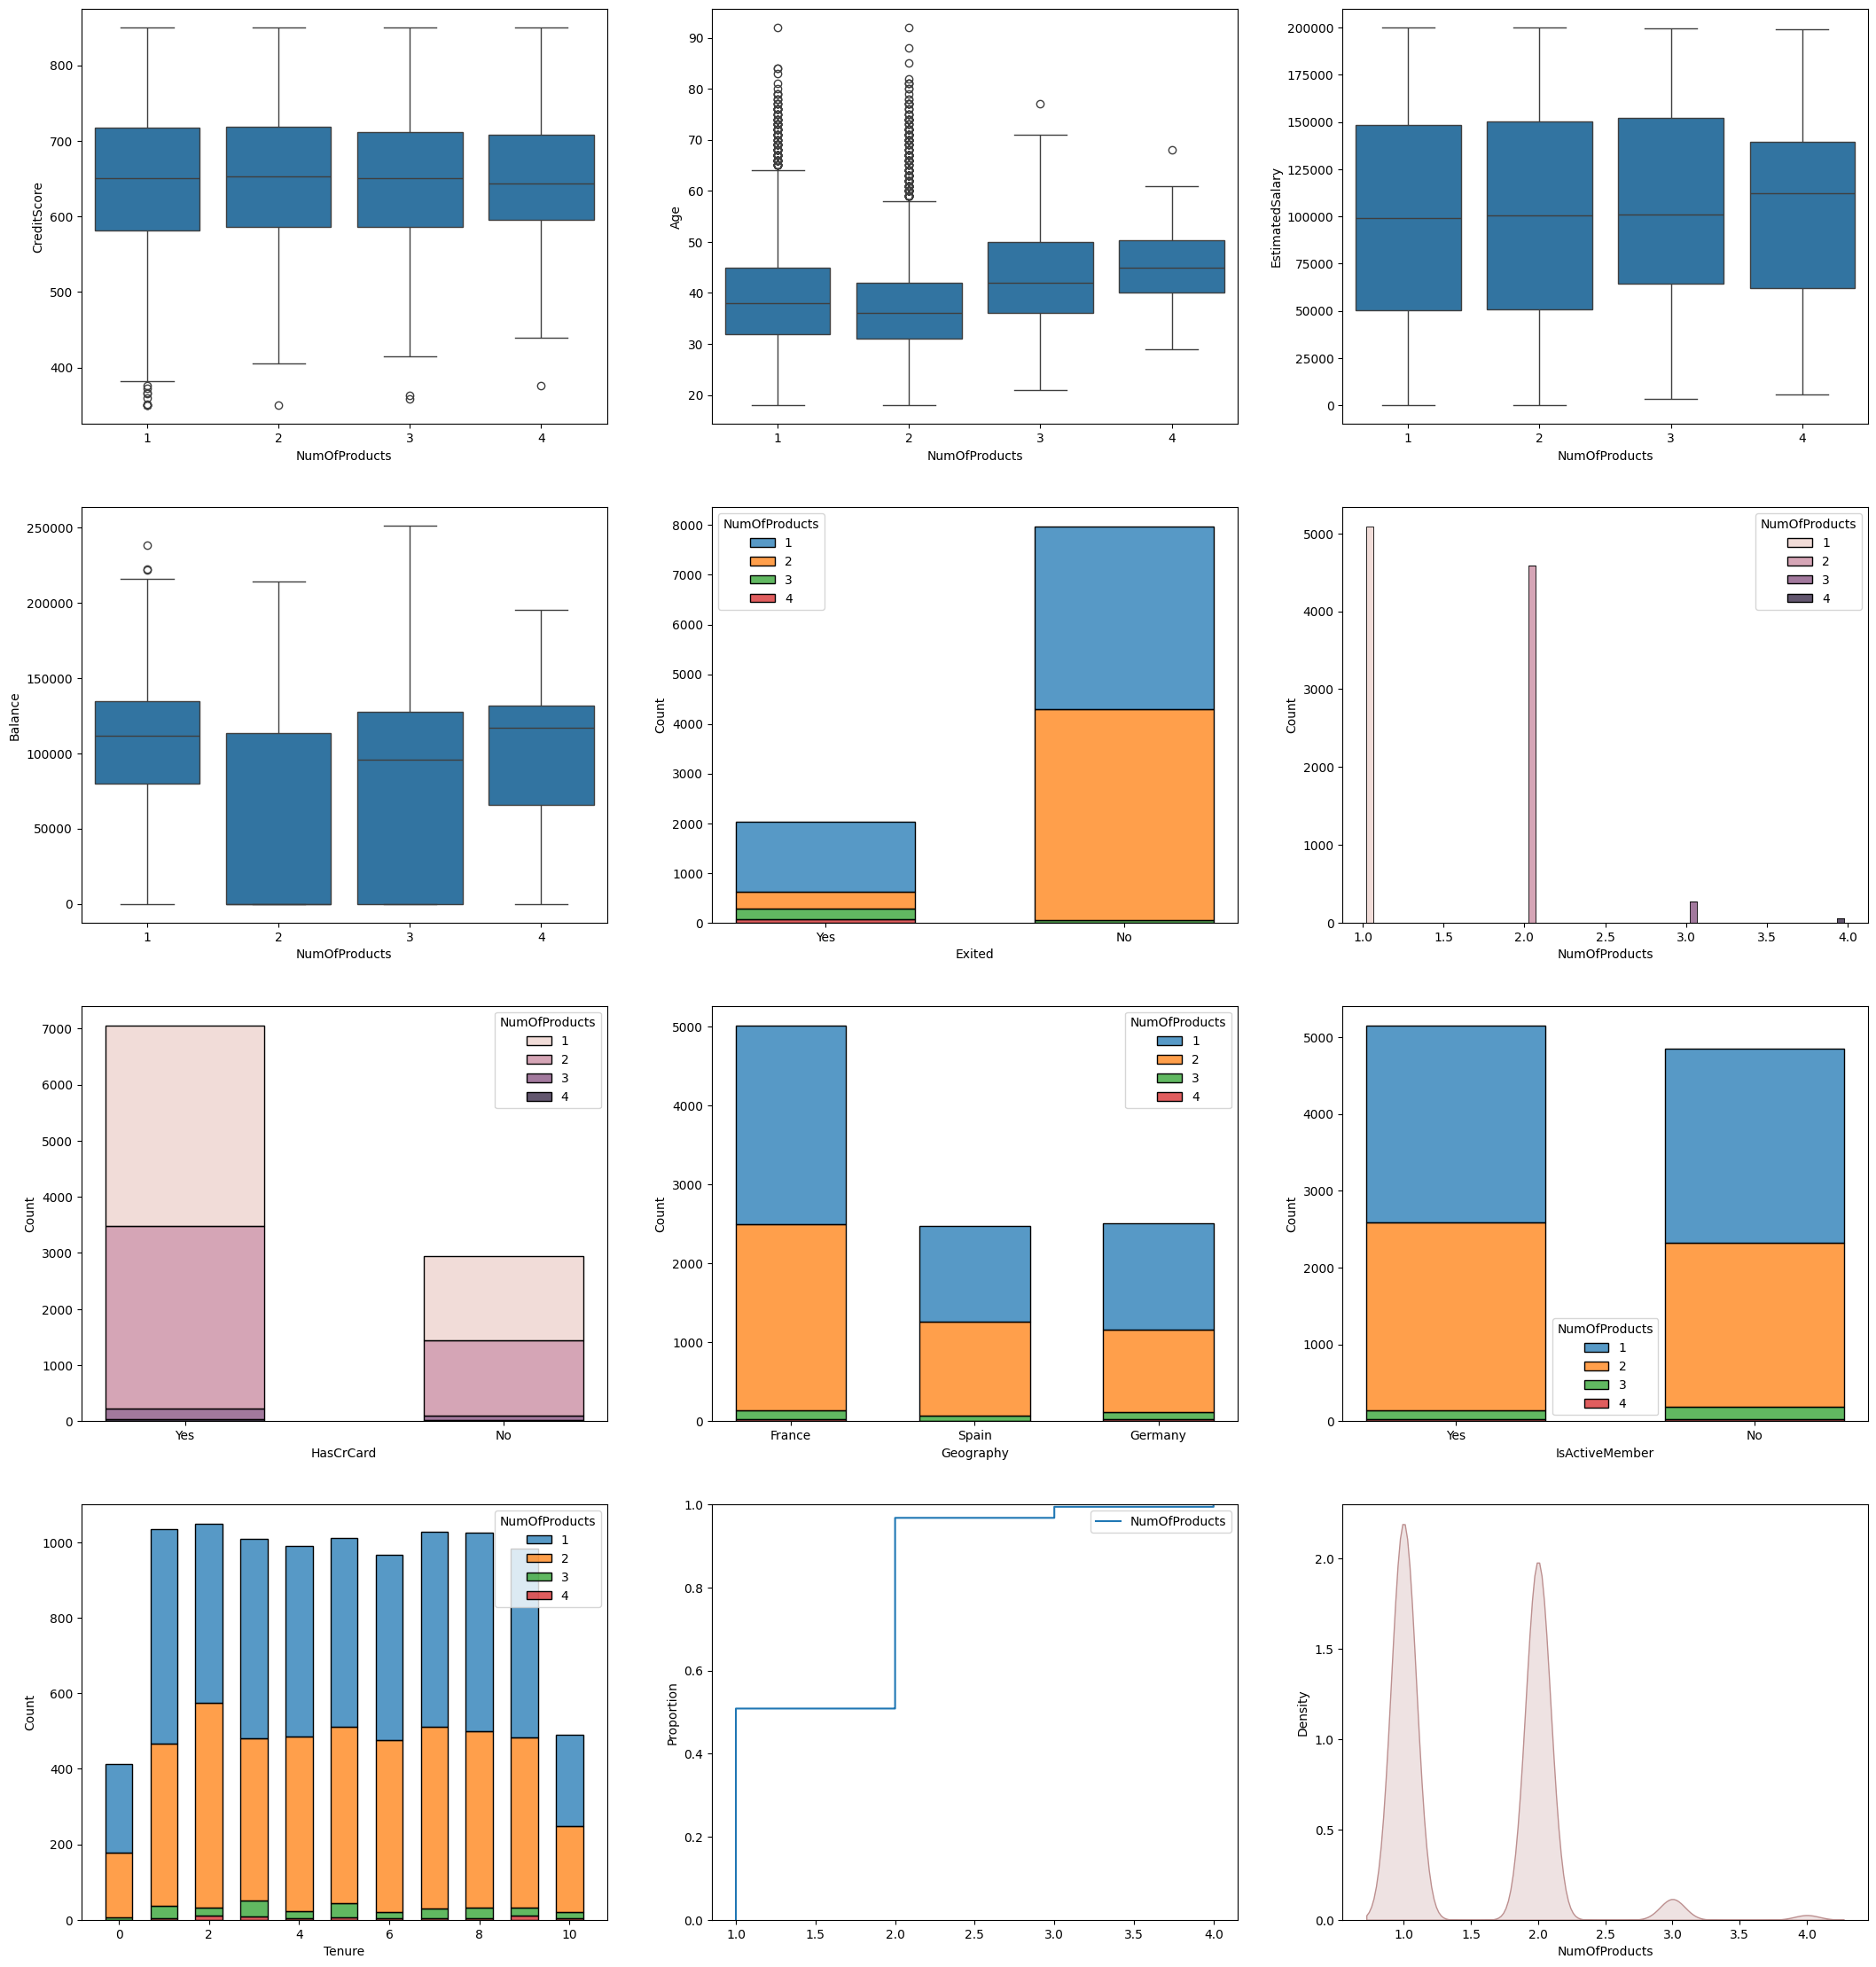

In [47]:

#Plots for NumOfProducts vs other features
print("Fig "+str(figNo)+" - "+ "NumOfProducts vs Other Features")
figNo+=1

fig, axes = plt.subplots(4, 3, figsize=(26,28))

sns.boxplot(x="NumOfProducts", y = "CreditScore", data=datav_df, orient="vertical", ax=axes[0,0])
sns.boxplot(x="NumOfProducts", y = "Age", data=datav_df, orient="vertical", ax=axes[0,1])
sns.boxplot(x="NumOfProducts", y = "EstimatedSalary", data=datav_df, orient="vertical", ax=axes[0,2])

sns.boxplot(x="NumOfProducts", y = "Balance", data=data, orient="vertical", ax=axes[1,0])
sns.histplot(data=datav2_df, x="Exited", hue="NumOfProducts", multiple="stack", shrink=.6, ax=axes[1,1])
sns.histplot(data=datav_df, x="NumOfProducts", hue="NumOfProducts", multiple="stack", shrink=.5, ax=axes[1,2])

sns.histplot(data=datav_df, x="HasCrCard", hue="NumOfProducts", multiple="stack", shrink=.5, ax=axes[2,0])
sns.histplot(data=datav2_df, x="Geography", hue="NumOfProducts", multiple="stack", shrink=.6, ax=axes[2,1])
sns.histplot(data=datav2_df, x="IsActiveMember", hue="NumOfProducts", multiple="stack", shrink=.6, ax=axes[2,2])

sns.histplot(data=datav2_df, x="Tenure", hue="NumOfProducts", multiple="stack", shrink=.6, ax=axes[3,0])
sns.ecdfplot(data=dataw_df.filter(like='NumOfProducts', axis="columns"), ax=axes[3,1])
sns.kdeplot(data=dataw_df, x="NumOfProducts", fill=True, color="RosyBrown", ax=axes[3,2])

plt.show()

**CreditScore** All NumOfProducts have similar CreditScore median. There are outliers in call classes.

**Age** Many outliers but overall, customers with 4 products and 3 products are older than those customers with 1 and 2 products. Customers with 2 products are youngest.

**EstimatedSalary** Customers with 3 products have higher EstimatedSalary.

**Balance** Customers with 1 product have higher balances. Customers with 2 products have the lowest balance.

**Exited** Customers with 1 product churn a whole lot in proportion to the class.

**HasCrCard** similar distribution.

**Geography** similar distribution.

**IsActiveMember** similar distribution.

**Tenure** similar distribution.


###**Tenure vs Others**

<IPython.core.display.Javascript object>

Fig 21 - Tenure vs Other Features


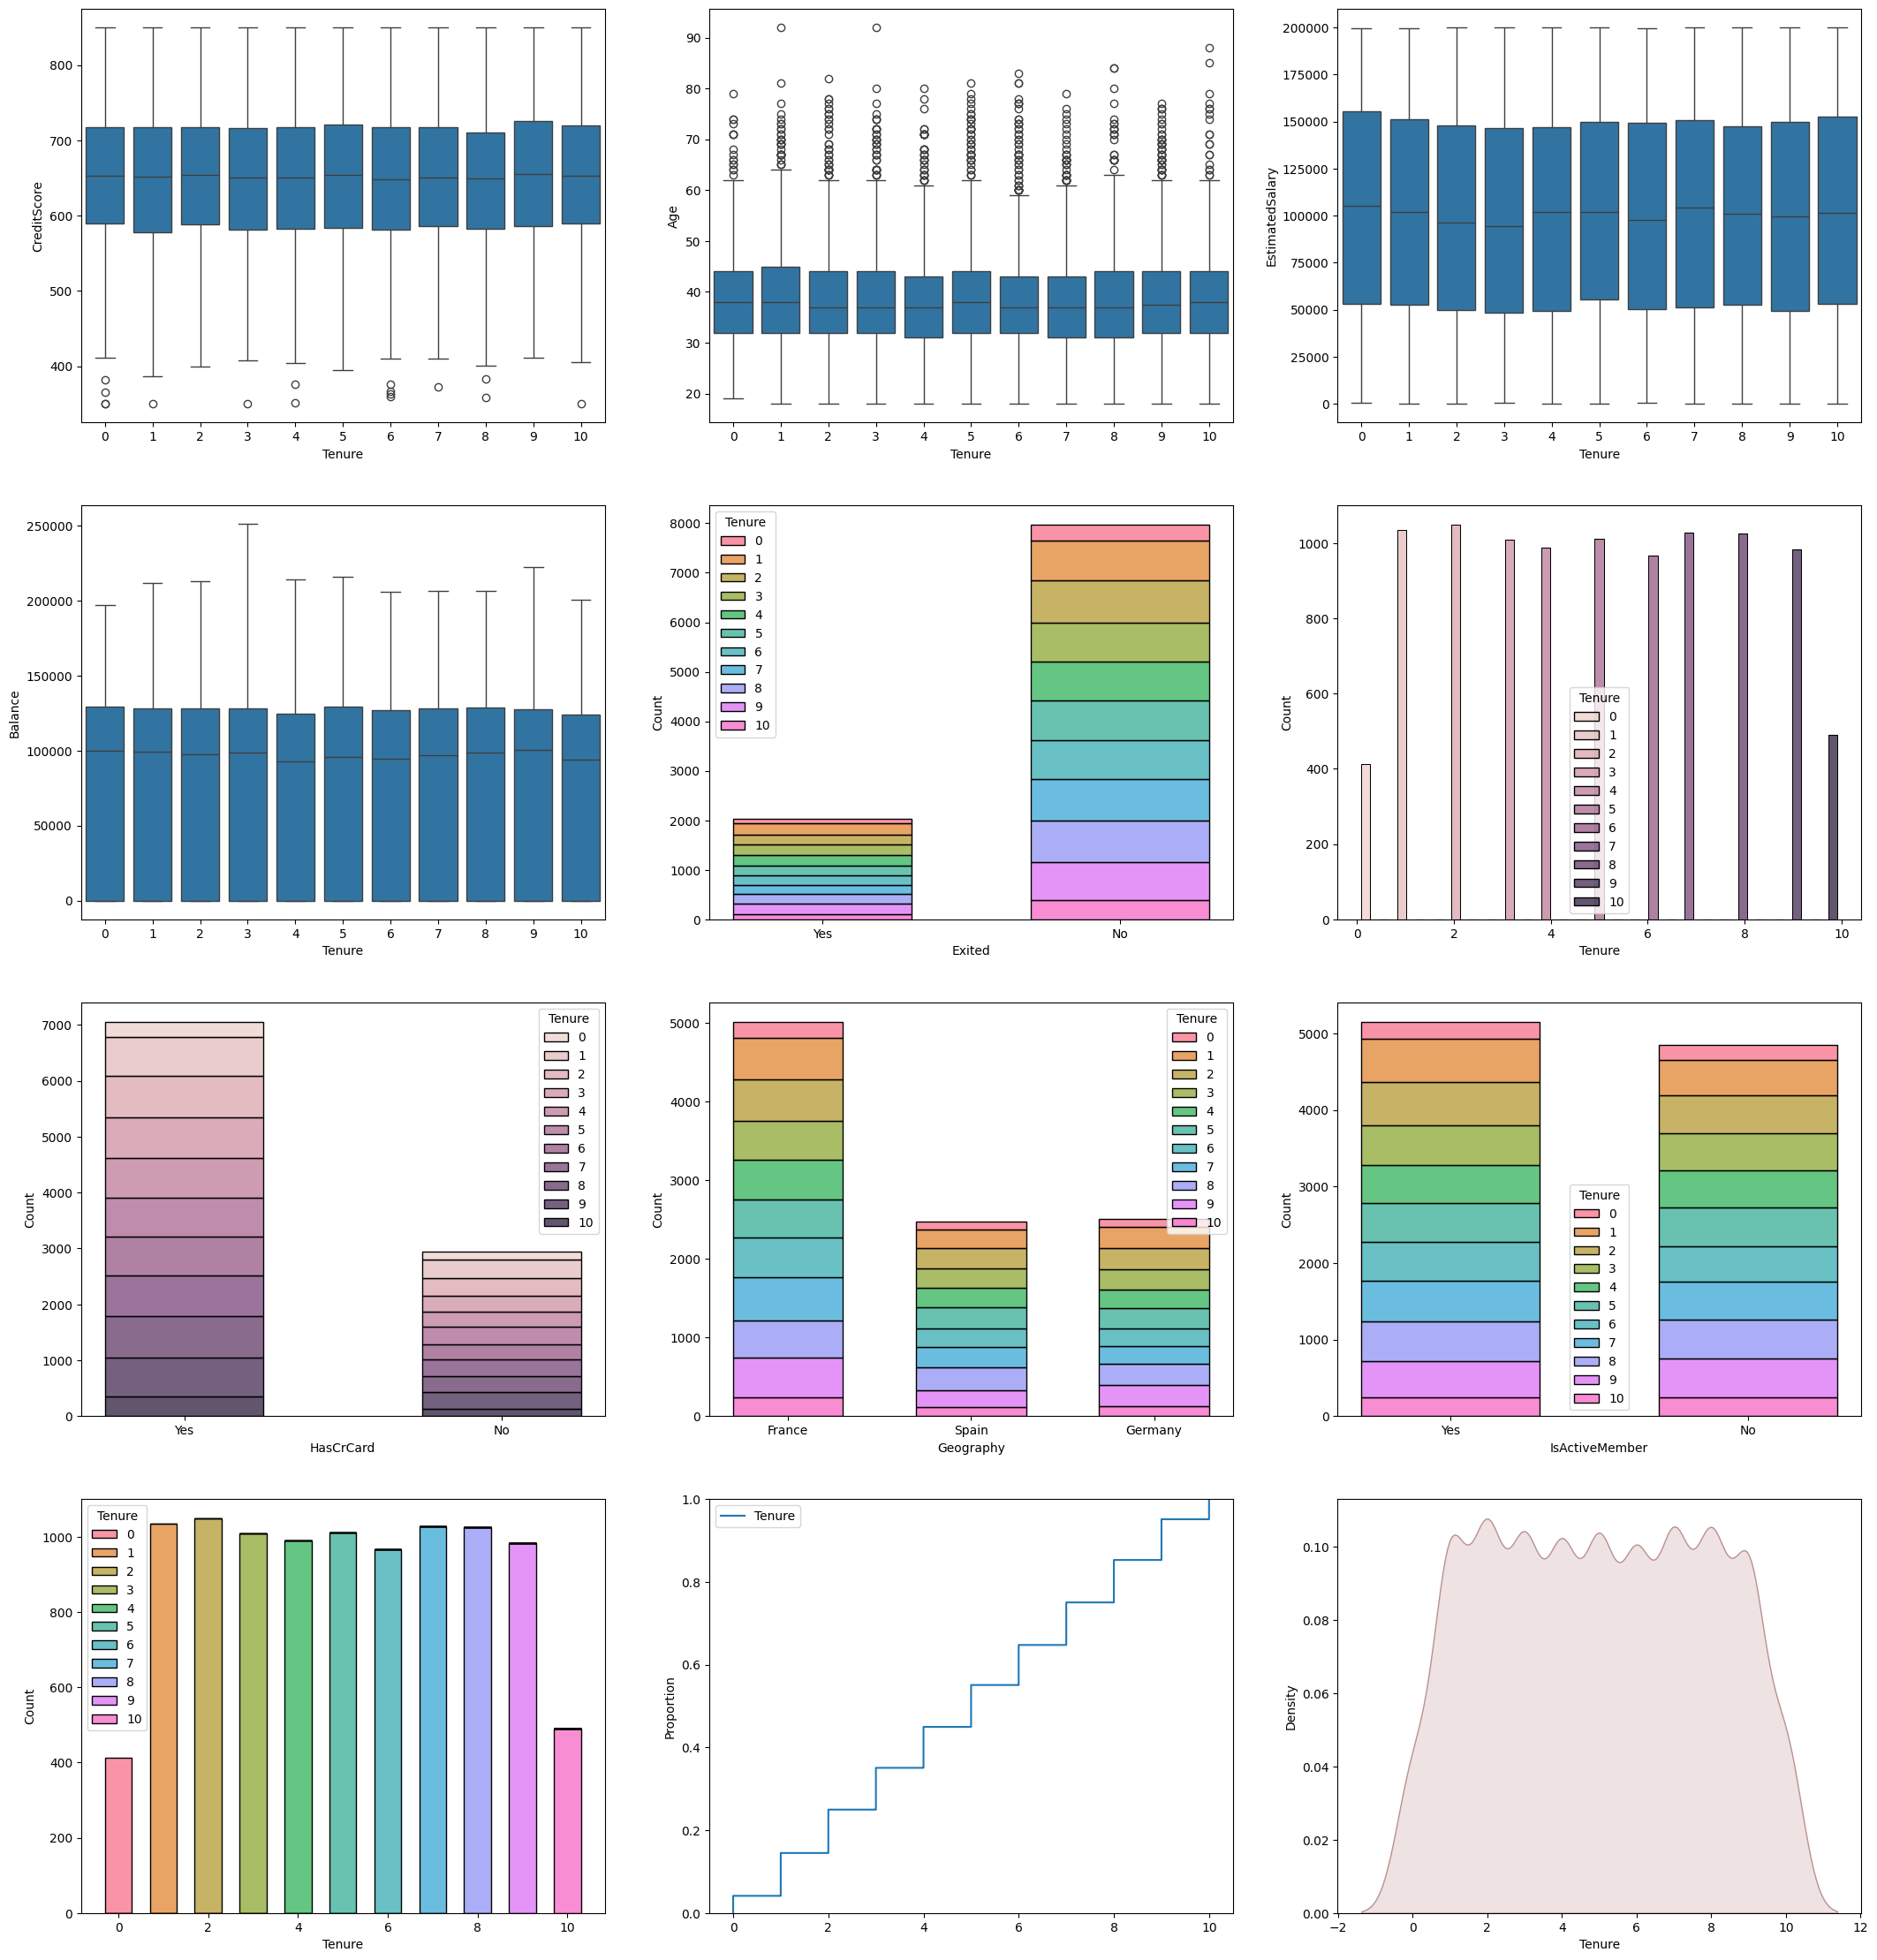

In [48]:

#Plots for Tenure vs other features
print("Fig "+str(figNo)+" - "+ "Tenure vs Other Features")
figNo+=1

fig, axes = plt.subplots(4, 3, figsize=(26,28))

sns.boxplot(x="Tenure", y = "CreditScore", data=datav_df, orient="vertical", ax=axes[0,0])
sns.boxplot(x="Tenure", y = "Age", data=datav_df, orient="vertical", ax=axes[0,1])
sns.boxplot(x="Tenure", y = "EstimatedSalary", data=datav_df, orient="vertical", ax=axes[0,2])

sns.boxplot(x="Tenure", y = "Balance", data=data, orient="vertical", ax=axes[1,0])
sns.histplot(data=datav2_df, x="Exited", hue="Tenure", multiple="stack", shrink=.6, ax=axes[1,1])
sns.histplot(data=datav_df, x="Tenure", hue="Tenure", multiple="stack", shrink=.5, ax=axes[1,2])

sns.histplot(data=datav_df, x="HasCrCard", hue="Tenure", multiple="stack", shrink=.5, ax=axes[2,0])
sns.histplot(data=datav2_df, x="Geography", hue="Tenure", multiple="stack", shrink=.6, ax=axes[2,1])
sns.histplot(data=datav2_df, x="IsActiveMember", hue="Tenure", multiple="stack", shrink=.6, ax=axes[2,2])

sns.histplot(data=datav2_df, x="Tenure", hue="Tenure", multiple="stack", shrink=.6, ax=axes[3,0])
sns.ecdfplot(data=dataw_df.filter(like='Tenure', axis="columns"), ax=axes[3,1])
sns.kdeplot(data=dataw_df, x="Tenure", fill=True, color="RosyBrown", ax=axes[3,2])

plt.show()

**Tenure** The median CreditScore is similar for all customers.

**Age** The median age is around 37 for all tenures.

**EstimatedSalary** overall the medians are similar.

**Balance** all tenures have customers with 0 balance. The median is similar for all tenures.

**Exited** proportional to their classes, nothing outstanding.

**HasCard** proportional to their classes, nothing outstanding.

**Geography** Proportional to their clases nothing outstanding.

**IsActiveMember** Proportional to their classes nothing outstanding.

###**Age vs Others**

<IPython.core.display.Javascript object>

Fig 22 - Age vs Exited


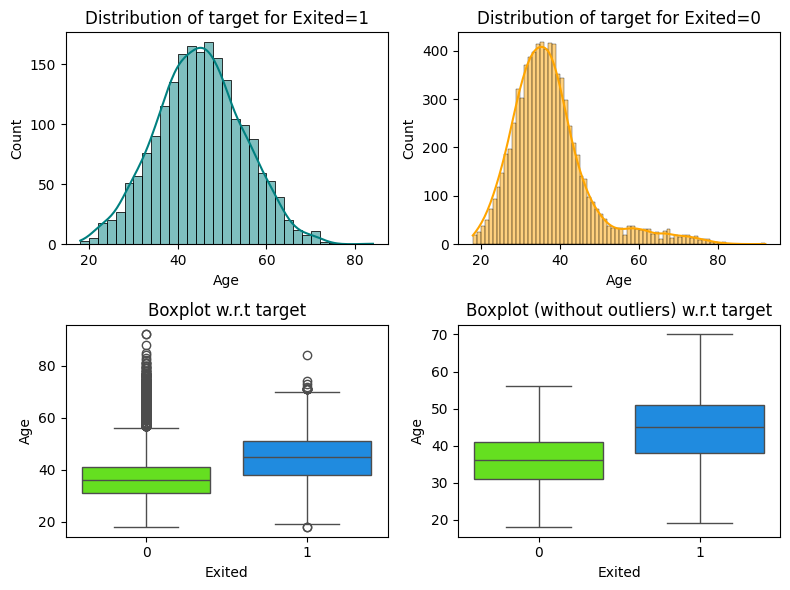

In [49]:

#Plots for Age vs other features
print("Fig "+str(figNo)+" - "+ "Age vs Exited")
figNo+=1

distribution_plot_wrt_target(dataw_df, "Age", "Exited")

Notice that customers between 40 and 50 tend to churn. This becomes more evident if we do not consider outliers.

<IPython.core.display.Javascript object>

Fig 23 - Age vs HasCrCard


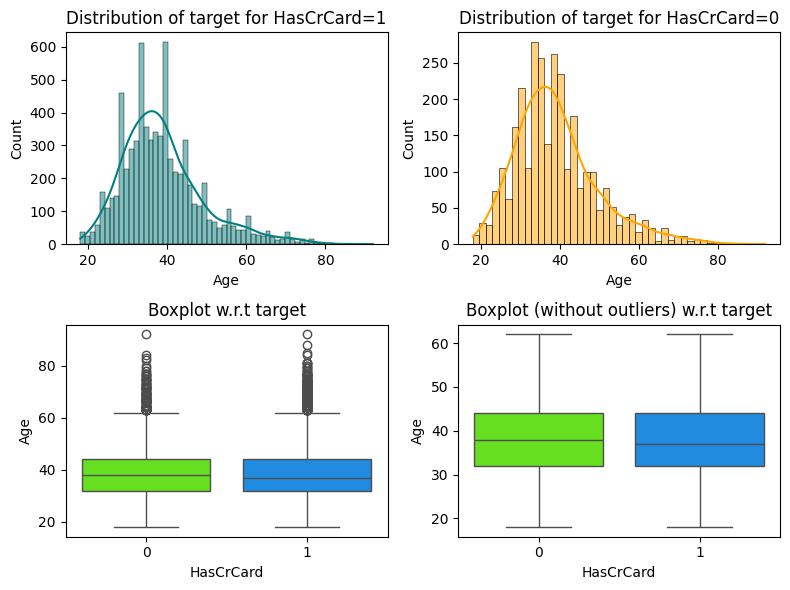

In [50]:

#Plots for Age vs other features
print("Fig "+str(figNo)+" - "+ "Age vs HasCrCard")
figNo+=1

distribution_plot_wrt_target(dataw_df, "Age", "HasCrCard")

Credit cards don't seem to influence churn.

<IPython.core.display.Javascript object>

Fig 24 - Age vs IsActiveMember


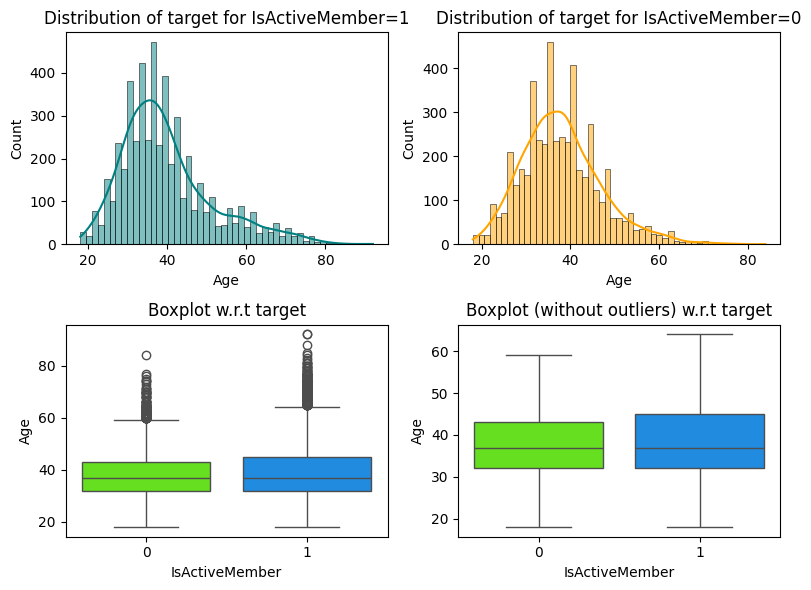

In [51]:

#Plots for Age vs other features
print("Fig "+str(figNo)+" - "+ "Age vs IsActiveMember")
figNo+=1

distribution_plot_wrt_target(dataw_df, "Age", "IsActiveMember")

Older Customers that are active tend to churn less.

###**EstimatedSalary vs Others**

<IPython.core.display.Javascript object>

Fig 25 - EstimatedSalary vs Exited


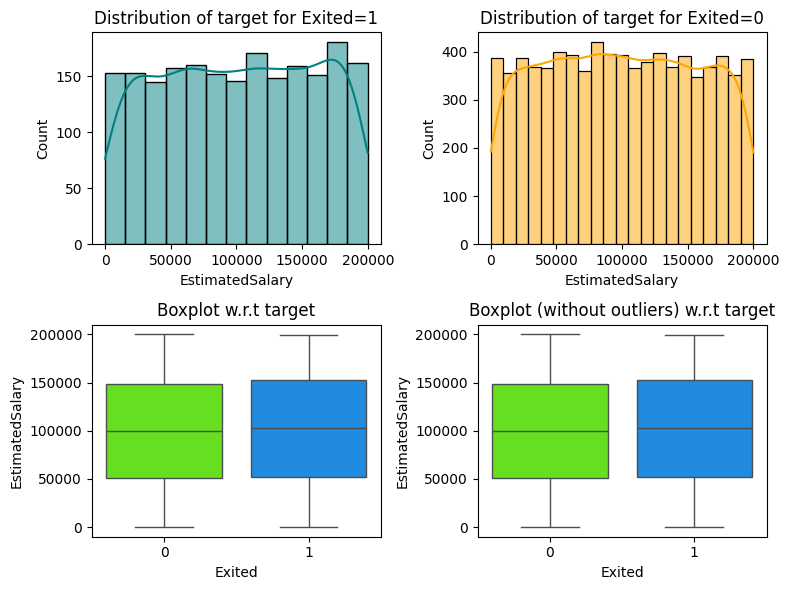

In [52]:

#Plots for EstimatedSalary vs other features
print("Fig "+str(figNo)+" - "+ "EstimatedSalary vs Exited")
figNo+=1

distribution_plot_wrt_target(dataw_df, "EstimatedSalary", "Exited")

EstimatedSalary doesn't seem to influence churn.

<IPython.core.display.Javascript object>

Fig 26 - EstimatedSalary vs HasCrCard


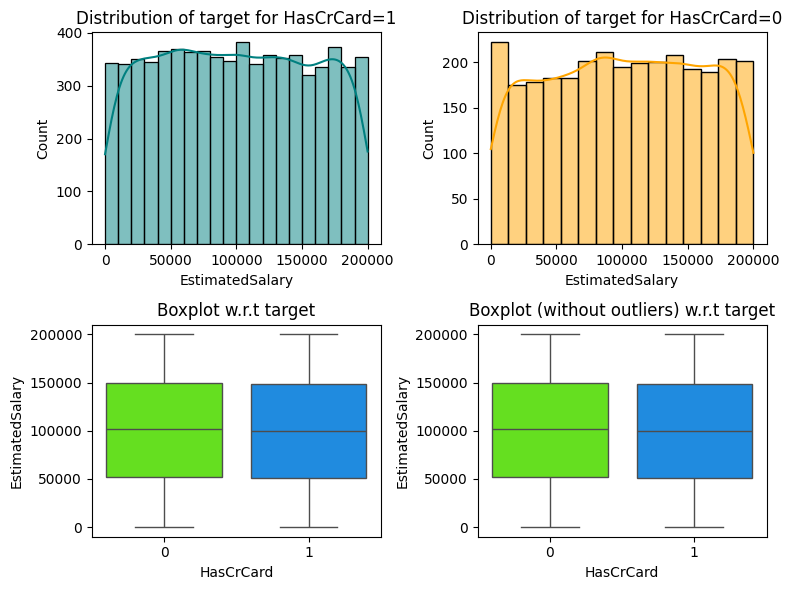

In [53]:

#Plots for EstimatedSalary vs other features
print("Fig "+str(figNo)+" - "+ "EstimatedSalary vs HasCrCard")
figNo+=1

distribution_plot_wrt_target(dataw_df, "EstimatedSalary", "HasCrCard")

Customers with or without a credit card have similar estimatedSalary distributions.

<IPython.core.display.Javascript object>

Fig 27 - EstimatedSalary vs Age


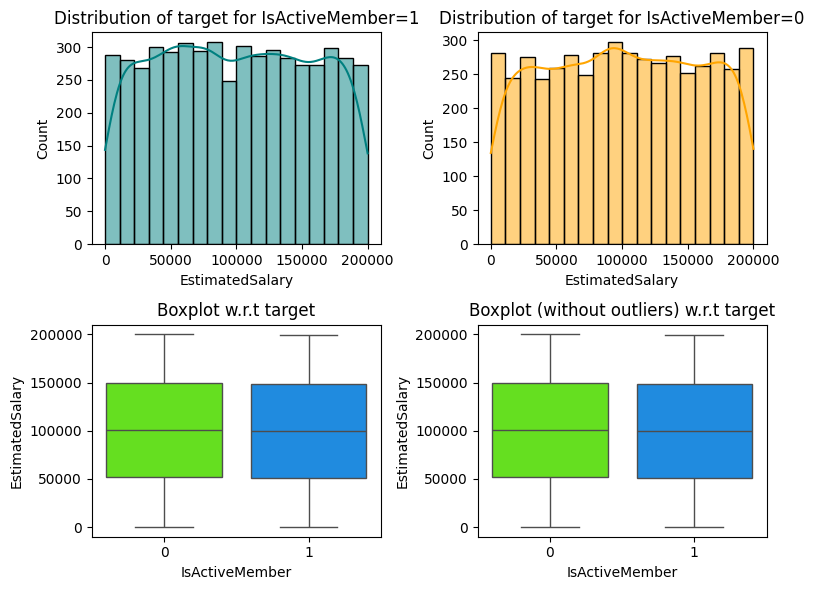

In [54]:

#Plots for EstimatedSalary vs other features
print("Fig "+str(figNo)+" - "+ "EstimatedSalary vs Age")
figNo+=1

distribution_plot_wrt_target(dataw_df, "EstimatedSalary", "IsActiveMember")

Active and inactive customers have similar EstimatedSalary distributions.

###**Balance vs Others**

<IPython.core.display.Javascript object>

Fig 28 - Balance vs Exited


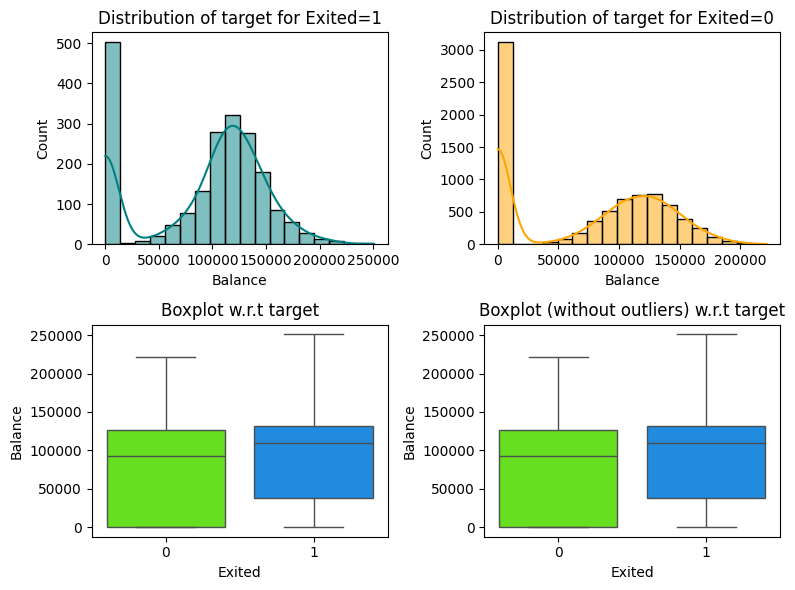

In [55]:

#Plots for Balance vs other features
print("Fig "+str(figNo)+" - "+ "Balance vs Exited")
figNo+=1

distribution_plot_wrt_target(dataw_df, "Balance", "Exited")

Customers with lower balance churn more. Customers with balances below 50,000 churn the most.

<IPython.core.display.Javascript object>

Fig 29 - Balance vs HasCrCard


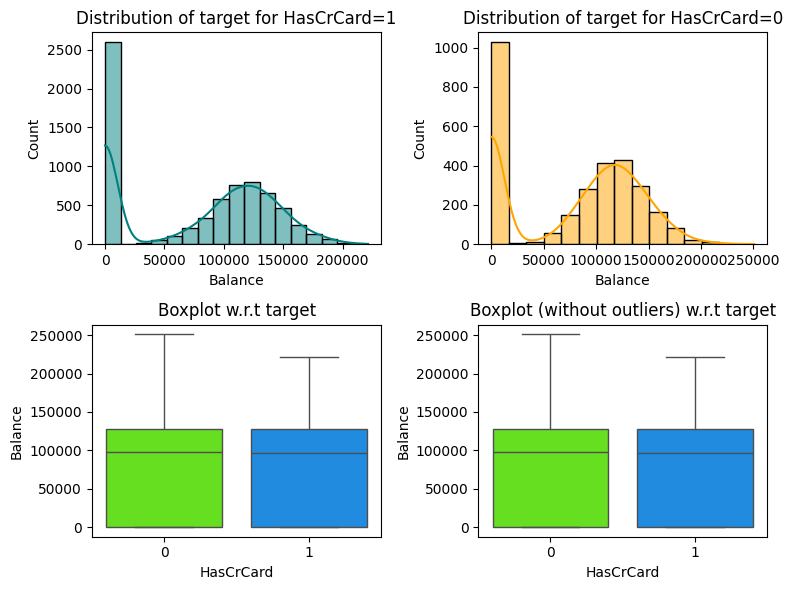

In [56]:

#Plots for Balance vs other features
print("Fig "+str(figNo)+" - "+ "Balance vs HasCrCard")
figNo+=1

distribution_plot_wrt_target(dataw_df, "Balance", "HasCrCard")

Customers with credit cards or without credit cards have similar balances distributions.

<IPython.core.display.Javascript object>

Fig 30 - Balance vs IsActiveMember


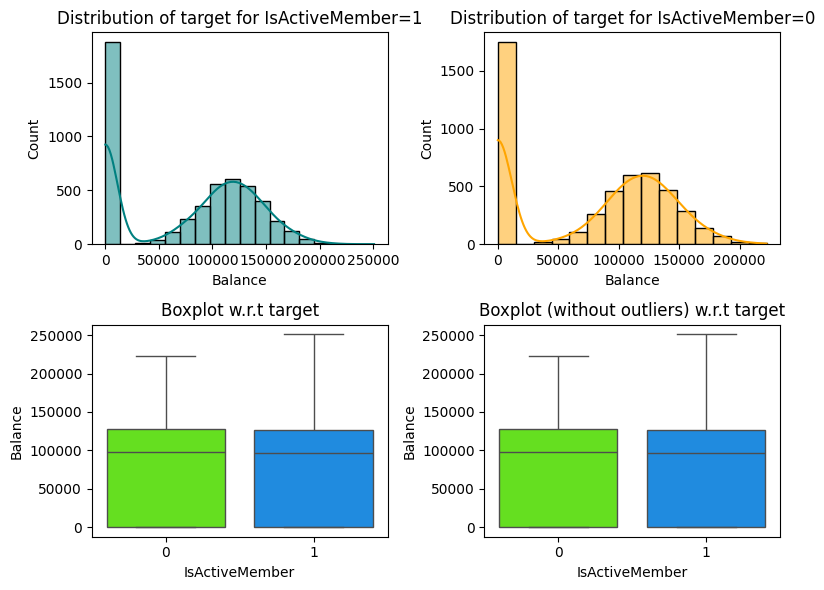

In [57]:

#Plots for Balance vs other features
print("Fig "+str(figNo)+" - "+ "Balance vs IsActiveMember")
figNo+=1

distribution_plot_wrt_target(dataw_df, "Balance", "IsActiveMember")

Active and inactive customers have similar balance distributions.

###**CreditScore vs Others**

<IPython.core.display.Javascript object>

Fig 31 - Exited vs CreditScore


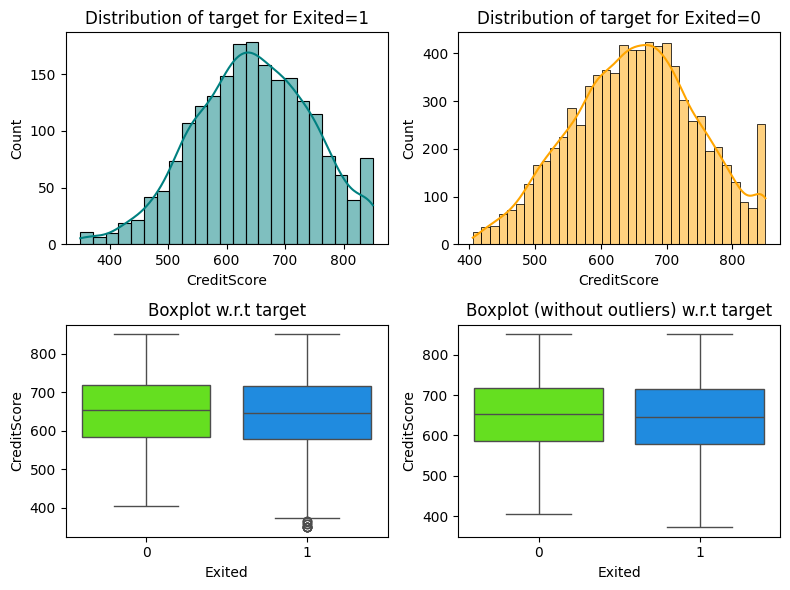

In [58]:

#Plots for CreditScore vs other features
print("Fig "+str(figNo)+" - "+ "Exited vs CreditScore")
figNo+=1

distribution_plot_wrt_target(dataw_df, "CreditScore", "Exited")

Customers with lower scores tend to churn more.

<IPython.core.display.Javascript object>

Fig 32 - HasCrCard vs CreditScore


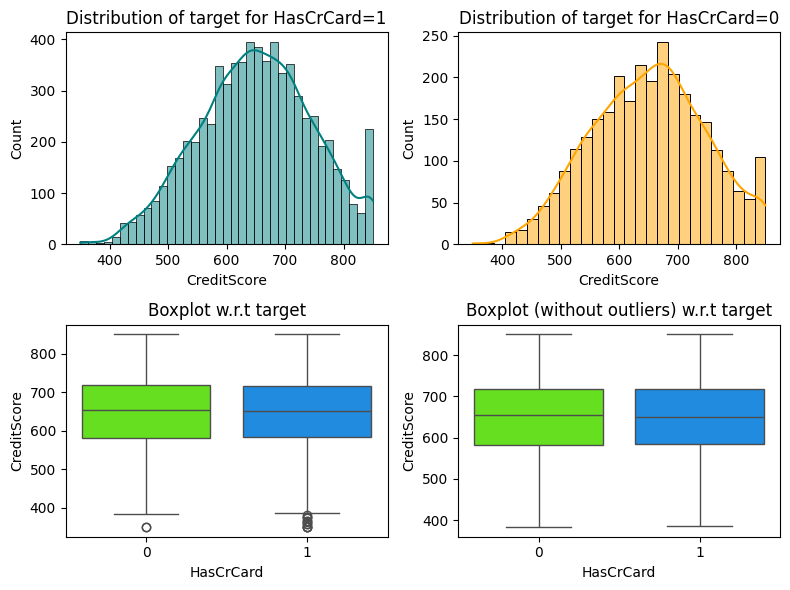

In [59]:

#Plots for CreditScore vs other features
print("Fig "+str(figNo)+" - "+ "HasCrCard vs CreditScore")
figNo+=1

distribution_plot_wrt_target(dataw_df, "CreditScore", "HasCrCard")

Customers with Credit Cards or w/o credit cards have similar distributions. However, most of the outliers with low Credit Scores have credit cards. This may be because unpaid credit cards or revolving balances affect credit ratings.

<IPython.core.display.Javascript object>

Fig 33 - IsActiveMember vs CreditScore


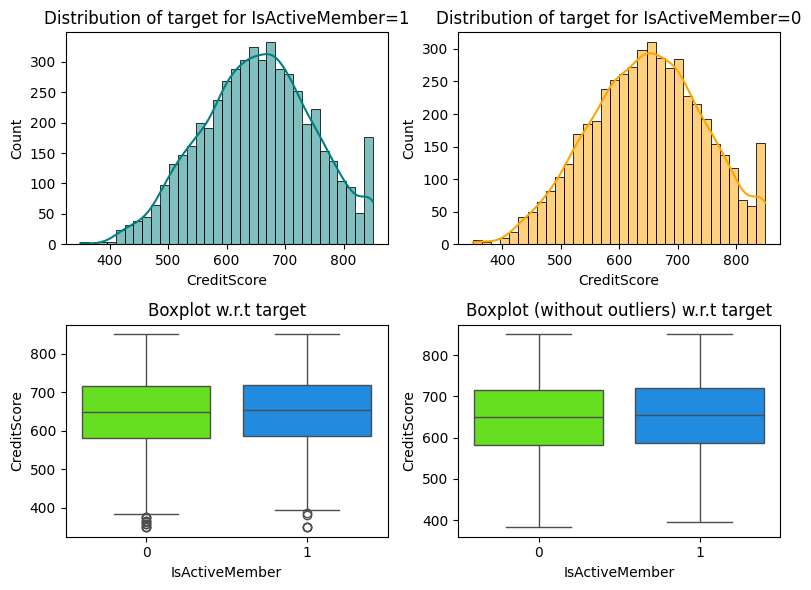

In [60]:

#Plots for Balance vs other features
print("Fig "+str(figNo)+" - "+ "IsActiveMember vs CreditScore")
figNo+=1
distribution_plot_wrt_target(dataw_df, "CreditScore", "IsActiveMember")

Active or inactive customers have similar credit scores.

###**Correlation**

<IPython.core.display.Javascript object>

Fig 34 - Correlation Heatmap


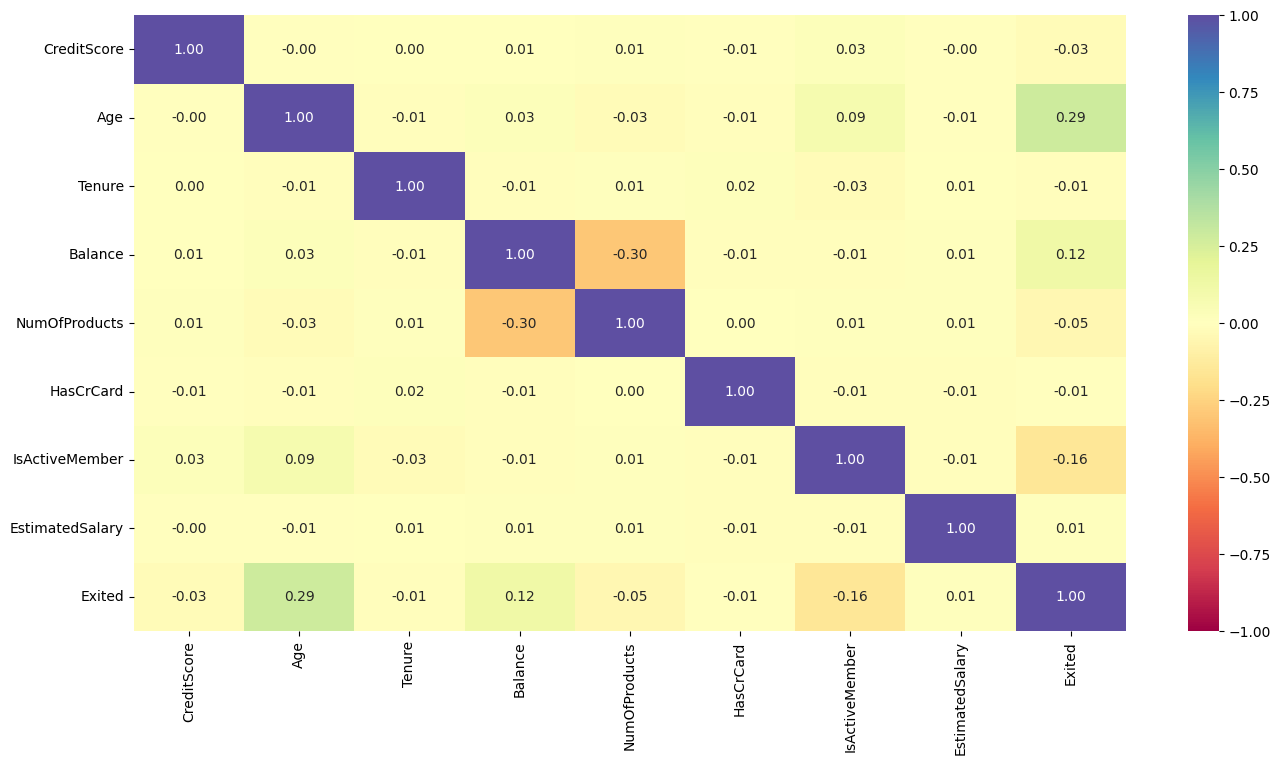

In [61]:
#Plots for Balance vs other features
print("Fig "+str(figNo)+" - "+ "Correlation Heatmap")
figNo+=1

plt.figure(figsize=(16, 8))
sns.heatmap(dataw_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Notice that the strongest correlations are between Balance and NumOfProducts, Age and Exited, IsActiveMember and Exited, and Balance and Exited.

Some of these correlations are logical, as if a customer is not active, he/she probably churned and if is active probably did not churn; if the customer has a low Balance or zero balance probably churned, and if has a large balance probably didn't.

## **Final Data Processing for Model Use**

In [62]:
#check status of features dtypes
dataw_df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [63]:
#make a copy of the dataframe
datawf_df = dataw_df.copy()

<IPython.core.display.Javascript object>

###**Separate Dependant from Independant Variables**

In [64]:
#Separate Indepedent and Dependant Variables
#Our target is 'Exited'
X = datawf_df.drop(['Exited'],axis = 1)
y = datawf_df[['Exited']]

<IPython.core.display.Javascript object>

In [65]:
#verify that the target was dropped from X
X.head()

<IPython.core.display.Javascript object>

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               1        101348.88  
1          0               1        112542.58  
2          1               0        113931.57  
3          0               0         93826.63  
4          1               1         79084.10

In [66]:
#verify that y contains the target
y.head()

<IPython.core.display.Javascript object>

Exited
0       1
1       0
2       1
3       0
4       0

###**Split dataset into training and testing sets**

In [67]:
#splitting dataset into training and testing, set random_state to 1, stratify to reduce error, and
#train to 80%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1, stratify=y)


<IPython.core.display.Javascript object>

###**Encoding Categorical Columns**

In [68]:
#There are 2 categorical features: Geography and Gender

#encode Geography
labelencoder_Geo = LabelEncoder()
X_train['Geography']= labelencoder_Geo.fit_transform(X_train['Geography'])
X_test['Geography']= labelencoder_Geo.transform(X_test['Geography'])

<IPython.core.display.Javascript object>

In [69]:
#encode Gender
labelencoder_Gen = LabelEncoder()
X_train['Gender']= labelencoder_Gen.fit_transform(X_train['Gender'])
X_test['Gender']= labelencoder_Gen.transform(X_test['Gender'])

<IPython.core.display.Javascript object>

In [70]:
#check X_train dataframe
X_train.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 4256 to 8407
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      8000 non-null   int64  
 1   Geography        8000 non-null   int64  
 2   Gender           8000 non-null   int64  
 3   Age              8000 non-null   int64  
 4   Tenure           8000 non-null   int64  
 5   Balance          8000 non-null   float64
 6   NumOfProducts    8000 non-null   int64  
 7   HasCrCard        8000 non-null   int64  
 8   IsActiveMember   8000 non-null   int64  
 9   EstimatedSalary  8000 non-null   float64
dtypes: float64(2), int64(8)
memory usage: 687.5 KB


Notice that now all features are numerical.

In [71]:
#verify the encoding on X_train
X_train.head()

<IPython.core.display.Javascript object>

CreditScore  Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
4256          596          2       0   76       9  134208.25              1   
9151          614          0       1   49       1       0.00              2   
696           445          2       1   62       1   64119.38              1   
4898          544          0       0   40       7       0.00              1   
6427          746          0       1   37       2       0.00              2   

      HasCrCard  IsActiveMember  EstimatedSalary  
4256          1               1         13455.43  
9151          1               0        192440.54  
696           1               1         76569.64  
4898          0               1        161076.92  
6427          1               0        143194.05

In [72]:
#verify the encoding on X_test
X_test.head()

<IPython.core.display.Javascript object>

CreditScore  Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
4466          413          2       1   35       2       0.00              2   
3754          535          2       1   35       8  118989.92              1   
9601          659          0       0   33       7   89939.62              1   
9758          556          1       0   43       4  125890.72              1   
8577          754          1       1   65       1  136186.44              1   

      HasCrCard  IsActiveMember  EstimatedSalary  
4466          1               1         60972.84  
3754          1               1        135536.72  
9601          1               0        136540.09  
9758          1               1         74854.97  
8577          1               1        121529.59

###**Normalizing the Data**

We need to normalize the data, as we hinted earlier during our Quick analysis of the dataset.

As we have seen, there are some features that will bias the model if they are not normalized because they contain very large values when compared to other features.

There are several techniques to normalize the data as explained here:

[Compare the effect of different scalers on data with outliers - scikitlearn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

Notice (extracted from above reference):

1. StandardScaler removes the mean and scales the data to unit variance. It cannot guarantee balanced feature scales in the presence of outliers.

2. MinMaxScaler rescales the dataset such that all feature values are in the range [0,1]. This scaling compresses all inliers into a narrow range.

Both StandardScaler and MinScaler are very sensitive to the presence of outliers.

3. MaxAbsScaler is similar to MinMaxScaler except that the values are mapped accross several ranges depending on whether negative or positive values are present.  If only positive values are present, the range is [0, 1]. If only negative values are present, the range is [-1, 0]. If both negative and positive values are present, the range is [-1, 1]. On positive only data, both MinMaxScaler and MaxAbsScaler behave similarly. MaxAbsScaler therefore also suffers from the presence of large outliers.

4. RobustScaler: the centering and scaling statistics of RobustScaler are based on percentiles and are therefore not influenced by a small number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar.

5. PowerTransformer: applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness. Currently the Yeo-Johnson and Box-Cox transforms are supported and the optimal scaling factor is determined via maximum likelihood estimation in both methods. By default, PowerTransformer applies zero-mean, unit variance normalization.

6. QuantileTransformer (uniform output) applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data, including outliers, will be mapped to a uniform distribution with the range [0, 1], making outliers indistinguishable from inliers.

Both RobustScaler and QuantileTransformer are robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation.

7. Normalizer rescales the vector for each sample to have unit norm, independently of the distribution of the samples.

So which type of data scaling/normalization/standardization should we apply to our dataset, considering that our dataset contains outliers?

We had seen outliers in CreditScore and Age. How important are these outliers?

In [73]:
#RobustScaler
scaler1=RobustScaler()
X_train_robust = scaler1.fit_transform(X_train)
X_test_robust = scaler1.fit_transform(X_test)

<IPython.core.display.Javascript object>

In [74]:
#StandardScaler
scaler2 = StandardScaler()
X_train_standard = scaler2.fit_transform(X_train)
X_test_standard = scaler2.fit_transform(X_test)

<IPython.core.display.Javascript object>

In [75]:
#MinMaxScaler
scaler3 = MinMaxScaler()
X_train_minmax = scaler3.fit_transform(X_train)
X_test_minmax = scaler3.fit_transform(X_test)

<IPython.core.display.Javascript object>

We will use RobustScaler in agreement to what we discussed lines above.

In [76]:
#check the dataset after robust scaler
X_train_robust[1]

<IPython.core.display.Javascript object>

array([-0.2761194 ,  0.        ,  0.        ,  1.        , -0.8       ,
       -0.75831882,  1.        ,  0.        , -1.        ,  0.95108524])

In [77]:
#check the dataset after standardization
X_train_standard[1]

<IPython.core.display.Javascript object>

array([-0.37047162, -0.90311032,  0.91301738,  0.95628193, -1.37631159,
       -1.21986153,  0.79790076,  0.6493972 , -1.03382164,  1.61465549])

In [78]:
#check the dataset after MinMaxScaler
X_train_minmax[1]

<IPython.core.display.Javascript object>

array([0.528     , 0.        , 1.        , 0.41891892, 0.1       ,
       0.        , 0.33333333, 1.        , 0.        , 0.96223669])

As can be seen, the dataset was standardize.
We did not normalize it (min-max-scale) because

In [79]:
#Checking that shapes are correct
print(X_train_robust.shape)
print(X_test_robust.shape)
print(y_train.shape)
print(y_test.shape)

<IPython.core.display.Javascript object>

(8000, 10)
(2000, 10)
(8000, 1)
(2000, 1)


Shapes look correct

In [80]:
#copy our normalized data
X_train = X_train_robust.copy()
X_test = X_test_robust.copy()

<IPython.core.display.Javascript object>

## **Metrics to Consider**

Our model has to predict customer churn.

In this case, the worst case scenario is that our model incorrectly predicts a customer as "No Churn" when it actually churns. This will lead to revenue loss and loss of market share. New Customer acquisition is difficult but convincing a churned customer to return may require more time and effort, so it is very important to reduce churn. This is the case of a False Negative.

While it is also important to predict 'Churned' customers , if a customer is incorrectly categorized as 'churn' (that is, a customer is classified as 'churn' when it doesn't churn) this will incurr in unnecessary costs (efforts) to keep the customer. However, we can agree that this cost is marginal if the customer is happy because the bank can always have the opportunity to generate revenue from an existing account. This is the case of a False Positive.

In this case we deem more important to reduce False Negatives errors (or maximize True Positives).

Ideally, we want to reduce False Positives (classified as churn incorrectly) increase True Positives while reducing False Positives, but we will settle on reducing False Negatives first, and consider reducing False Positives as an ideal scenario only.

We need to look at a combination of metrics to evaluate the model.

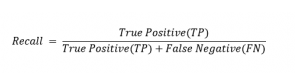


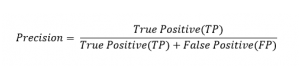

For instance we want a high recall and a high precision but usually if one of them is high, the other will tend to decrease and viceversa, that is a high precision yields a low recall and viceversa.

So accuracy and F1 score are also metrics that we need to consider when we evaluate the model's performance.

So we should attempt higher F1 scores, accuracy, precision, and recall.


##**Neural Network Model**

###**Model 1 with SGD**


- Activation: Relu and sigmoid in output
- Hidden Layers: 2
- kernel_initializer = 'he_uniform'
- Neurons: input: 64, hl1: 32, hl2: 32
- Optimizer: SGD

We use sigmoid because we want probability outcomes
Loss: binary_crossentropy for binary classification

- NoDropout
- NO early stopping
- No BatchNormalization

In [81]:
#we clear the backend session
K.clear_session()

#set random number seed
np.random.seed(50)
random.seed(50)
tf.random.set_seed(50)

<IPython.core.display.Javascript object>

In [82]:
#Initialize the Neural Network
# Initializing the model
model1 = Sequential()

# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model1.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(10,)))

# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model1.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model1.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

# Adding the output layer with one neuron and sigmoid as activation
model1.add(Dense(1, activation='sigmoid'))


<IPython.core.display.Javascript object>

In [83]:
#model summary
model1.summary()

<IPython.core.display.Javascript object>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Initializing the Optimizer
optimizer1 = SGD(learning_rate=0.001)

# Compiling the model with 'mse' as loss function and metrics
model1.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [85]:
# Fitting the model on train and validation with 50 epochs
history1 = model1.fit(X_train, y_train, validation_split=0.2, epochs=50,batch_size=32,verbose=1)

<IPython.core.display.Javascript object>

Epoch 1/50
200/200 [==============================] - 1s 4ms/step - loss: 0.7392 - accuracy: 0.5030 - val_loss: 0.5978 - val_accuracy: 0.6825
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.5589 - accuracy: 0.7481 - val_loss: 0.5357 - val_accuracy: 0.7700
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 0.5252 - accuracy: 0.7800 - val_loss: 0.5212 - val_accuracy: 0.7812
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 0.5147 - accuracy: 0.7903 - val_loss: 0.5147 - val_accuracy: 0.7875
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.5084 - accuracy: 0.7923 - val_loss: 0.5095 - val_accuracy: 0.7881
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.5032 - accuracy: 0.7931 - val_loss: 0.5047 - val_accuracy: 0.7887
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7947 - val_loss: 0.5001 - val_accuracy: 0.7887
Epoch 

<IPython.core.display.Javascript object>

Fig 35 - Losses vs Epochs
63/63 [==============================] - 0s 2ms/step - loss: 0.4198 - accuracy: 0.8240


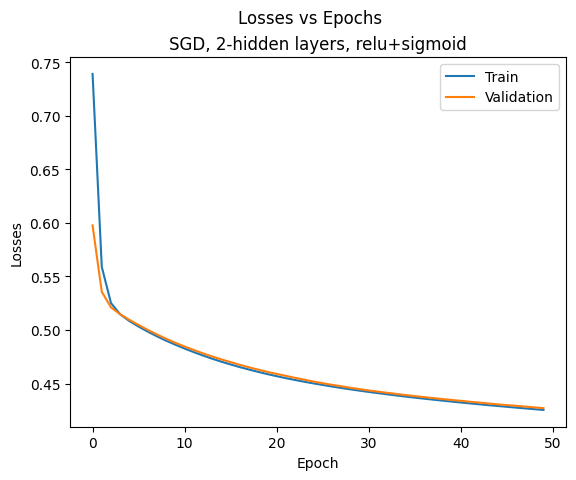

In [86]:
# Capturing learning history per epoch
hist1  = pd.DataFrame(history1.history)
hist1['epoch'] = history1.epoch

print("Fig "+str(figNo)+" - "+ "Losses vs Epochs")
figNo+=1

# Plotting accuracy at different epochs
plt.suptitle('Losses vs Epochs')
plt.title("SGD, 2-hidden layers, relu+sigmoid")
plt.plot(hist1['loss'])
plt.plot(hist1['val_loss'])
plt.ylabel('Losses')
plt.xlabel('Epoch')

plt.legend(("Train" , "Validation") , loc =0)

#Printing results
results1 = model1.evaluate(X_test, y_test)

The losses vs epochs show that losses decreased as we increased the number of epochs. However, losses at 50 epochs seemed still high.

<IPython.core.display.Javascript object>

Fig 36 - Accuracy vs Epochs


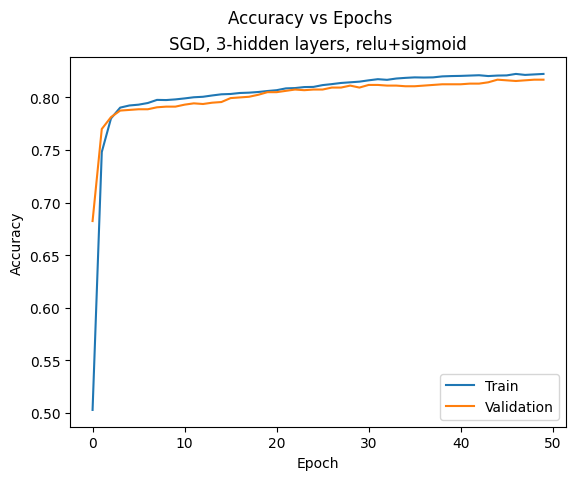

In [87]:
#Plot accuracy

print("Fig "+str(figNo)+" - "+ "Accuracy vs Epochs")
figNo+=1

plt.plot(hist1['accuracy'])
plt.plot(hist1['val_accuracy'])
plt.suptitle('Accuracy vs Epochs')
plt.title("SGD, 3-hidden layers, relu+sigmoid")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

From the accuracy vs epochs plot, we see that accuracy increases with the number of epochs. Notice that by 50 epochs the accuracy has not settled and it continues to increase.

In [88]:
#head of history dataframe for model1
hist1.head()

<IPython.core.display.Javascript object>

loss  accuracy  val_loss  val_accuracy  epoch
0  0.739211  0.502969  0.597751      0.682500      0
1  0.558946  0.748125  0.535688      0.770000      1
2  0.525206  0.780000  0.521198      0.781250      2
3  0.514654  0.790313  0.514687      0.787500      3
4  0.508391  0.792344  0.509500      0.788125      4

In [89]:
#prediction, no threshold
y_pred1 = model1.predict(X_test)
y_pred1

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[0.11800176],
       [0.130135  ],
       [0.17581971],
       ...,
       [0.28254202],
       [0.08750593],
       [0.183015  ]], dtype=float32)

<IPython.core.display.Javascript object>

Fig 37 - auc_roc curve


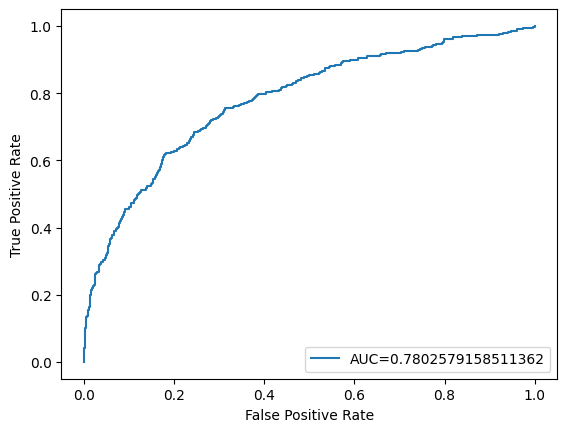

In [90]:
#plot the auc_roc_curve

print("Fig "+str(figNo)+" - "+ "auc_roc curve")
figNo+=1

fpr, tpr, thresholds  = metrics.roc_curve(y_test, y_pred1)
auc = roc_auc_score(y_test, y_pred1 )

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (area under the curve) is 0.78, which means that the predictions of the model are 78% correct.



In [91]:
#Calculate the best threshold using Youden's J statistic
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
gmeans = np.sqrt(tpr *(1-fpr))
print("The best threshold is %f"%best_thresh)

<IPython.core.display.Javascript object>

The best threshold is 0.207006


<IPython.core.display.Javascript object>

Fig 38 - auc_roc Curve with best threshold


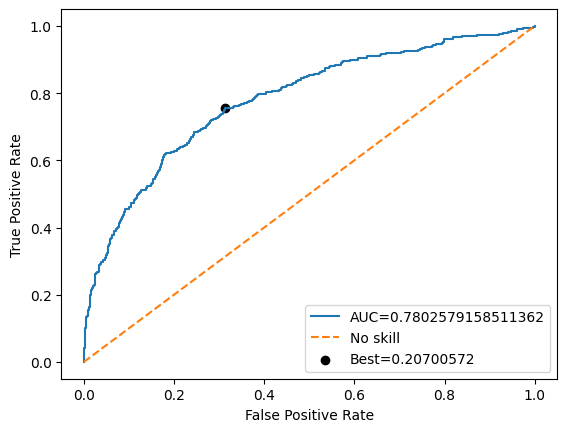

In [92]:
#plot the auc_roc_curve with the best threshold
print("Fig "+str(figNo)+" - "+ "auc_roc Curve with best threshold")
figNo+=1


fpr, tpr, thresholds  = metrics.roc_curve(y_test, y_pred1)
auc = roc_auc_score(y_test, y_pred1 )

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0,1],[0,1], linestyle='--',label="No skill")
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best='+str(best_thresh))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Lets use the threshold in our prediction

In [93]:
#run prediction, set the threshold to best threshold
y_pred1_bt = model1.predict(X_test)
y_pred1_bt = (y_pred1_bt > best_thresh)
y_pred1_bt

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

Fig 39 - Confucius Matrix - Model1


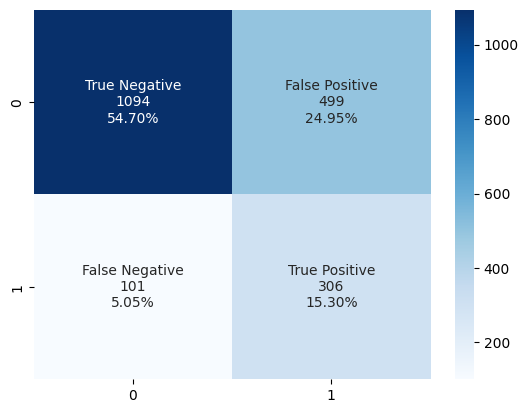

In [94]:
#create a confusion matrix
print("Fig "+str(figNo)+" - "+ "Confucius Matrix - Model1")
figNo+=1

cm1 = confusion_matrix(y_test, y_pred1_bt)
labels = ['True Negative','False Positive','False Negative','True Positive']
make_confusion_matrix(cm1, group_names=labels, #categories=categories,
                      cmap='Blues')

Notice False Negatives at 5.05% and True Positives are 15.30%. There is a high percentage of False Positives but as we discussed before this is not as important as reducing False Negatives.

In [95]:
cr1= metrics.classification_report(y_test,y_pred1_bt)
print(cr1)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.92      0.69      0.78      1593
           1       0.38      0.75      0.50       407

    accuracy                           0.70      2000
   macro avg       0.65      0.72      0.64      2000
weighted avg       0.81      0.70      0.73      2000



We want to first have the lowest possible number of False Negatives and ideally, also minimize the number of False Positives (but this is not a priority, we can live with larger False Positives as explained earlier).

For class 1 (Churn):
-Precision of 0.38
-Recall of 0.75
-F1-Score of 0.50

The performance of the model is good.

### **Model2 with Adam**

- Activation: Relu and sigmoid in output
- Hidden Layers: 2
- kernel_initializer = 'he_uniform'
- Neurons: 64, 32, 32
- Optimizer: Adam

We use sigmoid because we want probability outcomes
Loss: binary_crossentropy for binary classification

- NoDropout
- NO early stopping
- No BN

In [96]:
#we clear the backend session
K.clear_session()

#set random number seed
np.random.seed(50)
random.seed(50)
tf.random.set_seed(50)

<IPython.core.display.Javascript object>

In [97]:
#Initialize the Neural Network
# Initializing the model
model2 = Sequential()

# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model2.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(10,)))

# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

# Adding the output layer with one neuron and sigmoid as activation
model2.add(Dense(1, activation='sigmoid'))


<IPython.core.display.Javascript object>

In [98]:
#description of the model
model2.summary()

<IPython.core.display.Javascript object>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Initializing the Optimizer
optimizer2 = Adam(learning_rate=0.001)

# Compiling the model with 'mse' as loss function and metrics
model2.compile(loss='binary_crossentropy', optimizer=optimizer2, metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [100]:
# Fitting the model on train and validation with 50 epochs
history2 = model2.fit(X_train, y_train, validation_split=0.2, epochs=50,batch_size=32,verbose=1)

<IPython.core.display.Javascript object>

Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.4777 - accuracy: 0.7856 - val_loss: 0.4231 - val_accuracy: 0.8156
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4077 - accuracy: 0.8317 - val_loss: 0.3881 - val_accuracy: 0.8381
Epoch 3/50
200/200 [==============================] - 1s 4ms/step - loss: 0.3844 - accuracy: 0.8441 - val_loss: 0.3741 - val_accuracy: 0.8419
Epoch 4/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3659 - accuracy: 0.8505 - val_loss: 0.3584 - val_accuracy: 0.8556
Epoch 5/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3511 - accuracy: 0.8573 - val_loss: 0.3527 - val_accuracy: 0.8562
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3424 - accuracy: 0.8591 - val_loss: 0.3537 - val_accuracy: 0.8544
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 0.3350 - accuracy: 0.8620 - val_loss: 0.3471 - val_accuracy: 0.8562
Epoch 

<IPython.core.display.Javascript object>

Fig 40 - Losses vs Epochs (model2)
63/63 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8505


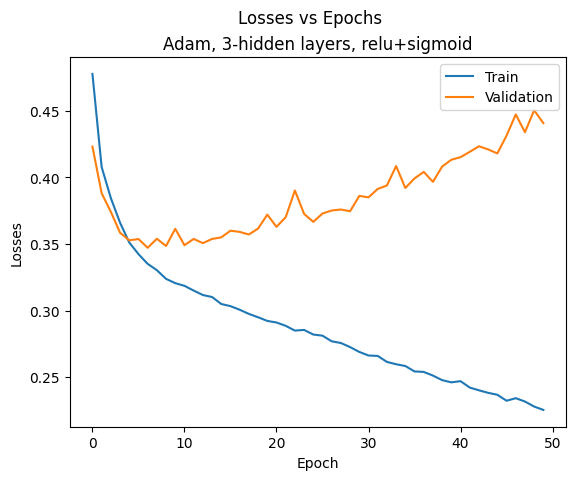

In [101]:
# Capturing learning history per epoch

print("Fig "+str(figNo)+" - "+ "Losses vs Epochs (model2)")
figNo+=1

hist2  = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch

# Plotting accuracy at different epochs
plt.suptitle('Losses vs Epochs')
plt.title("Adam, 3-hidden layers, relu+sigmoid")
plt.plot(hist2['loss'])
plt.plot(hist2['val_loss'])
plt.ylabel('Losses')
plt.xlabel('Epoch')

plt.legend(("Train" , "Validation") , loc =0)

#Printing results
results2 = model2.evaluate(X_test, y_test)

Notice that the validation set performs well only until 5 epochs. Past that the losses start to increase.

<IPython.core.display.Javascript object>

Fig 41 - Accuracy vs Epochs (model2)


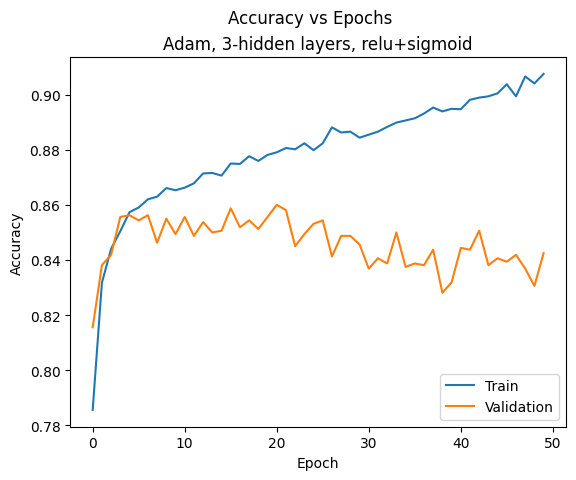

In [102]:
#plot accuracy vs epochs
print("Fig "+str(figNo)+" - "+ "Accuracy vs Epochs (model2)")
figNo+=1

plt.plot(hist2['accuracy'])
plt.plot(hist2['val_accuracy'])
plt.suptitle('Accuracy vs Epochs')
plt.title("Adam, 3-hidden layers, relu+sigmoid")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

From the accuracy vs epochs plot, we see that accuracy increases with the number of epochs for the training set but after 5 epochs, accuracy starts to decrease for the validation set.

In [103]:
#head of history dataframe for model2
hist2.head()

<IPython.core.display.Javascript object>

loss  accuracy  val_loss  val_accuracy  epoch
0  0.477659  0.785625  0.423086      0.815625      0
1  0.407746  0.831719  0.388057      0.838125      1
2  0.384418  0.844063  0.374065      0.841875      2
3  0.365897  0.850469  0.358410      0.855625      3
4  0.351087  0.857344  0.352668      0.856250      4

In [104]:
#run prediction
y_pred2 = model2.predict(X_test)
y_pred2

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 5ms/step


array([[0.00146569],
       [0.04419639],
       [0.25872645],
       ...,
       [0.22284946],
       [0.08210781],
       [0.01031026]], dtype=float32)

<IPython.core.display.Javascript object>

Fig 42 - auc_roc curve (model2)


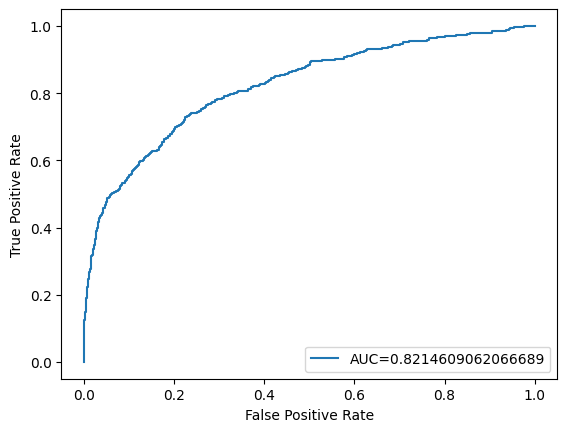

In [105]:
#plot the auc_roc_curve
print("Fig "+str(figNo)+" - "+ "auc_roc curve (model2)")
figNo+=1

fpr2, tpr2, thresholds2  = metrics.roc_curve(y_test, y_pred2)
auc2 = roc_auc_score(y_test, y_pred2 )

plt.plot(fpr2,tpr2,label="AUC="+str(auc2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (area under the curve) is 0.82, which means that the predictions of the model are 82% correct.



In [106]:
#Calculate the best threshold using Youden's J statistic
J2 = tpr2 - fpr2
ix2 = argmax(J2)
best_thresh2 = thresholds2[ix2]
print("The best threshold is %f"%best_thresh2)

<IPython.core.display.Javascript object>

The best threshold is 0.156290


<IPython.core.display.Javascript object>

Fig 43 - auc_roc curve with best Threshold (model2)


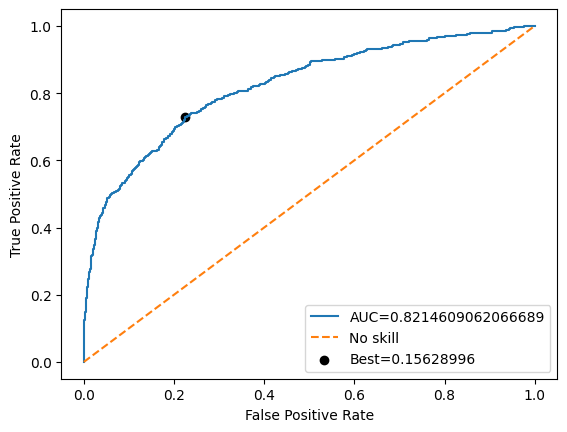

In [107]:
#plot the auc_roc_curve with the best threshold
print("Fig "+str(figNo)+" - "+ "auc_roc curve with best Threshold (model2)")
figNo+=1

fpr2, tpr2, thresholds2  = metrics.roc_curve(y_test, y_pred2)
auc2 = roc_auc_score(y_test, y_pred2)

plt.plot(fpr2,tpr2,label="AUC="+str(auc2))
plt.plot([0,1],[0,1], linestyle='--',label="No skill")
plt.scatter(fpr2[ix2], tpr2[ix2], marker='o', color='black', label='Best='+str(best_thresh2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Lets use the threshold in our prediction.

In [108]:
#run prediction, set the threshold to best threshold
y_pred2_bt = model2.predict(X_test)
y_pred2_bt = (y_pred2_bt > best_thresh2)
y_pred2_bt

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 6ms/step


array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

Fig 44 - Confucious Matrix (model2)


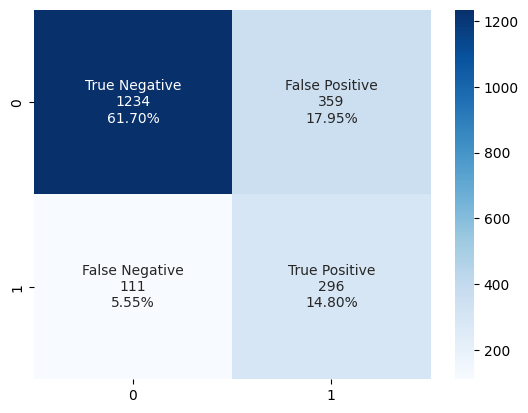

In [109]:
#create a confusion matrix
print("Fig "+str(figNo)+" - "+ "Confucious Matrix (model2)")
figNo+=1

cm2 = confusion_matrix(y_test, y_pred2_bt)
labels = ['True Negative','False Positive','False Negative','True Positive']
make_confusion_matrix(cm2, group_names=labels, #categories=categories,
                      cmap='Blues')

False Negative actually increased slightly and False Positives decreased significantly. We care more about False Negatives.

In [110]:
#classification report
cr2= metrics.classification_report(y_test,y_pred2_bt)
print(cr2)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1593
           1       0.45      0.73      0.56       407

    accuracy                           0.77      2000
   macro avg       0.68      0.75      0.70      2000
weighted avg       0.82      0.77      0.78      2000



The recall for class 1 actually decreased compared to model1.

For class 1 (Churn):
-Precision of 0.45
-Recall of 0.73
-F1-Score of 0.56

The model performs well but not better than Model1.

## **Model3 with Adam, BN**

- Activation: Relu and sigmoid in output
- Hidden Layers: 2
- kernel_initializer = 'he_uniform'
- Neurons: Input: 64, hl1: 32, hl2: 32
- Optimizer: Adam
- Adds BatchNormalization

We use sigmoid because we want probability outcomes
Loss: binary_crossentropy for binary classification

- NoDropout
- NO early stopping

In [111]:
#we clear the backend session
K.clear_session()

#set random number seed
np.random.seed(50)
random.seed(50)
tf.random.set_seed(50)

<IPython.core.display.Javascript object>

In [112]:
#Initialize the Neural Network
# Initializing the model
model3 = Sequential()

# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model3.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(10,)))
model3.add(BatchNormalization())

# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model3.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model3.add(BatchNormalization())

# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model3.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

# Adding the output layer with one neuron and sigmoid as activation
model3.add(Dense(1, activation='sigmoid'))


<IPython.core.display.Javascript object>

In [113]:
#model summary
model3.summary()

<IPython.core.display.Javascript object>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [114]:
# Initializing the Optimizer
optimizer3 = Adam(learning_rate=0.001)

# Compiling the model with 'mse' as loss function and metrics
model3.compile(loss='binary_crossentropy', optimizer=optimizer3, metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [115]:
# Fitting the model on train and validation with 50 epochs
history3 = model3.fit(X_train, y_train, validation_split=0.2, epochs=50,batch_size=32,verbose=1)

<IPython.core.display.Javascript object>

Epoch 1/50
200/200 [==============================] - 5s 9ms/step - loss: 0.4807 - accuracy: 0.7681 - val_loss: 0.3874 - val_accuracy: 0.8431
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 0.3865 - accuracy: 0.8361 - val_loss: 0.3572 - val_accuracy: 0.8525
Epoch 3/50
200/200 [==============================] - 1s 6ms/step - loss: 0.3693 - accuracy: 0.8453 - val_loss: 0.3558 - val_accuracy: 0.8500
Epoch 4/50
200/200 [==============================] - 2s 8ms/step - loss: 0.3559 - accuracy: 0.8494 - val_loss: 0.3474 - val_accuracy: 0.8550
Epoch 5/50
200/200 [==============================] - 1s 7ms/step - loss: 0.3481 - accuracy: 0.8559 - val_loss: 0.3459 - val_accuracy: 0.8562
Epoch 6/50
200/200 [==============================] - 1s 6ms/step - loss: 0.3474 - accuracy: 0.8544 - val_loss: 0.3490 - val_accuracy: 0.8525
Epoch 7/50
200/200 [==============================] - 1s 7ms/step - loss: 0.3422 - accuracy: 0.8542 - val_loss: 0.3477 - val_accuracy: 0.8594
Epoch 

<IPython.core.display.Javascript object>

Fig 45 - Losses vs Epochs (model3)
63/63 [==============================] - 0s 2ms/step - loss: 0.4023 - accuracy: 0.8465


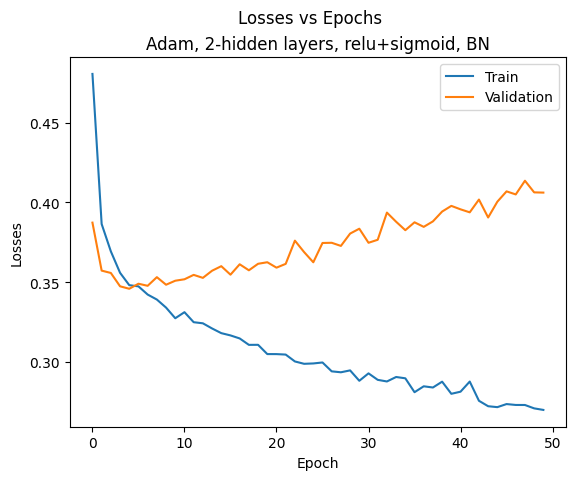

In [116]:
# Capturing learning history per epoch

print("Fig "+str(figNo)+" - "+ "Losses vs Epochs (model3)")
figNo+=1

hist3  = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch

# Plotting accuracy at different epochs
plt.suptitle('Losses vs Epochs')
plt.title("Adam, 2-hidden layers, relu+sigmoid, BN")
plt.plot(hist3['loss'])
plt.plot(hist3['val_loss'])
plt.ylabel('Losses')
plt.xlabel('Epoch')

plt.legend(("Train" , "Validation") , loc =0)

#Printing results
results3 = model3.evaluate(X_test, y_test)

The validation loss increases past around 7 epochs. This trend continues past 50 epochs.

<IPython.core.display.Javascript object>

Fig 46 - Accuracy vs epochs (model3)


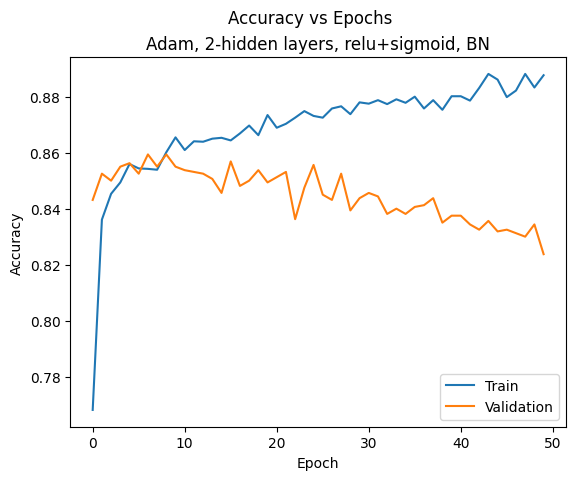

In [117]:
#plot accuracy vs epochs

print("Fig "+str(figNo)+" - "+ "Accuracy vs epochs (model3)")
figNo+=1

plt.plot(hist3['accuracy'])
plt.plot(hist3['val_accuracy'])
plt.suptitle('Accuracy vs Epochs')
plt.title("Adam, 2-hidden layers, relu+sigmoid, BN")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

From the accuracy vs epochs plot, we see that Validation accuracy increases until about 7 epochs and then begins to decrease, Notice that by 50 epochs the validation accuracy has not settled and it continues to decrease.

In [118]:
#head of history dataframe for model3
hist3.head()

<IPython.core.display.Javascript object>

loss  accuracy  val_loss  val_accuracy  epoch
0  0.480681  0.768125  0.387358      0.843125      0
1  0.386482  0.836094  0.357250      0.852500      1
2  0.369317  0.845312  0.355765      0.850000      2
3  0.355876  0.849375  0.347398      0.855000      3
4  0.348112  0.855937  0.345858      0.856250      4

In [119]:
#run prediction
y_pred3 = model3.predict(X_test)
y_pred3

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[0.03642303],
       [0.19868074],
       [0.03222467],
       ...,
       [0.17810734],
       [0.03272815],
       [0.03899353]], dtype=float32)

<IPython.core.display.Javascript object>

Fig 47 - auc_roc curve (model3)


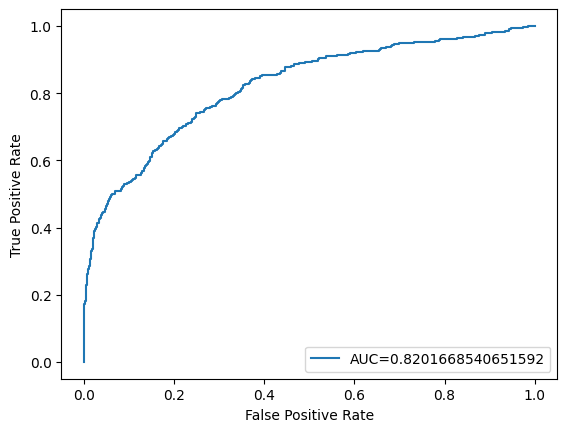

In [120]:
#plot the auc_roc_curve

print("Fig "+str(figNo)+" - "+ "auc_roc curve (model3)")
figNo+=1

fpr3, tpr3, thresholds3  = metrics.roc_curve(y_test, y_pred3)
auc3 = roc_auc_score(y_test, y_pred3)

plt.plot(fpr3,tpr3,label="AUC="+str(auc3))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (area under the curve) is 0.82, which means that the predictions of the model are 82% correct.



In [121]:
#Calculate the best threshold using Youden's J statistic
J3 = tpr3 - fpr3
ix3 = argmax(J3)
best_thresh3 = thresholds3[ix3]
print("The best threshold is %f"%best_thresh3)

<IPython.core.display.Javascript object>

The best threshold is 0.160008


<IPython.core.display.Javascript object>

Fig 48 - auc_roc curve with best threshold (model3)


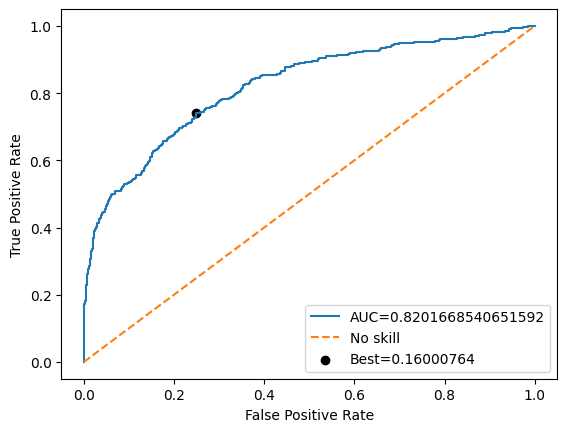

In [122]:
#plot the auc_roc_curve with the best threshold
print("Fig "+str(figNo)+" - "+ "auc_roc curve with best threshold (model3)")
figNo+=1

fpr3, tpr3, thresholds3  = metrics.roc_curve(y_test, y_pred3)
auc3 = roc_auc_score(y_test, y_pred3)

plt.plot(fpr3,tpr3,label="AUC="+str(auc3))
plt.plot([0,1],[0,1], linestyle='--',label="No skill")
plt.scatter(fpr3[ix3], tpr3[ix3], marker='o', color='black', label='Best='+str(best_thresh3))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Lets use the threshold in our prediction

In [123]:
#run prediction, set the threshold to best threshold
y_pred3_bt = model3.predict(X_test)
y_pred3_bt = (y_pred3_bt > best_thresh3)
y_pred3_bt

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

Fig 49 - Confucious Matrix (model3)


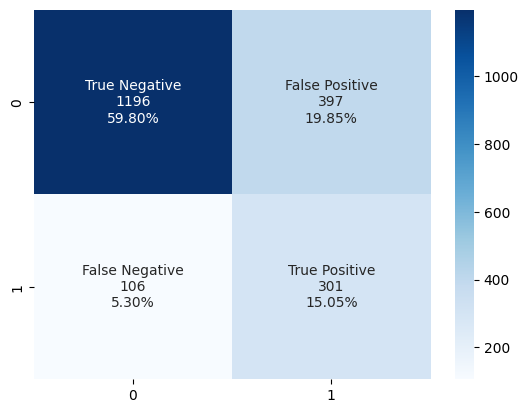

In [124]:
#create a confusion matrix
print("Fig "+str(figNo)+" - "+ "Confucious Matrix (model3)")
figNo+=1

cm3 = confusion_matrix(y_test, y_pred3_bt)
labels = ['True Negative','False Positive','False Negative','True Positive']
make_confusion_matrix(cm3, group_names=labels, #categories=categories,
                      cmap='Blues')

The Number of False Negatives increased so this model performed worse than the previous 2 models.

In [125]:
#Classification report
cr3= metrics.classification_report(y_test,y_pred3_bt)
print(cr3)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1593
           1       0.43      0.74      0.54       407

    accuracy                           0.75      2000
   macro avg       0.67      0.75      0.69      2000
weighted avg       0.82      0.75      0.77      2000



For class 1 (Churn):
-Precision of 0.55
-Recall of 0.61
-F1-Score of 0.58

This model performed worse than Model1 and Model2 because FN increased. Recall, Precision also decreased.

##**Model 4 Adam Dropout**

- Activation: Relu and sigmoid in output
- Hidden Layers: 2
- kernel_initializer = 'he_uniform'
- Neurons: input: 64, hl1: 32, hl2: 32
- Optimizer: Adam
- Adds Dropout

We use sigmoid because we want probability outcomes
Loss: binary_crossentropy for binary classification

- No BatchNormalization
- NO early stopping

In [126]:
#we clear the backend session
K.clear_session()

#set random number seed
np.random.seed(50)
random.seed(50)
tf.random.set_seed(50)

<IPython.core.display.Javascript object>

In [127]:
#Initialize the Neural Network
# Initializing the model
model4 = Sequential()

# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model4.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(10,)))
model4.add(Dropout(0.2))

# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model4.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model4.add(Dropout(0.2))

# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model4.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

# Adding the output layer with one neuron and sigmoid as activation
model4.add(Dense(1, activation='sigmoid'))


<IPython.core.display.Javascript object>

In [128]:
#model summary
model4.summary()

<IPython.core.display.Javascript object>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,873
Trainable params: 3,873
Non-trainabl

In [129]:
# Initializing the Optimizer
optimizer4 = Adam(learning_rate=0.001)

# Compiling the model with 'mse' as loss function and metrics
model4.compile(loss='binary_crossentropy', optimizer=optimizer4, metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [130]:
# Fitting the model on train and validation with 50 epochs
history4 = model4.fit(X_train, y_train, validation_split=0.2, epochs=50,batch_size=32,verbose=1)

<IPython.core.display.Javascript object>

Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.5178 - accuracy: 0.7645 - val_loss: 0.4453 - val_accuracy: 0.8081
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4569 - accuracy: 0.8094 - val_loss: 0.4196 - val_accuracy: 0.8225
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4374 - accuracy: 0.8153 - val_loss: 0.4063 - val_accuracy: 0.8263
Epoch 4/50
200/200 [==============================] - 1s 4ms/step - loss: 0.4251 - accuracy: 0.8169 - val_loss: 0.3977 - val_accuracy: 0.8369
Epoch 5/50
200/200 [==============================] - 1s 5ms/step - loss: 0.4151 - accuracy: 0.8211 - val_loss: 0.3835 - val_accuracy: 0.8419
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.4066 - accuracy: 0.8306 - val_loss: 0.3768 - val_accuracy: 0.8425
Epoch 7/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3996 - accuracy: 0.8266 - val_loss: 0.3707 - val_accuracy: 0.8475
Epoch 

<IPython.core.display.Javascript object>

Fig 50 - Losses vs epochs (model4)
63/63 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.8645


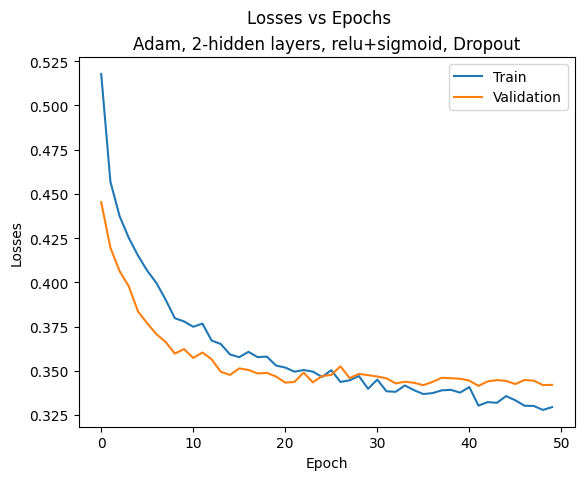

In [131]:
# Capturing learning history per epoch
print("Fig "+str(figNo)+" - "+ "Losses vs epochs (model4)")
figNo+=1

hist4  = pd.DataFrame(history4.history)
hist4['epoch'] = history4.epoch

# Plotting accuracy at different epochs
plt.suptitle('Losses vs Epochs')
plt.title("Adam, 2-hidden layers, relu+sigmoid, Dropout")
plt.plot(hist4['loss'])
plt.plot(hist4['val_loss'])
plt.ylabel('Losses')
plt.xlabel('Epoch')

plt.legend(("Train" , "Validation") , loc =0)

#Printing results
results4 = model4.evaluate(X_test, y_test)

The validation Losses decreased as epochs increased. Above 40 epochs, the validation losses seem to be leveling.

<IPython.core.display.Javascript object>

Fig 51 - Accuracy vs epochs (model4)


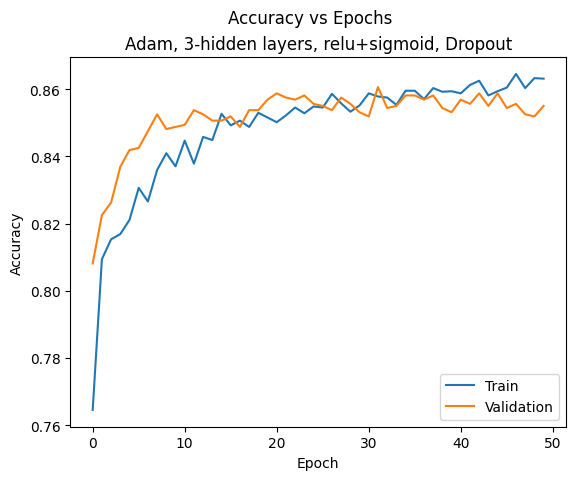

In [132]:
#plot accuracy vs epochs
print("Fig "+str(figNo)+" - "+ "Accuracy vs epochs (model4)")
figNo+=1

plt.plot(hist4['accuracy'])
plt.plot(hist4['val_accuracy'])
plt.suptitle('Accuracy vs Epochs')
plt.title("Adam, 3-hidden layers, relu+sigmoid, Dropout")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

The validation accuracy increases until about 30 epochs. After that, the accuracy levels.

In [133]:
#head of history dataframe for model3
hist4.head()

<IPython.core.display.Javascript object>

loss  accuracy  val_loss  val_accuracy  epoch
0  0.517821  0.764531  0.445309      0.808125      0
1  0.456937  0.809375  0.419635      0.822500      1
2  0.437415  0.815313  0.406312      0.826250      2
3  0.425111  0.816875  0.397741      0.836875      3
4  0.415134  0.821094  0.383529      0.841875      4

In [134]:
#run prediction
y_pred4 = model4.predict(X_test)
y_pred4

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 1ms/step


array([[0.02479371],
       [0.07036158],
       [0.21440402],
       ...,
       [0.26158682],
       [0.02161454],
       [0.14370544]], dtype=float32)

<IPython.core.display.Javascript object>

Fig 52 - roc curve (model4)


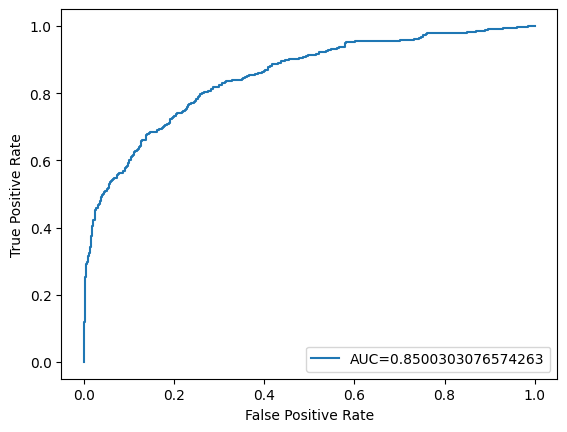

In [135]:
#plot the auc_roc_curve
print("Fig "+str(figNo)+" - "+ "roc curve (model4)")
figNo+=1

fpr4, tpr4, thresholds4  = metrics.roc_curve(y_test, y_pred4)
auc4 = roc_auc_score(y_test, y_pred4)

plt.plot(fpr4,tpr4,label="AUC="+str(auc4))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (area under the curve) is 0.85, which means that the predictions of the model are 85% correct.



In [136]:
#Calculate the best threshold using Youden's J statistic
J4 = tpr4 - fpr4
ix4 = argmax(J4)
best_thresh4 = thresholds4[ix4]
print("The best threshold is %f"%best_thresh4)

<IPython.core.display.Javascript object>

The best threshold is 0.148938


<IPython.core.display.Javascript object>

Fig 53 - auc_roc curve (model4)


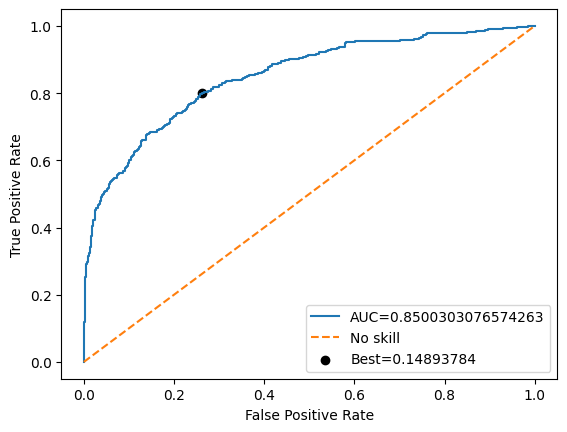

In [137]:
#plot the auc_roc_curve with the best threshold
print("Fig "+str(figNo)+" - "+ "auc_roc curve (model4)")
figNo+=1

fpr4, tpr4, thresholds4  = metrics.roc_curve(y_test, y_pred4)
auc4 = roc_auc_score(y_test, y_pred4)

plt.plot(fpr4,tpr4,label="AUC="+str(auc4))
plt.plot([0,1],[0,1], linestyle='--',label="No skill")
plt.scatter(fpr4[ix4], tpr4[ix4], marker='o', color='black', label='Best='+str(best_thresh4))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Lets use the threshold in our prediction

In [138]:
#run prediction, set the threshold to best threshold
y_pred4_bt = model4.predict(X_test)
y_pred4_bt = (y_pred4_bt > best_thresh4)
y_pred4_bt

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

Fig 54 - Confucious Matrix (model4)


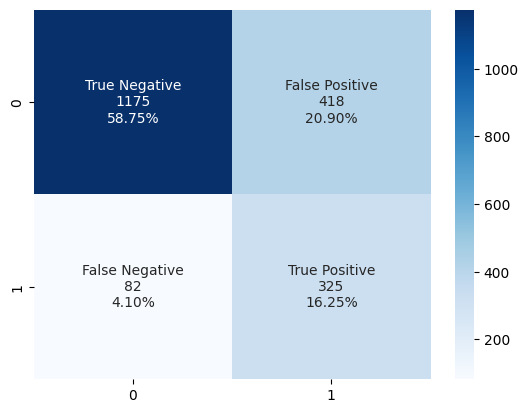

In [139]:
#create a confusion matrix
print("Fig "+str(figNo)+" - "+ "Confucious Matrix (model4)")

cm4 = confusion_matrix(y_test, y_pred4_bt)
labels = ['True Negative','False Positive','False Negative','True Positive']
make_confusion_matrix(cm4, group_names=labels, #categories=categories,
                      cmap='Blues')

The False Negatives decreased. This is the best model we have seen so far. We anticipate that Recall will increase.

In [140]:
cr4= metrics.classification_report(y_test,y_pred4_bt)
print(cr4)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1593
           1       0.44      0.80      0.57       407

    accuracy                           0.75      2000
   macro avg       0.69      0.77      0.69      2000
weighted avg       0.83      0.75      0.77      2000



For class 1 (Churn):
-Precision of 0.50
-Recall of 0.76
-F1-Score of 0.61

This model performs better than the previous models.

##**Model 5 Using RandomizedSearch to fine tune hyperparameters**

- Activation: Relu and sigmoid in output
- Hidden Layers: 3
- kernel_initializer = 'he_uniform'
- Neurons: input: 128, 128, 32, hl2: 32
- Optimizer: Adam
- batch_size:[32, 64, 128]
- Learning Rate:[0.01,0.1,0.001]
- Adds Dropout

We use sigmoid because we want probability outcomes
Loss: binary_crossentropy for binary classification

- No BatchNormalization
- NO early stopping

In [141]:
#we clear the backend session
K.clear_session()

#set random number seed
np.random.seed(50)
random.seed(50)
tf.random.set_seed(50)

<IPython.core.display.Javascript object>

In [142]:
#function to traverse the model with different hyperparameters
def create_ann_model(lr,batch_size):
    np.random.seed(777)
    model = Sequential()

    model.add(Dense(128,activation='relu',input_shape = (10,)))
    model.add(Dropout(0.2))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

<IPython.core.display.Javascript object>

In [143]:
keras_estimator = KerasClassifier(build_fn=create_ann_model, verbose=1)
# define the grid search parameters
param_random = {
    'batch_size':[32, 64, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
random= RandomizedSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_distributions=param_random,n_jobs=-1)

<IPython.core.display.Javascript object>

In [144]:
random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 9 candidates, totalling 27 fits
200/200 [==============================] - 2s 5ms/step - loss: 0.4518 - accuracy: 0.8067 - val_loss: 0.4268 - val_accuracy: 0.8406
Best: 0.823124 using {'lr': 0.01, 'batch_size': 32}


Notice that the best parameters are lr: 0.01 and batch_size: 32.

In [145]:
#model
estimator5 =create_ann_model(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])
estimator5.summary()

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1408      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [146]:
#history
optimizer5 = tf.keras.optimizers.Adam(random_result.best_params_['lr'])
estimator5.compile(loss='binary_crossentropy',optimizer=optimizer5,metrics=['accuracy'])
history5=estimator5.fit(X_train, y_train, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)

<IPython.core.display.Javascript object>

Epoch 1/50
100/100 [==============================] - 2s 5ms/step - loss: 0.4524 - accuracy: 0.8027 - val_loss: 0.3921 - val_accuracy: 0.8363
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 0.3892 - accuracy: 0.8380 - val_loss: 0.3605 - val_accuracy: 0.8506
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3757 - accuracy: 0.8491 - val_loss: 0.3534 - val_accuracy: 0.8525
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3660 - accuracy: 0.8497 - val_loss: 0.3528 - val_accuracy: 0.8556
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3642 - accuracy: 0.8508 - val_loss: 0.3499 - val_accuracy: 0.8512
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3621 - accuracy: 0.8502 - val_loss: 0.3475 - val_accuracy: 0.8581
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3588 - accuracy: 0.8545 - val_loss: 0.3510 - val_accuracy: 0.8469
Epoch 

<IPython.core.display.Javascript object>

Fig 54 - Losses vs epochs (model5)
63/63 [==============================] - 0s 3ms/step - loss: 0.3660 - accuracy: 0.8615


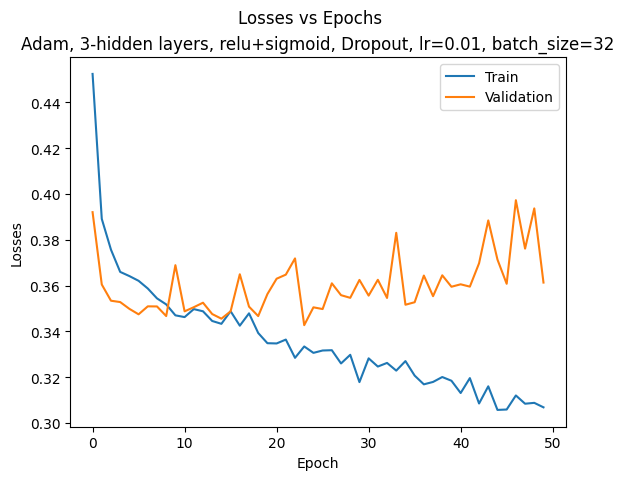

In [147]:
# Capturing learning history per epoch

print("Fig "+str(figNo)+" - "+ "Losses vs epochs (model5)")
figNo+=1

hist5  = pd.DataFrame(history5.history)
hist5['epoch'] = history5.epoch

# Plotting accuracy at different epochs
plt.suptitle('Losses vs Epochs')
plt.title("Adam, 3-hidden layers, relu+sigmoid, Dropout, lr=0.01, batch_size=32")
plt.plot(hist5['loss'])
plt.plot(hist5['val_loss'])
plt.ylabel('Losses')
plt.xlabel('Epoch')

plt.legend(("Train" , "Validation") , loc =0)

#Printing results
results5 = estimator5.evaluate(X_test, y_test)

The validation losses show a lot of noise but the trend is that past 12 epochs, the losses have a trend to increase.

<IPython.core.display.Javascript object>

Fig 55 - Accuracy vs epochs (model5)


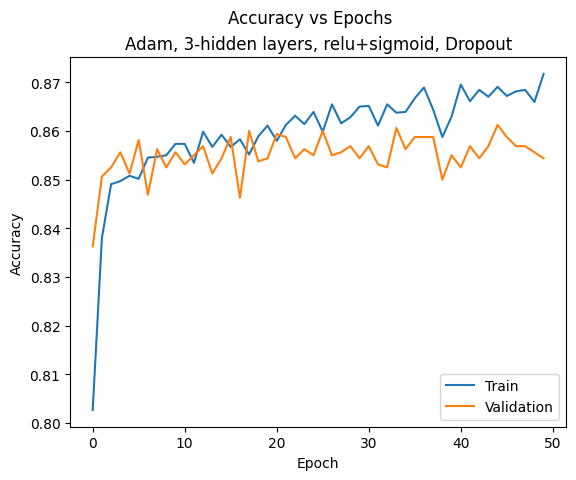

In [148]:
#Plot accuracy vs epochs

print("Fig "+str(figNo)+" - "+ "Accuracy vs epochs (model5)")
figNo+=1

plt.plot(hist5['accuracy'])
plt.plot(hist5['val_accuracy'])
plt.suptitle('Accuracy vs Epochs')
plt.title("Adam, 3-hidden layers, relu+sigmoid, Dropout")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

The plot shows noise but the validation accuracy trend isto increase as epochs pass 50.

In [149]:
#head of history dataframe for model3
hist5.head()

<IPython.core.display.Javascript object>

loss  accuracy  val_loss  val_accuracy  epoch
0  0.452449  0.802656  0.392090      0.836250      0
1  0.389153  0.837969  0.360505      0.850625      1
2  0.375704  0.849063  0.353424      0.852500      2
3  0.366008  0.849688  0.352839      0.855625      3
4  0.364185  0.850781  0.349876      0.851250      4

In [150]:
#run prediction
y_pred5 = estimator5.predict(X_test)
y_pred5

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 3ms/step


array([[0.00262475],
       [0.05383372],
       [0.13967538],
       ...,
       [0.25558066],
       [0.10932834],
       [0.04323178]], dtype=float32)

<IPython.core.display.Javascript object>

Fig 56 - roc curve (model5)


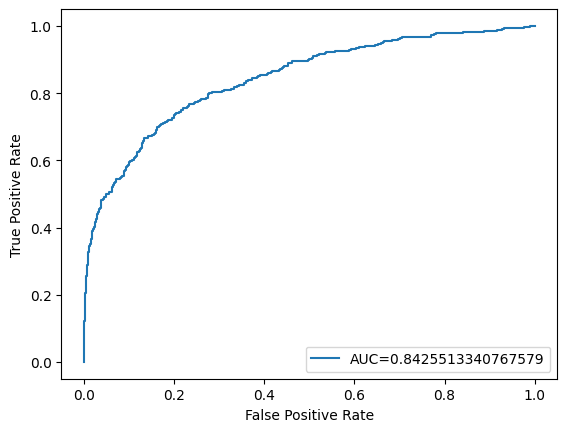

In [151]:
#plot the auc_roc_curve

print("Fig "+str(figNo)+" - "+ "roc curve (model5)")
figNo+=1

fpr5, tpr5, thresholds5  = metrics.roc_curve(y_test, y_pred5)
auc5 = roc_auc_score(y_test, y_pred5)

plt.plot(fpr5,tpr5,label="AUC="+str(auc5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (area under the curve) is 0.84, which means that the predictions of the model are 82% correct.



In [152]:
#Calculate the best threshold using Youden's J statistic
J5 = tpr5 - fpr5
ix5 = argmax(J5)
best_thresh5 = thresholds5[ix5]
print("The best threshold is %f"%best_thresh5)

<IPython.core.display.Javascript object>

The best threshold is 0.253086


<IPython.core.display.Javascript object>

Fig 57 - auc_roc curve with Best threshold (model5)


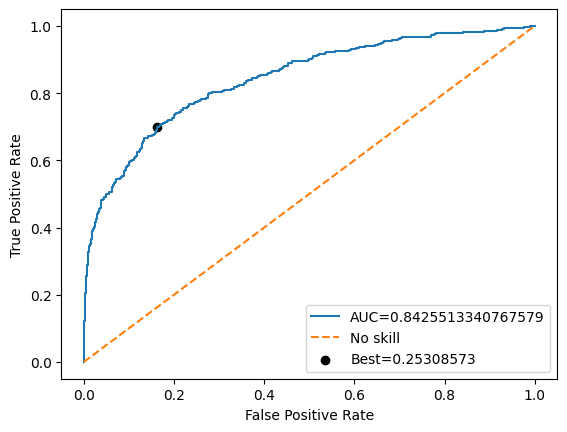

In [153]:
#plot the auc_roc_curve with the best threshold

print("Fig "+str(figNo)+" - "+ "auc_roc curve with Best threshold (model5)")
figNo+=1

fpr5, tpr5, thresholds5  = metrics.roc_curve(y_test, y_pred5)
auc5 = roc_auc_score(y_test, y_pred5)

plt.plot(fpr5,tpr5,label="AUC="+str(auc5))
plt.plot([0,1],[0,1], linestyle='--',label="No skill")
plt.scatter(fpr5[ix5], tpr5[ix5], marker='o', color='black', label='Best='+str(best_thresh5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Lets use the threshold in our prediction

In [154]:
#run prediction, set the threshold to best threshold
y_pred5_bt = estimator5.predict(X_test)
y_pred5_bt = (y_pred5_bt > best_thresh5)
y_pred5_bt

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

Fig 58 - Confucious Matrix (model5)


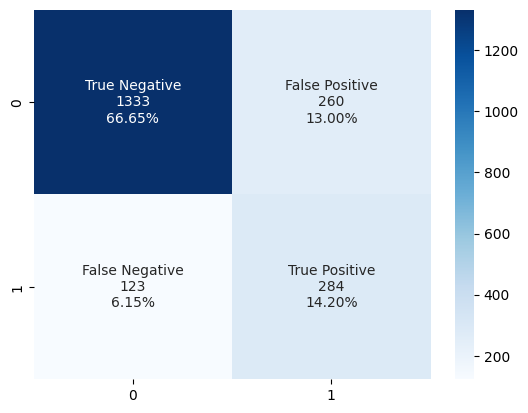

In [155]:
#create a confusion matrix
print("Fig "+str(figNo)+" - "+ "Confucious Matrix (model5)")
figNo+=1

cm5 = confusion_matrix(y_test, y_pred5_bt)
labels = ['True Negative','False Positive','False Negative','True Positive']
make_confusion_matrix(cm5, group_names=labels, #categories=categories,
                      cmap='Blues')

False negatives is 5.10%, this is the second best performing model.

In [156]:
#Classification report
cr5= metrics.classification_report(y_test,y_pred5_bt)
print(cr5)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.92      0.84      0.87      1593
           1       0.52      0.70      0.60       407

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.84      0.81      0.82      2000



For class 1 (Churn):
-Precision of 0.46
-Recall of 0.75
-F1-Score of 0.57

This model performs well.

##**Model 6 using GridSearch to tune hyperparameters**

- Activation: Relu and sigmoid in output
- Hidden Layers: 3
- kernel_initializer = 'he_uniform'
- Neurons: 128, 64, 64, 32
- Optimizer: Adam
- Adds Dropout

We use sigmoid because we want probability outcomes
Loss: binary_crossentropy for binary classification

- No BatchNormalization
- NO early stopping

In [157]:
#we clear the backend session
K.clear_session()

#set random number seed
np.random.seed(50)
#random.seed(50)
tf.random.set_seed(50)

<IPython.core.display.Javascript object>

In [158]:
def create_ann2_model(lr,batch_size):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(128,activation='relu',input_shape =(10,)))
    model.add(Dropout(0.2))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

<IPython.core.display.Javascript object>

In [159]:
keras_estimator = KerasClassifier(build_fn=create_ann2_model, verbose=1)
# define the grid search parameters
param_grid = {
    'batch_size':[64,32, 128],
    "lr":[0.01,0.1,0.001],}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_grid=param_grid,n_jobs=-1)

<IPython.core.display.Javascript object>

In [160]:
#to keep track of time length of operation
import time

# store starting time
begin = time.time()


grid_result = grid.fit(X_train, y_train,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

time.sleep(1)
# store end time
end = time.time()

# total time taken
print(f"Total runtime of the program is {end - begin}")

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 9 candidates, totalling 27 fits
200/200 [==============================] - 2s 6ms/step - loss: 0.4494 - accuracy: 0.8122 - val_loss: 0.3745 - val_accuracy: 0.8512
Best: 0.828625 using {'batch_size': 32, 'lr': 0.01}
Total runtime of the program is 53.367727279663086


Notice that best lr is 0.01 and best batch_size is 32

In [161]:
#create model
estimator6 =create_ann2_model(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])
estimator6.summary()

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1408      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [162]:
#History
optimizer6 = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
estimator6.compile(loss='binary_crossentropy',optimizer=optimizer6,metrics=['accuracy'])
history6=estimator6.fit(X_train, y_train, epochs=50, batch_size = 64, verbose=1,validation_split=0.2)

<IPython.core.display.Javascript object>

Epoch 1/50
100/100 [==============================] - 2s 5ms/step - loss: 0.4448 - accuracy: 0.8114 - val_loss: 0.3878 - val_accuracy: 0.8400
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3876 - accuracy: 0.8427 - val_loss: 0.3573 - val_accuracy: 0.8519
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3761 - accuracy: 0.8500 - val_loss: 0.3675 - val_accuracy: 0.8512
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3651 - accuracy: 0.8480 - val_loss: 0.3534 - val_accuracy: 0.8475
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3640 - accuracy: 0.8461 - val_loss: 0.3540 - val_accuracy: 0.8494
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3642 - accuracy: 0.8481 - val_loss: 0.3563 - val_accuracy: 0.8475
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.3532 - accuracy: 0.8511 - val_loss: 0.3586 - val_accuracy: 0.8475
Epoch 

<IPython.core.display.Javascript object>

Fig 59 - Losses vs Epochs (model6)
63/63 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8615


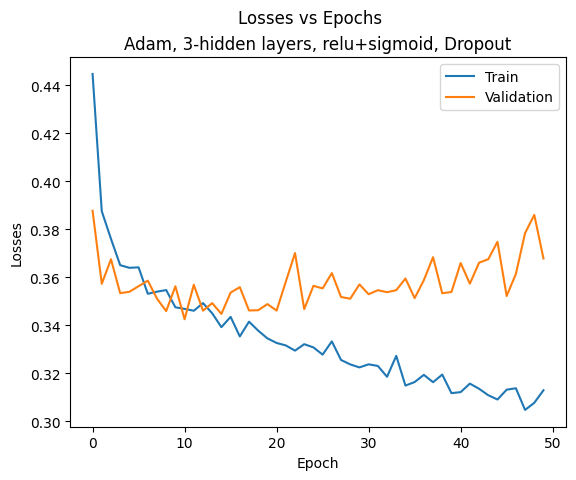

In [163]:
# Capturing learning history per epoch

print("Fig "+str(figNo)+" - "+ "Losses vs Epochs (model6)")
figNo+=1

hist6  = pd.DataFrame(history6.history)
hist6['epoch'] = history6.epoch

# Plotting accuracy at different epochs
plt.suptitle('Losses vs Epochs')
plt.title("Adam, 3-hidden layers, relu+sigmoid, Dropout")
plt.plot(hist6['loss'])
plt.plot(hist6['val_loss'])
plt.ylabel('Losses')
plt.xlabel('Epoch')

plt.legend(("Train" , "Validation") , loc =0)

#Printing results
results6 = estimator5.evaluate(X_test, y_test)

Noisy, the validation losses increase steadily past 14 epochs.

<IPython.core.display.Javascript object>

Fig 60 - Accuracy vs epochs (model6)


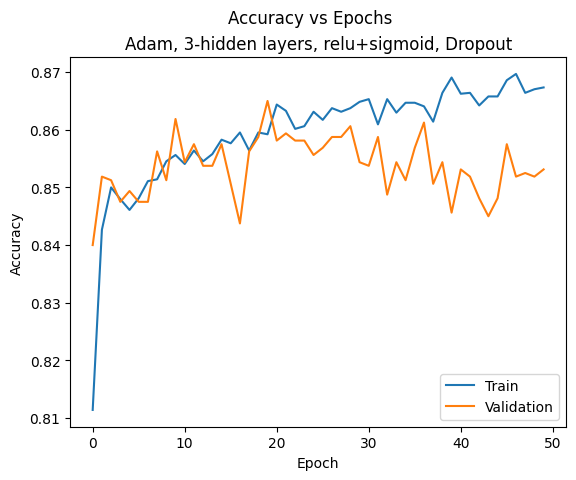

In [164]:
#plot accuracy vs epochs

print("Fig "+str(figNo)+" - "+ "Accuracy vs epochs (model6)")
figNo+=1

plt.plot(hist6['accuracy'])
plt.plot(hist6['val_accuracy'])
plt.suptitle('Accuracy vs Epochs')
plt.title("Adam, 3-hidden layers, relu+sigmoid, Dropout")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Validation accuracy starts to decrease steadily past 14 epochs.

In [165]:
#head of history dataframe for model3
hist6.head()

<IPython.core.display.Javascript object>

loss  accuracy  val_loss  val_accuracy  epoch
0  0.444792  0.811406  0.387756      0.840000      0
1  0.387558  0.842656  0.357336      0.851875      1
2  0.376053  0.850000  0.367548      0.851250      2
3  0.365086  0.847969  0.353418      0.847500      3
4  0.363987  0.846094  0.353980      0.849375      4

In [166]:
#run prediction
y_pred6 = estimator6.predict(X_test)
y_pred6

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[0.00117836],
       [0.05430065],
       [0.04738091],
       ...,
       [0.4236301 ],
       [0.01506621],
       [0.04282361]], dtype=float32)

<IPython.core.display.Javascript object>

Fig 61 - auc_roc curve (model6)


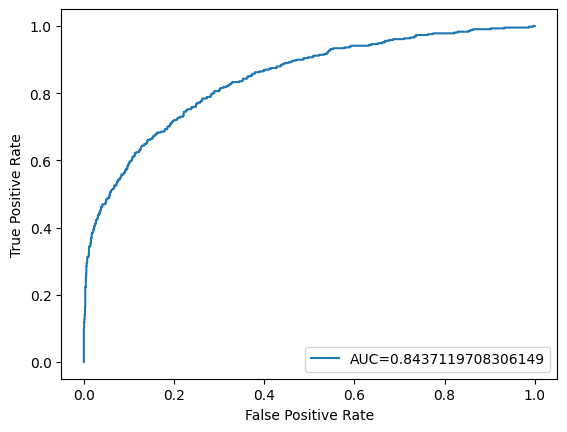

In [167]:
#plot the auc_roc_curve

print("Fig "+str(figNo)+" - "+ "auc_roc curve (model6)")
figNo+=1

fpr6, tpr6, thresholds6  = metrics.roc_curve(y_test, y_pred6)
auc6 = roc_auc_score(y_test, y_pred6)

plt.plot(fpr6,tpr6,label="AUC="+str(auc6))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC (area under the curve) is 0.84, which means that the predictions of the model are 82% correct.



In [168]:
#Calculate the best threshold using Youden's J statistic
J6 = tpr6 - fpr6
ix6 = argmax(J6)
best_thresh6 = thresholds4[ix6]
print("The best threshold is %f"%best_thresh6)

<IPython.core.display.Javascript object>

The best threshold is 0.159475


<IPython.core.display.Javascript object>

Fig 62 - auc_roc curve with Best threshold (model6)


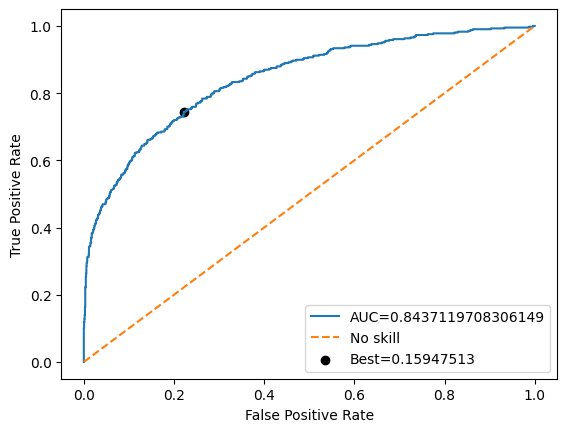

In [169]:
#plot the auc_roc_curve with the best threshold

print("Fig "+str(figNo)+" - "+ "auc_roc curve with Best threshold (model6)")
figNo+=1

fpr6, tpr6, thresholds6  = metrics.roc_curve(y_test, y_pred6)
auc6 = roc_auc_score(y_test, y_pred6)

plt.plot(fpr6,tpr6,label="AUC="+str(auc6))
plt.plot([0,1],[0,1], linestyle='--',label="No skill")
plt.scatter(fpr6[ix6], tpr6[ix6], marker='o', color='black', label='Best='+str(best_thresh6))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Lets use the threshold in our prediction

In [170]:
#run prediction, set the threshold to best threshold
y_pred6_bt = estimator6.predict(X_test)
y_pred6_bt = (y_pred6_bt > best_thresh6)
y_pred6_bt

<IPython.core.display.Javascript object>

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

<IPython.core.display.Javascript object>

Fig 63 - Confucious Matrix (model6)


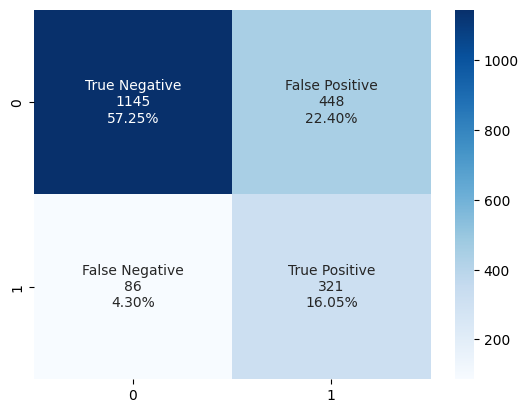

In [171]:
#create a confusion matrix

print("Fig "+str(figNo)+" - "+ "Confucious Matrix (model6)")
figNo+=1
cm6 = confusion_matrix(y_test, y_pred6_bt)
labels = ['True Negative','False Positive','False Negative','True Positive']
make_confusion_matrix(cm6, group_names=labels, #categories=categories,
                      cmap='Blues')

False negatives are 4.35%. There was a model that produced better results.

In [172]:
#Classification report
cr6= metrics.classification_report(y_test,y_pred6_bt)
print(cr6)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1593
           1       0.42      0.79      0.55       407

    accuracy                           0.73      2000
   macro avg       0.67      0.75      0.68      2000
weighted avg       0.83      0.73      0.76      2000



For class 1 (Churn):
-Precision of 0.39
-Recall of 0.82
-F1-Score of 0.52

Recall is 0.82 which is highest in all models.

##**Comparing Models**

In [173]:
#Plots for NumOfProducts vs other features
print("Model 1 SGD")
print('-'*50)
print(cr1)
print('\n')
print("Model 2 Adam")
print('-'*50)
print(cr2)
print("Model 3 Adam with BN")
print('-'*50)
print(cr3)
print('\n')
print("Model 4 Adam with Dropout")
print('-'*50)
print(cr4)
print("Model 5 Adam with Dropout and RandomizedSearch")
print('-'*50)
print(cr5)
print('\n')
print("Model 6 Adam with Dropout and GridSearch")
print('-'*50)
print(cr6)
print('\n')
mod_comp = {'Model':['1','2','3','4','5','6'],
            'Description':['SGD','Adam','Adam with BN','Adam with Dropout','Adam w/ Droput RandomizedSearch',
                           'Adam w/ Droput GridSearch'],
            'FN':[101,111,88,82,98,87],
            'TP':[306,296,319,325,309,320],
            'Recall':[0.75,0.73,0.78,0.80,0.76,0.79],
            'Precision':[0.38,0.45,0.41,0.44,0.43,0.42],
            'F1':[0.50,0.56,0.54,0.57,0.55,0.55]}

models_comp_df = pd.DataFrame(data=mod_comp)
models_comp_df


<IPython.core.display.Javascript object>

Model 1 SGD
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.69      0.78      1593
           1       0.38      0.75      0.50       407

    accuracy                           0.70      2000
   macro avg       0.65      0.72      0.64      2000
weighted avg       0.81      0.70      0.73      2000



Model 2 Adam
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1593
           1       0.45      0.73      0.56       407

    accuracy                           0.77      2000
   macro avg       0.68      0.75      0.70      2000
weighted avg       0.82      0.77      0.78      2000

Model 3 Adam with BN
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1593
           1       0.43      0.74   

Model                      Description   FN   TP  Recall  Precision    F1
0     1                              SGD  101  306    0.75       0.38  0.50
1     2                             Adam  111  296    0.73       0.45  0.56
2     3                     Adam with BN   88  319    0.78       0.41  0.54
3     4                Adam with Dropout   82  325    0.80       0.44  0.57
4     5  Adam w/ Droput RandomizedSearch   98  309    0.76       0.43  0.55
5     6        Adam w/ Droput GridSearch   87  320    0.79       0.42  0.55

Our best Performing Model: Model4 using Adam and Dropouts

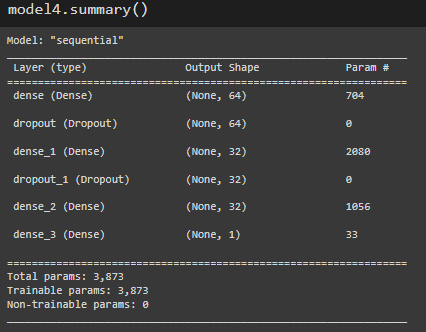

Notice that Model4 -Adam with Dropout has a Recall of 0.80 for class 1. This is an indication of identifying True Positives correctly. The precision is 0.44 and while this is not the best in all models (Model 2 has a Precision of 0.45 for Class 1), having a stronger Recall and a good Precision is preferred. Additionally, Model4 also has the highest F1 score (0.57).


## **Insights and Recommendations**

**Insights**

1. Density of Churn customers is roughly 20% the size of no churn customers. This number is too high.
2. German customers churn ratio is the highest.
3. German customers have the highest Balances.
4. Female customers churn more than male customers.
5. Customers with 3-4 products are older than customers with 1-2 products.
6. Customers with 3 and 4 products have larger balances.
7. Customers that have 2 products churn the least.
8. Customer with 1 product churn the most.
9. Customers with 3 products have higher Estimated Salaries.
10. Customer with a credit score below 580 churn the most.
11. Customers Age between 40 and 50 years of age, churn the most.
12. The number of customers at Year zero (tenure=0) is significantly less than the number of customers with tenure 1 to 9. Tenure 0 customers are barely 40% of the average number of customers of Tenure 1 to 9.
13. Tenure 10 customers are roughly 40% of customers Tenure 1 to 9.
14. Credit Cards do not influence churn.
15. Inactive Customers tend to churn.
16. Customers with Balance 0 tend to churn.
.  

**Recommendations**
1. Implement a customer retention program in Germany. Germany has the highest churn ratio among the three countries served while having the largest Balance.

2. Implement a new customer acquisition program in Germany. Again, German customers have the largest balance accounts.

3. Implement a plan to help customers increase their Credit scores particularly those customers with a credit score below 400 to avoid churn.

4. Design a marketing and promotion plan to fidelize customers that are in age group 40-50 because they significantly churn.

4. Incentivate customers to increase their deposits, possibly to 50,000 or above because customers with such balances and above churn less.

5. Customize products to incite female customers to stay with the bank as they churn at a higher ratio than men.

7. Create a marketing plan to incite customers to become active members in order to reduce churn.

8. Focus on promoting or packaging products so customers have 2 products instead of 1.

9. Devise a strategy to reduce high churn in customers with 3 and 4 products. Do not promote more than 2 products until this is figured out.

10. Create a marketing plan to grow new customers to at least tenure 1 to 9 values.

11. Fidelize customers that are tenure=10 because the group will tend to decrease in size. Plan ahead of tenure=9.

**Conclusions**

The bank has a high churn ratio, while this is normal in the services industries, what is worrisome is that the number of customers with Tenure=0 is only 40% of the number of customers of each Tenure 1 to 9. By predicting the probabilities of whether a customer will churn or not, the bank can create strategies before churn occurs to target customer groups with the objective of fidelization, securing revenue and market share.
